In [0]:
import numpy as np
import cv2
from skimage import io
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import img_as_ubyte
import distutils.dir_util
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel
from skimage.feature import hog
from skimage.measure import regionprops
from tqdm import tqdm
import json

In [0]:
def DICE_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label              
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0: 
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

def db_eval_boundary(foreground_mask,gt_mask,bound_th=0.008):
    """
    Compute mean,recall and decay from per-frame evaluation.
    Calculates precision/recall for boundaries between foreground_mask and
    gt_mask using morphological operators to speed it up.

    Arguments:
        foreground_mask (ndarray): binary segmentation image.
        gt_mask         (ndarray): binary annotated image.

    Returns:
        F (float): boundaries F-measure
    """
    assert np.atleast_3d(foreground_mask).shape[2] == 1

    bound_pix = bound_th if bound_th >= 1 else \
            np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))

    # Get the pixel boundaries of both masks
    fg_boundary = seg2bmap(foreground_mask);
    gt_boundary = seg2bmap(gt_mask);

    from skimage.morphology import binary_dilation,disk

    fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
    gt_dil = binary_dilation(gt_boundary,disk(bound_pix))

    # Get the intersection
    gt_match = gt_boundary * fg_dil
    fg_match = fg_boundary * gt_dil

    # Area of the intersection
    n_fg     = np.sum(fg_boundary)
    n_gt     = np.sum(gt_boundary)

    #% Compute precision and recall
    if n_fg == 0 and  n_gt > 0:
        precision = 1
        recall = 0
    elif n_fg > 0 and n_gt == 0:
        precision = 0
        recall = 1
    elif n_fg == 0  and n_gt == 0:
        precision = 1
        recall = 1
    else:
        precision = np.sum(fg_match)/float(n_fg)
        recall    = np.sum(gt_match)/float(n_gt)

    # Compute F measure
    if precision + recall == 0:
        F = 0
    else:
        F = 2*precision*recall/(precision+recall);

    return F*100.

def seg2bmap(seg,width=None,height=None):
    """
    From a segmentation, compute a binary boundary map with 1 pixel wide
    boundaries.  The boundary pixels are offset by 1/2 pixel towards the
    origin from the actual segment boundary.

    Arguments:
        seg     : Segments labeled from 1..k.
        width   : Width of desired bmap  <= seg.shape[1]
        height  : Height of desired bmap <= seg.shape[0]

    Returns:
        bmap (ndarray):	Binary boundary map.
    """

    seg = seg.astype(np.bool)
    seg[seg>0] = 1

    assert np.atleast_3d(seg).shape[2] == 1

    width  = seg.shape[1] if width  is None else width
    height = seg.shape[0] if height is None else height

    h,w = seg.shape[:2]

    ar1 = float(width) / float(height)
    ar2 = float(w) / float(h)

    assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
        'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)

    e  = np.zeros_like(seg)
    s  = np.zeros_like(seg)
    se = np.zeros_like(seg)

    e[:,:-1]    = seg[:,1:]
    s[:-1,:]    = seg[1:,:]
    se[:-1,:-1] = seg[1:,1:]

    b        = seg^e | seg^s | seg^se
    b[-1,:]  = seg[-1,:]^e[-1,:]
    b[:,-1]  = seg[:,-1]^s[:,-1]
    b[-1,-1] = 0

    if w == width and h == height:
        bmap = b
    else:
        bmap = np.zeros((height,width))
        for x in range(w):
            for y in range(h):
                if b[y,x]:
                    j = 1+np.floor((y-1)+height / h)
                    i = 1+np.floor((x-1)+width  / h)
                    bmap[j,i] = 1;

    return bmap

def centroid_assessment(groundtruth,estimated):
    a = regionprops(groundtruth)
    b = regionprops(estimated)
    return np.linalg.norm(np.array(a[0].centroid)-np.array(b[0].centroid))

def superPixelCentroid(L):
     
# SuperPixelCentroid takes as argument the result of SuperPixels decomposition.
# Returns a NumSuperpixels*2 matrix where each line i are centroid coordinates [x,y]
# of superpixel i


    list_a = regionprops(L+1)
    list_centroid = []
    for point in list_a:
        list_centroid.append(point.centroid)
    list_centroid = np.array(list_centroid)
    
    return list_centroid


def scan_Order(L, num_superpixel):  #L: segments_slic mask 
    
    
#Compute the scan order of the superpixels of image decomposition
#input: image superpixel decomposition L, NumLabels
#output: scan order (np array)


    (rows, colons) = L.shape
    visited = np.zeros(num_superpixel) #save index of visited superpixel 
    S  =  np.zeros(num_superpixel)
    k = 0
    
    for i in range(rows):
        for j in range(colons):
            if(visited[L[i][j]]==0):
                visited[L[i][j]]=1
                S[k] = L[i][j]
                k+=1
    return S.astype(int)

def super_Pixel_Neighbors(L, num_superpixel, scan_order): #L: segments_slic mask; scan_order: a numpyArray contains scanorder of superpixels

    
# superPixelNeighbors take as argument L, NumLabels, and scan order
# Returns two matrix
# The first one contains ones in line i column j if superPixel i
# has j as a previous neighbor (up and left) 
# The second makes the same with next neighbors (right and down)
    
    map_previous = np.zeros((num_superpixel, num_superpixel))
    (rows, colons) = L.shape
    
    for i in range(rows-1):
        for j in range(colons-1):
            if L[i][j] != L[i][j+1]:
                so = np.argwhere(scan_order == L[i][j])[0][0]
                so2 = np.argwhere(scan_order == L[i][j+1])[0][0]
                if so < so2:
                    map_previous[L[i][j+1]][L[i][j]] = 1
                else:
                    map_previous[L[i][j]][L[i][j+1]] = 1
            if L[i][j] != L[i+1][j]:
                so = np.argwhere(scan_order == L[i][j])[0][0]
                so2 = np.argwhere(scan_order == L[i+1][j])[0][0]
                if so < so2:
                    map_previous[L[i+1][j]][L[i][j]] = 1
                else:
                    map_previous[L[i][j]][L[i+1][j]] = 1

    map_next = np.transpose(map_previous)
    return (map_previous, map_next)

def HoGFeatures(A, L, NumLabels): # A: original image, L: corresponding superpixel mask Numlabels: number of superpixels


# HoGFeatures takes as arguments image A, superPixels L, NumLabels
# Returns a matrix where each line i is the mean of HOGs
# of the pixels in the superPixel i


    (rows, colons, _) = A.shape
    F = np.zeros((NumLabels, 9))          # 9 is the dimension of Hogfeatures
    count_points = np.zeros((NumLabels,1))
    for i in range(2,rows-2):
        for j in range(2,colons-2):
            pixel_label = L[i][j]
            F[pixel_label,:] = F[pixel_label,:] + hog(A[i-2:i+3, j-2:j+3, :], orientations=9, pixels_per_cell=(5,5), cells_per_block=(1, 1))
            count_points[pixel_label] += 1
    #max_number = np.max(count_points)  ##  average
    count_points = np.where(count_points==0, 1, count_points)
    F/=count_points
    #F/=np.max(count_points)
    return F

def HoGFeatures_rgb(A, L, NumLabels,w): # A: original image, L: corresponding super-pixel mask Numlabels: number of superpixels


# HoGFeatures takes as arguments image A, superPixels L, NumLabels, the weight of the color feature compared to HOG features  
# Returns a matrix where each line i is the mean of HOGs and RGB color 
# of the pixels in the superPixel i


    (rows, colons, _) = A.shape
    F = np.zeros((NumLabels, 12))          # 9 is the dimension of Hogfeatures
    count_points = np.zeros((NumLabels,1))
    for i in range(2,rows-2):
        for j in range(2,colons-2):
            pixel_label = L[i][j]
            F[pixel_label,:-3] = F[pixel_label,:-3] + hog(A[i-2:i+3, j-2:j+3, :], orientations=9, pixels_per_cell=(5,5), cells_per_block=(1, 1))
            F[pixel_label,-3:] = F[pixel_label,-3:] + w * np.mean(A[i-2:i+3, j-2:j+3, :],axis=(0,1))/255.
            count_points[pixel_label] += 1
    #max_number = np.max(count_points)  ##  average
    count_points = np.where(count_points==0, 1, count_points)
    F/=count_points
    #F/=np.max(count_points)
    return F

def superPatches(C,R): # C: the list of baycenter
    
    
# Compute superPatches
# Input: centroids C, radius R
# Ouput: matrix P, P[i,j] = 1 if j superpixel belongs to superPatch
# centered in i, 0 otherwise


    P = np.zeros((C.shape[0], C.shape[0]))
    for i in range(C.shape[0]):
        P[i,:] = np.transpose(np.sum((C-C[i,:])**2, axis=1) < R**2)
    return P

def two_sigma(A, NumLabels, R):
    
    
# Compute sigma1 and sigma2
# Input: Image A, NumLabels: number of super-pixel, radius R
# Ouput: sigma1 and sigma2
    
    sigma1 = 1/2*np.sqrt(A.shape[0]*A.shape[1]/NumLabels)
    sigma2 = np.sqrt(2) * R
    
    return (sigma1, sigma2)

def randomAssignment(NumLabelsA, NumLabelsB):
    
    
# Assign randomly each superpixel of A to a superPixel of B
# Input: number of superPixels in image A (NumLabelsA) and image B
# (NumLabelsB)
# Output: (NumLabelsA x 2)-Matrix (ANN) where first column is superPixel in
# A and column 2 is the corresponding superLabel in B    


    ANN = np.zeros((NumLabelsA, 2))
    ANN[:,0]= np.arange(NumLabelsA)
    ANN[:,1]= np.random.choice(NumLabelsB, NumLabelsA, replace = True)
    
    return ANN.astype(int)   

def  superPixelsMatchingWeight(Apix, Bpix, ApixCenter, BpixCenter, CA, CB, sigma1, sigma2): 
    
    
# superPixelMatchingLogWeight Input:
# Apix = label of neighboring superPixel evaluated in A
# Bpix = label of neighboring superPixel evaluated in B
# ApixCenter = label of superPixel center of patch in A
# BpixCenter = label of superPixel center of patch in B
# CA = centroids of superPixels in image A
# CB = centroids of superPixels in image B
# sigma1, sigma2 = scale parameters
# Output : logw = log of the weight of the matching of the two superpixels


    x = CB[Bpix,:] - CA[Apix,:] + CA[ApixCenter,:] - CB[BpixCenter,:]  
    logw = -np.sum(x**2)/(sigma1**2) - np.linalg.norm(CA[Apix,:]- CA[ApixCenter,:])**2/(sigma2**2) - np.linalg.norm(CB[Bpix,:]- CB[BpixCenter,:])**2/(sigma2**2)
    w = np.exp(logw)
    return w

def superPatchDistance(patchA, patchB, superPatchesA, superPatchesB, FA, FB, CA, CB, sigma1, sigma2):
    
    
# Compute the distance between patchA and patchB
# Input: indexes of superPatch in A (patchA) and in B (patchB),
# superPatches matrices (superPatchesA, superPathesB), features matrices
# (FA, FB), centroids (CA, CB), normalization constants (sigma1, sigma2) 


    nom = 0
    denom = 0
    patchAPixels = np.argwhere(superPatchesA[patchA, :] == 1).flatten()
    patchBPixels = np.argwhere(superPatchesB[patchB, :] == 1).flatten()

    for i in patchAPixels:
        for j in patchBPixels:
            w = superPixelsMatchingWeight(i, j, patchA, patchB, CA, CB, sigma1, sigma2)
            feature_distance = np.linalg.norm(FA[i,:] - FB[j,:])
            nom += w*feature_distance
            denom += w

    D = nom/denom
    D/=(len(patchAPixels)*len(patchBPixels))
    return D

def candidate(pixACenter, pixA, pixB, CA, CB, NeighborsB):

    
# For an ANN A'_i <=> B(i'), compute the best candidate C(i') adjacent to
# B(i') relatively to the angle
# Input: center of the superPatch (pixACenter), neighbor (pixA), ANN of the neighbor (pixB),
# centroids (CA, CB), adjacency matrices (NeighborsB)
# Output: label of the best candidate C(i')


    refVect = CA[pixACenter, :] - CA[pixA, :]
    candidates = np.argwhere(NeighborsB[pixB, :]==1).flatten()
    candidatesCenters = CB[NeighborsB[pixB, :]==1, :]
    candidatesCentered = candidatesCenters - CB[pixB,:]
    denom = (np.linalg.norm(candidatesCentered, axis=1) * np.linalg.norm(refVect)).reshape(-1,1)
    nom = np.dot(candidatesCentered, refVect.reshape(2,1))
    cosine = nom/denom
    index = np.argmax(cosine) #angle between vectors close to 0
    return candidates[index]

def randomCandidates(idB, CB, R, alpha):
    
    
# randomCandidate searches candidates for the ANN of Ai on a square
# centered on B(i) and with side length R. At each iteration, sample
# another candidate by reducing the length of the square.
# Input: index/label of Ai's ANN B(i) (idB), centroids CB, side of the
# square (R)
# Output: randomly sampled candidate; 0 if none possible
    
    
    CBbis = np.absolute(CB - CB[idB, :])
    centroidsL1Dist = np.max(CBbis, axis=1)
    idxCandidates = []
    continuing = True
    
    while continuing:
        candidates = np.argwhere((centroidsL1Dist <= R) & (centroidsL1Dist > 0)).flatten()
        if (len(candidates)!=0):
            idxCandidates.append(np.random.choice(candidates))
            R *= alpha
        else:
            continuing = False
        
    idxCandidates = np.array(idxCandidates)
    
    return idxCandidates    

def SuperPatchMatch(A, LA, NumLabelsA, NumLabelsB, CA, CB, PreviousA, NextA, NeighborsB, FA, FB, SPA, SPB, sigma1, sigma2, h, N_iter, alpha):
# The SuperPatchMatch algorithm

# initialize
    scanOrderA = scan_Order(LA, NumLabelsA)
    flipScanOrderA = np.flip(scanOrderA)
    ANN = randomAssignment(NumLabelsA, NumLabelsB)
    PatchDistMatrix = - np.ones((NumLabelsA, NumLabelsB))
    Pre = np.copy(ANN)
    for i in tqdm(range(N_iter)):
        if(i%2==0):
            # even iteration: search candidates nearby previous neighbors
            for sPixA in scanOrderA:
                prevNeighborsA = np.argwhere(PreviousA[sPixA,:]==1).flatten()
                sPixB = ANN[sPixA, 1]
                if(PatchDistMatrix[sPixA, sPixB] == -1):
                    PatchDistMatrix[sPixA, sPixB] = superPatchDistance(sPixA, sPixB, SPA, SPB, FA, FB, CA, CB, sigma1, sigma2)
                currentDist = PatchDistMatrix[sPixA, sPixB]
                for pnA in prevNeighborsA:
                    pnB = ANN[pnA, 1]
                    sPixC = candidate(sPixA, pnA, pnB, CA, CB, NeighborsB)
                    if(PatchDistMatrix[sPixA, sPixC] == -1):
                        PatchDistMatrix[sPixA, sPixC] = superPatchDistance(sPixA, sPixC, SPA, SPB, FA, FB, CA, CB, sigma1, sigma2)
                    newDist = PatchDistMatrix[sPixA, sPixC]
                    if(newDist < currentDist):
                        ANN[sPixA, 1] = sPixC
                        currentDist = newDist
                #random search
                sampleCandidates = randomCandidates(ANN[sPixA,1], CB, h, alpha)
                for sPixC in sampleCandidates:
                    if (PatchDistMatrix[sPixA, sPixC] == -1):
                        PatchDistMatrix[sPixA, sPixC] = superPatchDistance(sPixA, sPixC, SPA, SPB, FA, FB, CA, CB, sigma1, sigma2)
                    newDist = PatchDistMatrix[sPixA, sPixC]
                    if(newDist < currentDist):
                        ANN[sPixA, 1] = sPixC
                        currentDist = newDist
        else:
            # odd iterations: search candidate nearby next neighbors
            for sPixA in flipScanOrderA:
                nextNeighborsA = np.argwhere(NextA[sPixA, :]==1).flatten()
                sPixB = ANN[sPixA, 1]
                if(PatchDistMatrix[sPixA, sPixB] == -1):
                    PatchDistMatrix[sPixA, sPixB] = superPatchDistance(sPixA, sPixB, SPA, SPB, FA, FB, CA, CB, sigma1, sigma2)
                currentDist = PatchDistMatrix[sPixA, sPixB]
                for pnA in nextNeighborsA:
                    pnB = ANN[pnA, 1]
                    sPixC = candidate(sPixA, pnA, pnB, CA, CB, NeighborsB)
                    if(PatchDistMatrix[sPixA, sPixC] == -1):
                        PatchDistMatrix[sPixA, sPixC] = superPatchDistance(sPixA, sPixC, SPA, SPB, FA, FB, CA, CB, sigma1, sigma2)
                    newDist = PatchDistMatrix[sPixA, sPixC]
                    if(newDist < currentDist):
                        ANN[sPixA, 1] = sPixC
                        currentDist = newDist
                #random search
                sampleCandidates = randomCandidates(ANN[sPixA,1], CB, h, alpha)
                for sPixC in sampleCandidates:
                    if (PatchDistMatrix[sPixA, sPixC] == -1):
                        PatchDistMatrix[sPixA, sPixC] = superPatchDistance(sPixA, sPixC, SPA, SPB, FA, FB, CA, CB, sigma1, sigma2)
                    newDist = PatchDistMatrix[sPixA, sPixC]
                    if(newDist < currentDist):
                        ANN[sPixA, 1] = sPixC
                        currentDist = newDist
        print(np.linalg.norm(Pre-ANN))
        Pre = np.copy(ANN)
    return ANN


def elementGenerate(A):


# getting necessary elements to do the patch match only considering 
# HOG features(geometry) 
# Input: image A
# Output: super-pixel map LA, the number of super-pixel in the imageA 
# NumLabelsA, centroid CA, scan order (np array) scan_order_a, 
# a matrix contains ones in line i column j if superPixel i
# has j as a previous neighbor (up and left) PreviousA, the other 
# matrix makes the same with next neighbors (right and down) Next A,
# features matrix FA, superPatches matrix SPA


    R =50
    LA = slic(A, n_segments=250, compactness=10, sigma=1)
    NumLabelsA = len(np.unique(LA))
    CA = superPixelCentroid(LA)
    scan_order_a = scan_Order(LA, NumLabelsA)
    (PreviousA, NextA) = super_Pixel_Neighbors(LA, NumLabelsA, scan_order_a)
    FA = HoGFeatures(A, LA, NumLabelsA)
    SPA = superPatches(CA,R)
    return (LA, NumLabelsA, CA, scan_order_a, PreviousA, NextA, FA, SPA)


def elementGenerate_color(A, weight_rgb):


# getting necessary elements to do the patch match considering 
# HOG features and RGB features in both (geometry space and color space)  
# Input: image A, the weight of color space weight_rgb
# Output: super-pixel map LA, the number of super-pixel in the imageA 
# NumLabelsA, centroid CA, scan order (np array) scan_order_a, 
# a matrix contains ones in line i column j if superPixel i
# has j as a previous neighbor (up and left) PreviousA, the other 
# matrix makes the same with next neighbors (right and down) Next A,
# features matrix FA, superPatches matrix SPA


    R =50
    LA = slic(A, n_segments=250, compactness=weight_rgb, sigma=1)
    NumLabelsA = len(np.unique(LA))
    CA = superPixelCentroid(LA)
    scan_order_a = scan_Order(LA, NumLabelsA)
    (PreviousA, NextA) = super_Pixel_Neighbors(LA, NumLabelsA, scan_order_a)
    FA = HoGFeatures_rgb(A, LA, NumLabelsA,5)
    SPA = superPatches(CA,R)
    return (LA, NumLabelsA, CA, scan_order_a, PreviousA, NextA, FA, SPA)

def constructMask(ANN, LA, LB, mask_B, NumLabelsA):


# propagate the mask from the reference image to current image 
# Input: match map ANN, super-pixel map(LA, LB), mask of 
# the imageB mask_B, the number of super-pixels in image A 
# Output: the corresponding mask of the input image 


    mask = np.zeros(mask_B.shape)
    for i in range(NumLabelsA):
        matchB_label =  ANN[i,1]
        array_values = mask_B[np.where(LB==matchB_label)]
        counts = np.bincount(array_values)
        mask_value = np.argmax(counts)
        mask[np.where(LA == i)] = mask_value
    return mask

def constructMask2(ANN, LA, LB, mask_B, NumLabelsA):


# propagate the mask from the reference image to current image and using 
# morphology methods to do the post-processing  
# Input: match map ANN, super-pixel map(LA, LB), mask of 
# the imageB mask_B, the number of super-pixels in image A 
# Output: the corresponding mask of the input image 


    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
    mask = np.zeros(mask_B.shape)
    for i in range(NumLabelsA):
        matchB_label =  ANN[i,1]
        array_values = mask_B[np.where(LB==matchB_label)]
        counts = np.bincount(array_values)
        mask_value = np.argmax(counts)
        mask[np.where(LA == i)] = mask_value  
        dilation = cv2.dilate(mask, kernel,iterations = 20)
        erroding = cv2.erode(dilation, kernel,iterations = 20)
    return erroding

def reconstructMaskConsecutive(A, B, mask_B, compactness): #B image with mask


# generate the mask from the corresponding image using 
# sequential integration 
# Input: image(A, B), the mask of imageB mask_B, 
# blances color proximity and space proximity compactness
# Output: the corresponding mask of the input image 


    R = 50
    (LA, NumLabelsA, CA, scan_order_a, PreviousA, NextA, FA, SPA) = elementGenerate_color(A, compactness)
    (LB, NumLabelsB, CB, scan_order_b, PreviousB, NextB, FB, SPB) = elementGenerate_color(B, compactness)
    NeighborsB = PreviousB + NextB
    (sigma1, sigma2) = two_sigma(A, NumLabelsA, 50)
    h = A.shape[1]
    N_iter = 6
    alpha = 0.5
    ANN = SuperPatchMatch(A, LA, NumLabelsA, NumLabelsB, CA, CB, PreviousA, NextA, NeighborsB, FA, FB, SPA, SPB, sigma1, sigma2, h, N_iter, alpha)
    mask_A = constructMask(ANN, LA, LB, mask_B, NumLabelsA)
    return mask_A.astype('int')

def reconstructMaskConsecutive_color(A, B, mask_B, compactness): #B image with mask


# generate the mask from the corresponding image using 
# sequential integration 
# Input: image(A, B), the mask of imageB mask_B, 
# blances color proximity and space proximity compactness
# Output: the corresponding mask of the input image 


    R = 50
    (LA, NumLabelsA, CA, scan_order_a, PreviousA, NextA, FA, SPA) =  elementGenerate_color(A, compactness)
    (LB, NumLabelsB, CB, scan_order_b, PreviousB, NextB, FB, SPB) =  elementGenerate_color(B, compactness)
    NeighborsB = PreviousB + NextB
    (sigma1, sigma2) = two_sigma(A, NumLabelsA, 50)
    h = A.shape[1]
    N_iter = 6
    alpha = 0.5
    ANN = SuperPatchMatch(A, LA, NumLabelsA, NumLabelsB, CA, CB, PreviousA, NextA, NeighborsB, FA, FB, SPA, SPB, sigma1, sigma2, h, N_iter, alpha)
    mask_A = constructMask2(ANN, LA, LB, mask_B, NumLabelsA)
    return mask_A.astype('int')

# 1.COWS direct integration 

In [0]:
im_begin = 1
im_end = 104

name = 'cows'
reference_img = io.imread('../sequences-test/'+name+'/%0*d.bmp'%(3,1))
reference_mask = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,1))


(LB, NumLabelsB, CB, scan_order_b, PreviousB, NextB, FB, SPB) = elementGenerate_color(reference_img, 10)
NeighborsB = PreviousB + NextB

h = reference_img.shape[1]
N_iter = 6
alpha = 0.5

list_mask = []


for im in tqdm(range(im_begin+1, im_end+1)):
    img_2 = io.imread('../sequences-test/'+name+'/%0*d.bmp'%(3,im))
    (LA, NumLabelsA, CA, scan_order_a, PreviousA, NextA, FA, SPA) = elementGenerate_color(img_2, 10)
    (sigma1, sigma2) = two_sigma(img_2, NumLabelsA, 50)
    ANN = SuperPatchMatch(img_2, LA, NumLabelsA, NumLabelsB, CA, CB, PreviousA, NextA, NeighborsB, FA, FB, SPA, SPB, sigma1, sigma2, h, N_iter, alpha)
    mask_A = constructMask2(ANN, LA, LB, reference_mask, NumLabelsA)
    list_mask.append(mask_A)

list_groundTruth = []
for im in tqdm(range(im_begin+1, im_end+1)):
    ground_truth = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im))
    list_groundTruth.append(ground_truth)

list_DICE = []
list_boundry = []
list_centroid = []

for (mask,ground_truth) in zip(list_mask, list_groundTruth):
    list_DICE.append(DICE_assessment(ground_truth, mask))
    list_boundry.append(db_eval_boundary(mask>100,ground_truth>100,bound_th=0.008))
    if(np.max(mask.astype(int))!=0):
        list_centroid.append(centroid_assessment(ground_truth.astype(int), mask.astype(int)))

 17%|█▋        | 1/6 [00:12<01:01, 12.36s/it]

1196.4869410068795



 33%|███▎      | 2/6 [00:19<00:43, 10.91s/it]

110.37662796081425



 50%|█████     | 3/6 [00:26<00:29,  9.68s/it]

20.518284528683193



 67%|██████▋   | 4/6 [00:32<00:16,  8.40s/it]

0.0



 83%|████████▎ | 5/6 [00:37<00:07,  7.45s/it]

7.0



100%|██████████| 6/6 [00:42<00:00,  7.03s/it]

6.0



 17%|█▋        | 1/6 [00:13<01:05, 13.11s/it]

1136.1945255984997



 33%|███▎      | 2/6 [00:20<00:46, 11.52s/it]

173.47622315464446



 50%|█████     | 3/6 [00:27<00:30, 10.08s/it]

39.774363602702685



 67%|██████▋   | 4/6 [00:33<00:17,  8.90s/it]

27.202941017470888



 83%|████████▎ | 5/6 [00:39<00:07,  7.95s/it]

0.0



100%|██████████| 6/6 [00:44<00:00,  7.40s/it]

33.0



 17%|█▋        | 1/6 [00:13<01:06, 13.29s/it]

1259.8904714299572



 33%|███▎      | 2/6 [00:21<00:47, 11.75s/it]

248.28612526679777



 50%|█████     | 3/6 [00:27<00:30, 10.09s/it]

34.77067730142742



 67%|██████▋   | 4/6 [00:33<00:17,  8.90s/it]

82.48636250920512



 83%|████████▎ | 5/6 [00:39<00:07,  7.91s/it]

43.278170016764804



100%|██████████| 6/6 [00:44<00:00,  7.40s/it]

95.82275303913993



 17%|█▋        | 1/6 [00:12<01:01, 12.33s/it]

1157.9356631523187



 33%|███▎      | 2/6 [00:19<00:43, 10.87s/it]

85.71464285639881



 50%|█████     | 3/6 [00:26<00:28,  9.47s/it]

0.0



 67%|██████▋   | 4/6 [00:33<00:17,  8.74s/it]

90.24965373894794



 83%|████████▎ | 5/6 [00:38<00:07,  7.82s/it]

4.0



100%|██████████| 6/6 [00:44<00:00,  7.36s/it]

84.5103543951864



 17%|█▋        | 1/6 [00:12<01:03, 12.73s/it]

1205.7226049137505



 33%|███▎      | 2/6 [00:21<00:45, 11.43s/it]

162.24672569885655



 50%|█████     | 3/6 [00:28<00:30, 10.08s/it]

21.79449471770337



 67%|██████▋   | 4/6 [00:34<00:17,  8.90s/it]

49.56813492557492



 83%|████████▎ | 5/6 [00:39<00:07,  7.96s/it]

19.339079605813716



100%|██████████| 6/6 [00:45<00:00,  7.60s/it]

58.137767414994535



 17%|█▋        | 1/6 [00:13<01:06, 13.29s/it]

1073.2064107151057



 33%|███▎      | 2/6 [00:21<00:47, 11.91s/it]

292.17973920174546



 50%|█████     | 3/6 [00:28<00:30, 10.30s/it]

76.92203845452875



 67%|██████▋   | 4/6 [00:34<00:17,  8.97s/it]

62.8728876384726



 83%|████████▎ | 5/6 [00:40<00:07,  7.98s/it]

49.759421218498915



100%|██████████| 6/6 [00:45<00:00,  7.60s/it]

65.55150646628954



 17%|█▋        | 1/6 [00:12<01:02, 12.48s/it]

1127.17389962685



 33%|███▎      | 2/6 [00:20<00:44, 11.13s/it]

277.8344831010003



 50%|█████     | 3/6 [00:26<00:29,  9.67s/it]

181.1684299208888



 67%|██████▋   | 4/6 [00:32<00:16,  8.47s/it]

131.72319461658984



 83%|████████▎ | 5/6 [00:37<00:07,  7.57s/it]

60.96720429870473



100%|██████████| 6/6 [00:43<00:00,  7.19s/it]

71.11258679024411



 17%|█▋        | 1/6 [00:12<01:01, 12.21s/it]

1145.1563212068472



 33%|███▎      | 2/6 [00:20<00:43, 10.91s/it]

312.10414928353646



 50%|█████     | 3/6 [00:26<00:28,  9.57s/it]

120.09579509708072



 67%|██████▋   | 4/6 [00:31<00:16,  8.33s/it]

113.63538181394033



 83%|████████▎ | 5/6 [00:37<00:07,  7.45s/it]

111.42261888862602



100%|██████████| 6/6 [00:42<00:00,  7.05s/it]

71.80529228406496



 17%|█▋        | 1/6 [00:13<01:08, 13.74s/it]

1243.8975038161304



 33%|███▎      | 2/6 [00:22<00:49, 12.29s/it]

408.4262479322307



 50%|█████     | 3/6 [00:29<00:32, 10.72s/it]

411.7559957061949



 67%|██████▋   | 4/6 [00:35<00:18,  9.35s/it]

161.22034611053283



 83%|████████▎ | 5/6 [00:41<00:08,  8.29s/it]

65.25335240430181



100%|██████████| 6/6 [00:46<00:00,  7.82s/it]

35.31288716601915



 17%|█▋        | 1/6 [00:12<01:01, 12.30s/it]

1245.3634007790658



 33%|███▎      | 2/6 [00:20<00:44, 11.04s/it]

289.5185658986311



 50%|█████     | 3/6 [00:26<00:28,  9.59s/it]

165.2815779208318



 67%|██████▋   | 4/6 [00:32<00:16,  8.43s/it]

104.38390680559911



 83%|████████▎ | 5/6 [00:37<00:07,  7.52s/it]

20.518284528683193



100%|██████████| 6/6 [00:42<00:00,  7.16s/it]

89.63816151617569



 17%|█▋        | 1/6 [00:24<02:03, 24.62s/it]

1170.2363009238775



 33%|███▎      | 2/6 [00:35<01:22, 20.56s/it]

240.83604381404376



 50%|█████     | 3/6 [00:43<00:50, 16.80s/it]

91.89124006128114



 67%|██████▋   | 4/6 [00:53<00:29, 14.62s/it]

44.0



 83%|████████▎ | 5/6 [00:59<00:12, 12.14s/it]

17.204650534085253



100%|██████████| 6/6 [01:07<00:00, 11.21s/it]

62.0



 17%|█▋        | 1/6 [00:20<01:41, 20.24s/it]

1241.352085429432



 33%|███▎      | 2/6 [00:33<01:13, 18.28s/it]

342.43101495045687



 50%|█████     | 3/6 [00:43<00:46, 15.63s/it]

177.42040468897596



 67%|██████▋   | 4/6 [00:51<00:26, 13.48s/it]

79.12648102879339



 83%|████████▎ | 5/6 [01:00<00:11, 11.97s/it]

59.00847396772772



100%|██████████| 6/6 [01:07<00:00, 11.25s/it]

10.0



 17%|█▋        | 1/6 [00:17<01:25, 17.03s/it]

1152.8286949933195



 33%|███▎      | 2/6 [00:28<01:01, 15.47s/it]

224.87996798292195



 50%|█████     | 3/6 [00:39<00:41, 13.95s/it]

148.72793954062564



 67%|██████▋   | 4/6 [00:47<00:24, 12.10s/it]

160.6424601405245



 83%|████████▎ | 5/6 [00:56<00:11, 11.23s/it]

66.07571414672717



100%|██████████| 6/6 [01:03<00:00, 10.65s/it]

59.99166608788257



 17%|█▋        | 1/6 [00:19<01:36, 19.37s/it]

1213.6255600472496



 33%|███▎      | 2/6 [00:30<01:07, 16.96s/it]

350.3155720204285



 50%|█████     | 3/6 [00:39<00:43, 14.65s/it]

91.03845341392834



 67%|██████▋   | 4/6 [00:46<00:24, 12.32s/it]

107.68472500777443



 83%|████████▎ | 5/6 [00:55<00:11, 11.12s/it]

95.12623192369179



100%|██████████| 6/6 [01:01<00:00, 10.20s/it]

91.70059977993601



 17%|█▋        | 1/6 [00:19<01:36, 19.34s/it]

1232.164355920102



 33%|███▎      | 2/6 [00:31<01:08, 17.15s/it]

208.21623375712088



 50%|█████     | 3/6 [00:41<00:44, 14.99s/it]

25.88435821108957



 67%|██████▋   | 4/6 [00:48<00:25, 12.63s/it]

98.43271813782245



 83%|████████▎ | 5/6 [00:56<00:11, 11.29s/it]

12.409673645990857



100%|██████████| 6/6 [01:02<00:00, 10.45s/it]

22.427661492005804



 17%|█▋        | 1/6 [00:17<01:29, 17.93s/it]

1164.643293030102



 33%|███▎      | 2/6 [00:31<01:06, 16.58s/it]

312.21947408834063



 50%|█████     | 3/6 [00:41<00:44, 14.79s/it]

85.57452892070164



 67%|██████▋   | 4/6 [00:50<00:25, 12.81s/it]

128.68177804180357



 83%|████████▎ | 5/6 [00:56<00:10, 10.96s/it]

130.67516979135706



100%|██████████| 6/6 [01:04<00:00, 10.81s/it]

6.708203932499369



 17%|█▋        | 1/6 [00:17<01:25, 17.02s/it]

1139.2484364702898



 33%|███▎      | 2/6 [00:29<01:02, 15.69s/it]

329.07901786653



 50%|█████     | 3/6 [00:39<00:41, 13.81s/it]

138.08692914247894



 67%|██████▋   | 4/6 [00:46<00:23, 11.81s/it]

196.09181522949905



 83%|████████▎ | 5/6 [00:53<00:10, 10.56s/it]

113.13266548614507



100%|██████████| 6/6 [01:00<00:00, 10.05s/it]

155.19020587653074



 17%|█▋        | 1/6 [00:19<01:39, 19.90s/it]

1122.0917966013299



 33%|███▎      | 2/6 [00:33<01:11, 18.00s/it]

375.3891314356344



 50%|█████     | 3/6 [00:42<00:45, 15.32s/it]

204.4455917842202



 67%|██████▋   | 4/6 [00:51<00:26, 13.46s/it]

68.97825744392213



 83%|████████▎ | 5/6 [01:00<00:12, 12.03s/it]

21.400934559032695



100%|██████████| 6/6 [01:07<00:00, 11.18s/it]

73.93240155709809



 17%|█▋        | 1/6 [00:18<01:31, 18.34s/it]

1115.6204551728156



 33%|███▎      | 2/6 [00:30<01:05, 16.48s/it]

355.3463099569208



 50%|█████     | 3/6 [00:40<00:43, 14.66s/it]

134.46189051177288



 67%|██████▋   | 4/6 [00:49<00:25, 12.83s/it]

13.0



 83%|████████▎ | 5/6 [00:55<00:10, 10.77s/it]

0.0



100%|██████████| 6/6 [01:02<00:00, 10.48s/it]

13.45362404707371



 17%|█▋        | 1/6 [00:20<01:42, 20.47s/it]

1186.4834596402934



 33%|███▎      | 2/6 [00:32<01:11, 17.99s/it]

378.5168424258028



 50%|█████     | 3/6 [00:42<00:46, 15.49s/it]

65.09224224129939



 67%|██████▋   | 4/6 [00:51<00:27, 13.54s/it]

52.076866265166146



 83%|████████▎ | 5/6 [00:59<00:12, 12.05s/it]

40.22437072223753



100%|██████████| 6/6 [01:07<00:00, 11.26s/it]

141.8555603422016



 17%|█▋        | 1/6 [00:19<01:38, 19.65s/it]

1130.3848902033324



 33%|███▎      | 2/6 [00:30<01:08, 17.16s/it]

273.3806869550225



 50%|█████     | 3/6 [00:41<00:45, 15.03s/it]

93.95211546314431



 67%|██████▋   | 4/6 [00:50<00:26, 13.23s/it]

74.0



 83%|████████▎ | 5/6 [00:58<00:11, 11.79s/it]

75.73638491504595



100%|██████████| 6/6 [01:06<00:00, 11.05s/it]

71.4142842854285



 17%|█▋        | 1/6 [00:23<01:55, 23.04s/it]

1099.0204729667232



 33%|███▎      | 2/6 [00:36<01:20, 20.12s/it]

248.9076133829578



 50%|█████     | 3/6 [00:46<00:51, 17.13s/it]

127.91794244749249



 67%|██████▋   | 4/6 [00:55<00:29, 14.82s/it]

146.4445287472359



 83%|████████▎ | 5/6 [01:03<00:12, 12.78s/it]

49.42671342502959



100%|██████████| 6/6 [01:11<00:00, 11.95s/it]

32.61901286060018



 17%|█▋        | 1/6 [00:18<01:32, 18.47s/it]

1183.928629605687



 33%|███▎      | 2/6 [00:29<01:04, 16.24s/it]

240.9419017107651



 50%|█████     | 3/6 [00:38<00:41, 13.94s/it]

52.48809388804284



 67%|██████▋   | 4/6 [00:46<00:24, 12.38s/it]

147.648230602334



 83%|████████▎ | 5/6 [00:54<00:10, 10.95s/it]

8.54400374531753



100%|██████████| 6/6 [01:00<00:00, 10.14s/it]

41.012193308819754



 17%|█▋        | 1/6 [00:18<01:31, 18.39s/it]

1249.358235255205



 33%|███▎      | 2/6 [00:29<01:04, 16.21s/it]

291.97602641312864



 50%|█████     | 3/6 [00:43<00:46, 15.56s/it]

210.00952359357422



 67%|██████▋   | 4/6 [00:51<00:26, 13.33s/it]

189.48350851723217



 83%|████████▎ | 5/6 [01:00<00:11, 11.89s/it]

72.42927584892728



100%|██████████| 6/6 [01:07<00:00, 11.26s/it]

21.047565179849187



 17%|█▋        | 1/6 [00:18<01:32, 18.56s/it]

1221.4884362940159



 33%|███▎      | 2/6 [00:31<01:07, 16.86s/it]

393.22258327822425



 50%|█████     | 3/6 [00:41<00:44, 14.79s/it]

404.59238747163795



 67%|██████▋   | 4/6 [00:50<00:26, 13.04s/it]

164.95757030218408



 83%|████████▎ | 5/6 [00:56<00:11, 11.07s/it]

97.10818709048172



100%|██████████| 6/6 [01:03<00:00, 10.64s/it]

29.444863728670914



 17%|█▋        | 1/6 [00:16<01:24, 16.85s/it]

1208.3050111623306



 33%|███▎      | 2/6 [00:28<01:01, 15.39s/it]

162.8066337714775



 50%|█████     | 3/6 [00:37<00:40, 13.43s/it]

147.96959147068023



 67%|██████▋   | 4/6 [00:47<00:24, 12.24s/it]

100.88607436113271



 83%|████████▎ | 5/6 [00:55<00:11, 11.01s/it]

99.40321926376429



100%|██████████| 6/6 [01:01<00:00, 10.27s/it]

51.24451190127583



 17%|█▋        | 1/6 [00:19<01:38, 19.78s/it]

1199.8991624299101



 33%|███▎      | 2/6 [00:33<01:11, 17.89s/it]

286.6251907980176



 50%|█████     | 3/6 [00:44<00:47, 15.80s/it]

196.7079052809012



 67%|██████▋   | 4/6 [00:52<00:27, 13.54s/it]

94.72064188971694



 83%|████████▎ | 5/6 [00:59<00:11, 11.67s/it]

189.75774029008673



100%|██████████| 6/6 [01:08<00:00, 11.39s/it]

116.72617529928752



 17%|█▋        | 1/6 [00:21<01:48, 21.75s/it]

1160.4404336285427



 33%|███▎      | 2/6 [00:35<01:17, 19.50s/it]

457.27234773163354



 50%|█████     | 3/6 [00:49<00:52, 17.59s/it]

151.4958745312888



 67%|██████▋   | 4/6 [00:59<00:30, 15.42s/it]

166.7782959500426



 83%|████████▎ | 5/6 [01:06<00:12, 12.95s/it]

3.0



100%|██████████| 6/6 [01:13<00:00, 12.30s/it]

63.0



 17%|█▋        | 1/6 [00:18<01:32, 18.59s/it]

1151.3631051931445



 33%|███▎      | 2/6 [00:34<01:10, 17.64s/it]

297.691115084075



 50%|█████     | 3/6 [00:43<00:45, 15.16s/it]

33.0



 67%|██████▋   | 4/6 [00:52<00:26, 13.45s/it]

111.07204868912791



 83%|████████▎ | 5/6 [01:01<00:12, 12.02s/it]

123.27611285240948



100%|██████████| 6/6 [01:09<00:00, 11.65s/it]

65.84831053261732



 17%|█▋        | 1/6 [00:20<01:42, 20.56s/it]

1187.9414968760036



 33%|███▎      | 2/6 [00:33<01:13, 18.39s/it]

278.3433131943356



 50%|█████     | 3/6 [00:45<00:48, 16.25s/it]

196.2625792146837



 67%|██████▋   | 4/6 [00:54<00:28, 14.24s/it]

51.332251070842396



 83%|████████▎ | 5/6 [01:02<00:12, 12.25s/it]

52.64978632435273



100%|██████████| 6/6 [01:09<00:00, 11.61s/it]

25.475478405713993



 17%|█▋        | 1/6 [00:18<01:31, 18.24s/it]

1141.5178491815184



 33%|███▎      | 2/6 [00:32<01:08, 17.05s/it]

403.56659921257113



 50%|█████     | 3/6 [00:44<00:46, 15.40s/it]

289.1297286686376



 67%|██████▋   | 4/6 [00:53<00:27, 13.73s/it]

96.87620966986684



 83%|████████▎ | 5/6 [01:02<00:12, 12.32s/it]

63.85138996137829



100%|██████████| 6/6 [01:11<00:00, 11.89s/it]

18.547236990991408



 17%|█▋        | 1/6 [00:20<01:42, 20.52s/it]

1077.0139274865483



 33%|███▎      | 2/6 [00:33<01:13, 18.30s/it]

322.3724553990306



 50%|█████     | 3/6 [00:42<00:46, 15.44s/it]

120.04582458378134



 67%|██████▋   | 4/6 [00:51<00:27, 13.63s/it]

87.3269717784832



 83%|████████▎ | 5/6 [01:00<00:12, 12.12s/it]

11.704699910719626



100%|██████████| 6/6 [01:08<00:00, 11.39s/it]

14.866068747318506



 17%|█▋        | 1/6 [00:20<01:41, 20.32s/it]

1183.8441620416093



 33%|███▎      | 2/6 [00:33<01:12, 18.04s/it]

291.45840183463577



 50%|█████     | 3/6 [00:43<00:46, 15.64s/it]

182.75940468276866



 67%|██████▋   | 4/6 [00:51<00:26, 13.33s/it]

174.28998823799375



 83%|████████▎ | 5/6 [00:59<00:11, 11.77s/it]

21.748563170931547



100%|██████████| 6/6 [01:07<00:00, 11.20s/it]

177.51056306597644



 17%|█▋        | 1/6 [00:19<01:39, 20.00s/it]

1136.9463487781647



 33%|███▎      | 2/6 [00:32<01:11, 17.87s/it]

272.6462910072316



 50%|█████     | 3/6 [00:44<00:47, 15.86s/it]

125.13193037750197



 67%|██████▋   | 4/6 [00:53<00:27, 13.95s/it]

27.586228448267445



 83%|████████▎ | 5/6 [01:00<00:11, 11.89s/it]

124.06449935416659



100%|██████████| 6/6 [01:08<00:00, 11.49s/it]

84.07734534343957



 17%|█▋        | 1/6 [00:23<01:59, 23.97s/it]

1176.3311608556496



 33%|███▎      | 2/6 [00:36<01:22, 20.61s/it]

266.0



 50%|█████     | 3/6 [00:46<00:52, 17.42s/it]

273.18308878845335



 67%|██████▋   | 4/6 [00:55<00:29, 14.98s/it]

157.45157985869815



 83%|████████▎ | 5/6 [01:04<00:13, 13.05s/it]

117.37972567696688



100%|██████████| 6/6 [01:11<00:00, 11.87s/it]

73.81056834898374



 17%|█▋        | 1/6 [00:20<01:43, 20.61s/it]

1184.759469259478



 33%|███▎      | 2/6 [00:31<01:11, 17.80s/it]

245.07957891264624



 50%|█████     | 3/6 [00:44<00:48, 16.14s/it]

114.54256850621083



 67%|██████▋   | 4/6 [00:53<00:28, 14.25s/it]

35.81898937714463



 83%|████████▎ | 5/6 [01:00<00:11, 11.97s/it]

115.93532679903913



100%|██████████| 6/6 [01:09<00:00, 11.51s/it]

165.4992447112675



 17%|█▋        | 1/6 [00:20<01:42, 20.53s/it]

1179.9313539354737



 33%|███▎      | 2/6 [00:33<01:13, 18.40s/it]

277.04873217540626



 50%|█████     | 3/6 [00:44<00:47, 15.90s/it]

137.40815114104404



 67%|██████▋   | 4/6 [00:53<00:28, 14.11s/it]

57.245087125446844



 83%|████████▎ | 5/6 [01:01<00:12, 12.02s/it]

53.786615435440815



100%|██████████| 6/6 [01:09<00:00, 11.58s/it]

67.87488489861327



 17%|█▋        | 1/6 [00:19<01:35, 19.08s/it]

1111.1431050949288



 33%|███▎      | 2/6 [00:35<01:12, 18.13s/it]

362.3520387689298



 50%|█████     | 3/6 [00:44<00:46, 15.39s/it]

287.24031750435034



 67%|██████▋   | 4/6 [00:52<00:26, 13.34s/it]

194.80246405012437



 83%|████████▎ | 5/6 [01:00<00:11, 11.59s/it]

82.23138087129512



100%|██████████| 6/6 [01:06<00:00, 11.11s/it]

77.1167945391923



 17%|█▋        | 1/6 [00:14<01:10, 14.16s/it]

1198.9845703761162



 33%|███▎      | 2/6 [00:23<00:51, 12.76s/it]

337.5085184110173



 50%|█████     | 3/6 [00:30<00:33, 11.06s/it]

182.33211456021672



 67%|██████▋   | 4/6 [00:36<00:19,  9.54s/it]

84.30895563343196



 83%|████████▎ | 5/6 [00:42<00:08,  8.54s/it]

93.81364506296512



100%|██████████| 6/6 [00:48<00:00,  8.14s/it]

215.27656630483494



 17%|█▋        | 1/6 [00:14<01:13, 14.60s/it]

1137.5464825667564



 33%|███▎      | 2/6 [00:26<00:55, 13.78s/it]

578.9378204954311



 50%|█████     | 3/6 [00:34<00:36, 12.14s/it]

291.0601312443874



 67%|██████▋   | 4/6 [00:42<00:21, 10.71s/it]

114.32847414358332



 83%|████████▎ | 5/6 [00:48<00:09,  9.36s/it]

162.24672569885655



100%|██████████| 6/6 [00:55<00:00,  9.26s/it]

104.86658190291128



 17%|█▋        | 1/6 [00:14<01:14, 14.94s/it]

1153.5176634971829



 33%|███▎      | 2/6 [00:25<00:53, 13.48s/it]

378.056874028234



 50%|█████     | 3/6 [00:32<00:35, 11.81s/it]

248.86944368483648



 67%|██████▋   | 4/6 [00:39<00:20, 10.27s/it]

190.66724941635886



 83%|████████▎ | 5/6 [00:46<00:09,  9.23s/it]

117.31581308587518



100%|██████████| 6/6 [00:52<00:00,  8.75s/it]

119.37755232873558



 17%|█▋        | 1/6 [00:15<01:15, 15.03s/it]

1236.3628108286014



 33%|███▎      | 2/6 [00:26<00:55, 13.81s/it]

395.07847321766343



 50%|█████     | 3/6 [00:34<00:36, 12.07s/it]

292.11812679120067



 67%|██████▋   | 4/6 [00:41<00:21, 10.65s/it]

114.45959985951374



 83%|████████▎ | 5/6 [00:48<00:09,  9.46s/it]

105.00476179678711



100%|██████████| 6/6 [00:54<00:00,  9.12s/it]

51.82663407939975



 17%|█▋        | 1/6 [00:14<01:14, 14.80s/it]

1257.7420244231325



 33%|███▎      | 2/6 [00:24<00:52, 13.16s/it]

379.0554049212331



 50%|█████     | 3/6 [00:31<00:33, 11.29s/it]

217.5453975610608



 67%|██████▋   | 4/6 [00:37<00:19,  9.80s/it]

107.2100741535048



 83%|████████▎ | 5/6 [00:43<00:08,  8.58s/it]

66.61831579978588



100%|██████████| 6/6 [00:48<00:00,  8.06s/it]

57.844619455918284



 17%|█▋        | 1/6 [00:15<01:15, 15.00s/it]

1151.7278324326455



 33%|███▎      | 2/6 [00:26<00:55, 13.83s/it]

334.2409310661996



 50%|█████     | 3/6 [00:34<00:36, 12.09s/it]

219.35359582190577



 67%|██████▋   | 4/6 [00:40<00:20, 10.47s/it]

115.90513362228612



 83%|████████▎ | 5/6 [00:46<00:09,  9.11s/it]

14.45683229480096



100%|██████████| 6/6 [00:52<00:00,  8.73s/it]

52.421369688324624



 17%|█▋        | 1/6 [00:13<01:08, 13.77s/it]

1131.874993097736



 33%|███▎      | 2/6 [00:23<00:50, 12.66s/it]

327.53625753494833



 50%|█████     | 3/6 [00:31<00:33, 11.13s/it]

137.3135098961497



 67%|██████▋   | 4/6 [00:37<00:19,  9.72s/it]

177.3809459891338



 83%|████████▎ | 5/6 [00:43<00:08,  8.60s/it]

186.76723481381845



100%|██████████| 6/6 [00:49<00:00,  8.21s/it]

134.8369385591352



 17%|█▋        | 1/6 [00:14<01:13, 14.63s/it]

1076.5505097300359



 33%|███▎      | 2/6 [00:25<00:54, 13.51s/it]

349.6469648087911



 50%|█████     | 3/6 [00:34<00:36, 12.23s/it]

233.10727144385694



 67%|██████▋   | 4/6 [00:41<00:21, 10.68s/it]

138.14847085653898



 83%|████████▎ | 5/6 [00:50<00:10, 10.06s/it]

175.58473737771175



100%|██████████| 6/6 [00:57<00:00,  9.54s/it]

64.66065264130884



 17%|█▋        | 1/6 [00:16<01:21, 16.35s/it]

1104.0738199957466



 33%|███▎      | 2/6 [00:28<01:00, 15.06s/it]

384.2004685057008



 50%|█████     | 3/6 [00:37<00:39, 13.13s/it]

255.76160775221913



 67%|██████▋   | 4/6 [00:45<00:23, 11.79s/it]

124.06852945046137



 83%|████████▎ | 5/6 [00:52<00:10, 10.26s/it]

60.06662967072483



100%|██████████| 6/6 [00:59<00:00,  9.84s/it]

26.229754097208



 17%|█▋        | 1/6 [00:15<01:15, 15.02s/it]

1129.4281739004034



 33%|███▎      | 2/6 [00:28<00:57, 14.49s/it]

356.7155729709596



 50%|█████     | 3/6 [00:36<00:38, 12.74s/it]

135.56548233234005



 67%|██████▋   | 4/6 [00:44<00:22, 11.04s/it]

132.4197870410612



 83%|████████▎ | 5/6 [00:50<00:09,  9.68s/it]

187.57398540309367



100%|██████████| 6/6 [00:55<00:00,  9.33s/it]

137.5027272456805



 17%|█▋        | 1/6 [00:17<01:26, 17.26s/it]

1061.4876353495597



 33%|███▎      | 2/6 [00:30<01:04, 16.13s/it]

442.7075784307289



 50%|█████     | 3/6 [00:42<00:44, 14.85s/it]

454.8527234171518



 67%|██████▋   | 4/6 [00:50<00:25, 12.85s/it]

283.2807794397636



 83%|████████▎ | 5/6 [00:58<00:11, 11.20s/it]

133.99626860476377



100%|██████████| 6/6 [01:04<00:00, 10.79s/it]

144.97930886854166



 17%|█▋        | 1/6 [00:17<01:26, 17.20s/it]

1105.7743892856263



 33%|███▎      | 2/6 [00:29<01:03, 15.83s/it]

464.5750746650104



 50%|█████     | 3/6 [00:40<00:42, 14.27s/it]

177.79201331893398



 67%|██████▋   | 4/6 [00:48<00:24, 12.30s/it]

59.80802621722272



 83%|████████▎ | 5/6 [00:55<00:10, 10.78s/it]

63.57672530100933



100%|██████████| 6/6 [01:02<00:00, 10.35s/it]

77.14272486761146



 17%|█▋        | 1/6 [00:17<01:27, 17.47s/it]

1083.2922043474696



 33%|███▎      | 2/6 [00:30<01:04, 16.19s/it]

409.4593996967221



 50%|█████     | 3/6 [00:39<00:42, 14.11s/it]

327.9969512053428



 67%|██████▋   | 4/6 [00:47<00:24, 12.15s/it]

166.2828914831589



 83%|████████▎ | 5/6 [00:54<00:10, 10.57s/it]

68.78953408767936



100%|██████████| 6/6 [01:02<00:00, 10.34s/it]

32.64965543462902



 17%|█▋        | 1/6 [00:16<01:24, 16.88s/it]

1063.0112887453265



 33%|███▎      | 2/6 [00:28<01:01, 15.39s/it]

339.58356850707605



 50%|█████     | 3/6 [00:37<00:40, 13.44s/it]

246.83192662214506



 67%|██████▋   | 4/6 [00:46<00:24, 12.12s/it]

54.323107422164284



 83%|████████▎ | 5/6 [00:53<00:10, 10.56s/it]

128.67400669909986



100%|██████████| 6/6 [00:59<00:00,  9.99s/it]

92.02173656261873



 17%|█▋        | 1/6 [00:17<01:29, 17.85s/it]

1242.4101577176516



 33%|███▎      | 2/6 [00:31<01:05, 16.48s/it]

424.71755320447966



 50%|█████     | 3/6 [00:40<00:43, 14.48s/it]

179.5856341693288



 67%|██████▋   | 4/6 [00:48<00:25, 12.51s/it]

178.932948335403



 83%|████████▎ | 5/6 [00:56<00:10, 10.94s/it]

64.4437739428721



100%|██████████| 6/6 [01:02<00:00, 10.43s/it]

115.96982366115765



 17%|█▋        | 1/6 [00:17<01:25, 17.00s/it]

1074.8767371191918



 33%|███▎      | 2/6 [00:31<01:05, 16.32s/it]

406.8119958899934



 50%|█████     | 3/6 [00:41<00:43, 14.48s/it]

185.6421288393343



 67%|██████▋   | 4/6 [00:50<00:25, 12.58s/it]

128.778880256042



 83%|████████▎ | 5/6 [00:58<00:11, 11.46s/it]

83.46256645946133



100%|██████████| 6/6 [01:07<00:00, 11.27s/it]

46.07602413403309



 17%|█▋        | 1/6 [00:28<02:23, 28.67s/it]

1171.1007642385005



 33%|███▎      | 2/6 [00:41<01:35, 23.82s/it]

478.1526952763102



 50%|█████     | 3/6 [00:49<00:57, 19.25s/it]

235.29343382253572



 67%|██████▋   | 4/6 [00:57<00:31, 15.71s/it]

251.04182918390313



 83%|████████▎ | 5/6 [01:03<00:12, 12.85s/it]

161.26996000495566



100%|██████████| 6/6 [01:08<00:00, 11.49s/it]

117.70726400694224



 17%|█▋        | 1/6 [00:13<01:09, 13.88s/it]

1136.479212304387



 33%|███▎      | 2/6 [00:23<00:50, 12.74s/it]

343.5403906384226



 50%|█████     | 3/6 [00:31<00:33, 11.26s/it]

246.89268923967757



 67%|██████▋   | 4/6 [00:38<00:19,  9.80s/it]

184.82424083436675



 83%|████████▎ | 5/6 [00:44<00:08,  8.63s/it]

109.87265355856297



100%|██████████| 6/6 [00:49<00:00,  8.29s/it]

133.49906366712838



 17%|█▋        | 1/6 [00:13<01:06, 13.36s/it]

1043.782544402808



 33%|███▎      | 2/6 [00:23<00:49, 12.40s/it]

437.8766949724546



 50%|█████     | 3/6 [00:31<00:32, 11.00s/it]

300.4130489842277



 67%|██████▋   | 4/6 [00:37<00:19,  9.66s/it]

161.85487326614543



 83%|████████▎ | 5/6 [00:43<00:08,  8.53s/it]

90.29396436085858



100%|██████████| 6/6 [00:48<00:00,  8.14s/it]

203.85288813259427



 17%|█▋        | 1/6 [00:13<01:05, 13.20s/it]

1119.509267491788



 33%|███▎      | 2/6 [00:22<00:48, 12.10s/it]

333.5925658644089



 50%|█████     | 3/6 [00:29<00:31, 10.63s/it]

347.9913792035659



 67%|██████▋   | 4/6 [00:35<00:18,  9.24s/it]

85.54530963179688



 83%|████████▎ | 5/6 [00:41<00:08,  8.10s/it]

77.25283166331187



100%|██████████| 6/6 [00:46<00:00,  7.74s/it]

50.47771785649585



 17%|█▋        | 1/6 [00:13<01:08, 13.66s/it]

1188.4502513778184



 33%|███▎      | 2/6 [00:23<00:50, 12.55s/it]

381.58485294885594



 50%|█████     | 3/6 [00:31<00:33, 11.12s/it]

372.3157262324545



 67%|██████▋   | 4/6 [00:37<00:19,  9.71s/it]

308.92232033312195



 83%|████████▎ | 5/6 [00:43<00:08,  8.53s/it]

135.51752654177244



100%|██████████| 6/6 [00:48<00:00,  8.12s/it]

27.459060435491963



 17%|█▋        | 1/6 [00:13<01:08, 13.72s/it]

1195.4856753637828



 33%|███▎      | 2/6 [00:23<00:50, 12.57s/it]

345.48371886385615



 50%|█████     | 3/6 [00:31<00:33, 11.04s/it]

265.4128858966723



 67%|██████▋   | 4/6 [00:37<00:19,  9.72s/it]

213.7311395187889



 83%|████████▎ | 5/6 [00:43<00:08,  8.66s/it]

83.48053665376139



100%|██████████| 6/6 [00:49<00:00,  8.25s/it]

205.0



 17%|█▋        | 1/6 [00:14<01:11, 14.34s/it]

1073.2213192068075



 33%|███▎      | 2/6 [00:25<00:53, 13.26s/it]

464.6170466093555



 50%|█████     | 3/6 [00:33<00:35, 11.73s/it]

332.9038900343461



 67%|██████▋   | 4/6 [00:39<00:20, 10.24s/it]

243.06377763870947



 83%|████████▎ | 5/6 [00:45<00:08,  8.94s/it]

41.13392760240627



100%|██████████| 6/6 [00:51<00:00,  8.58s/it]

76.41334961902926



 17%|█▋        | 1/6 [00:15<01:15, 15.18s/it]

1138.3215714375267



 33%|███▎      | 2/6 [00:26<00:55, 13.90s/it]

422.45828196403016



 50%|█████     | 3/6 [00:34<00:36, 12.28s/it]

295.4877324018715



 67%|██████▋   | 4/6 [00:41<00:21, 10.67s/it]

139.37359864766353



 83%|████████▎ | 5/6 [00:47<00:09,  9.36s/it]

150.14992507490638



100%|██████████| 6/6 [00:53<00:00,  8.93s/it]

41.2674205639267



 17%|█▋        | 1/6 [00:14<01:10, 14.04s/it]

1031.7111999004374



 33%|███▎      | 2/6 [00:24<00:51, 12.94s/it]

338.4361091845845



 50%|█████     | 3/6 [00:32<00:34, 11.43s/it]

231.42385356743154



 67%|██████▋   | 4/6 [00:38<00:19, 10.00s/it]

124.70765814495917



 83%|████████▎ | 5/6 [00:45<00:08,  8.81s/it]

183.1966156892643



100%|██████████| 6/6 [00:50<00:00,  8.44s/it]

43.034869582700026



 17%|█▋        | 1/6 [00:13<01:08, 13.61s/it]

1114.4801478716433



 33%|███▎      | 2/6 [00:23<00:50, 12.51s/it]

402.44875450173777



 50%|█████     | 3/6 [00:31<00:33, 11.04s/it]

312.499599999744



 67%|██████▋   | 4/6 [00:38<00:19,  9.82s/it]

187.26184875729493



 83%|████████▎ | 5/6 [00:43<00:08,  8.61s/it]

104.45094542415593



100%|██████████| 6/6 [00:49<00:00,  8.22s/it]

136.8429757057336



 17%|█▋        | 1/6 [00:13<01:06, 13.23s/it]

1130.40346779369



 33%|███▎      | 2/6 [00:22<00:48, 12.14s/it]

371.8359853483791



 50%|█████     | 3/6 [00:30<00:32, 10.69s/it]

266.50703555441083



 67%|██████▋   | 4/6 [00:36<00:18,  9.34s/it]

198.83158702781608



 83%|████████▎ | 5/6 [00:41<00:08,  8.20s/it]

28.792360097775937



100%|██████████| 6/6 [00:47<00:00,  7.85s/it]

172.11914478058506



 17%|█▋        | 1/6 [00:14<01:12, 14.41s/it]

1134.3839737937062



 33%|███▎      | 2/6 [00:24<00:52, 13.20s/it]

456.5314885087336



 50%|█████     | 3/6 [00:33<00:35, 11.75s/it]

278.16182340501007



 67%|██████▋   | 4/6 [00:40<00:20, 10.35s/it]

235.28280855175117



 83%|████████▎ | 5/6 [00:46<00:09,  9.10s/it]

228.80340906551197



100%|██████████| 6/6 [00:52<00:00,  8.68s/it]

115.4296322440646



 17%|█▋        | 1/6 [00:13<01:09, 13.83s/it]

1029.3347366138967



 33%|███▎      | 2/6 [00:24<00:50, 12.75s/it]

438.5601441079661



 50%|█████     | 3/6 [00:31<00:33, 11.17s/it]

232.22618284767117



 67%|██████▋   | 4/6 [00:38<00:19,  9.78s/it]

196.96700231257012



 83%|████████▎ | 5/6 [00:44<00:08,  8.65s/it]

191.3243319601561



100%|██████████| 6/6 [00:49<00:00,  8.30s/it]

202.75847701144335



 17%|█▋        | 1/6 [00:12<01:04, 12.90s/it]

1098.4616515837047



 33%|███▎      | 2/6 [00:22<00:47, 11.90s/it]

429.66731316217204



 50%|█████     | 3/6 [00:29<00:31, 10.47s/it]

226.8413542544657



 67%|██████▋   | 4/6 [00:35<00:18,  9.20s/it]

103.48912986396203



 83%|████████▎ | 5/6 [00:41<00:08,  8.10s/it]

132.3782459469833



100%|██████████| 6/6 [00:47<00:00,  7.84s/it]

81.19113252073775



 17%|█▋        | 1/6 [00:13<01:07, 13.57s/it]

1046.4253437297857



 33%|███▎      | 2/6 [00:23<00:49, 12.45s/it]

437.2596482640492



 50%|█████     | 3/6 [00:31<00:32, 10.99s/it]

241.55744658362326



 67%|██████▋   | 4/6 [00:37<00:19,  9.68s/it]

136.85393673548452



 83%|████████▎ | 5/6 [00:43<00:08,  8.49s/it]

134.08952233489387



100%|██████████| 6/6 [00:48<00:00,  8.08s/it]

167.48134224444226



 17%|█▋        | 1/6 [00:13<01:08, 13.79s/it]

1060.3108034911272



 33%|███▎      | 2/6 [00:23<00:50, 12.60s/it]

341.43813495273196



 50%|█████     | 3/6 [00:30<00:32, 10.94s/it]

290.1103238424996



 67%|██████▋   | 4/6 [00:37<00:19,  9.69s/it]

267.7536180894667



 83%|████████▎ | 5/6 [00:43<00:08,  8.60s/it]

291.43609934254886



100%|██████████| 6/6 [00:49<00:00,  8.19s/it]

72.99315036357864



 17%|█▋        | 1/6 [00:13<01:07, 13.49s/it]

1202.3951097704946



 33%|███▎      | 2/6 [00:23<00:49, 12.36s/it]

273.44469276254017



 50%|█████     | 3/6 [00:30<00:32, 10.85s/it]

300.2765392101088



 67%|██████▋   | 4/6 [00:36<00:19,  9.51s/it]

101.46427942877237



 83%|████████▎ | 5/6 [00:42<00:08,  8.36s/it]

144.75496537252184



100%|██████████| 6/6 [00:47<00:00,  7.97s/it]

7.0



 17%|█▋        | 1/6 [00:13<01:09, 13.82s/it]

1086.244907928226



 33%|███▎      | 2/6 [00:24<00:51, 12.81s/it]

368.8793840810299



 50%|█████     | 3/6 [00:31<00:33, 11.28s/it]

225.99778759979046



 67%|██████▋   | 4/6 [00:38<00:19,  9.83s/it]

173.47910537007044



 83%|████████▎ | 5/6 [00:44<00:08,  8.60s/it]

180.5796223276591



100%|██████████| 6/6 [00:49<00:00,  8.26s/it]

58.35237784358063



 17%|█▋        | 1/6 [00:13<01:08, 13.65s/it]

1107.1914920193344



 33%|███▎      | 2/6 [00:23<00:50, 12.54s/it]

363.95191990151665



 50%|█████     | 3/6 [00:31<00:33, 11.04s/it]

269.2526694389491



 67%|██████▋   | 4/6 [00:37<00:19,  9.65s/it]

207.0265683432926



 83%|████████▎ | 5/6 [00:43<00:08,  8.49s/it]

165.35114151405185



100%|██████████| 6/6 [00:48<00:00,  8.09s/it]

58.540584213005594



 17%|█▋        | 1/6 [00:14<01:11, 14.29s/it]

1046.821379223791



 33%|███▎      | 2/6 [00:24<00:52, 13.14s/it]

505.6194220953147



 50%|█████     | 3/6 [00:32<00:34, 11.46s/it]

248.63829149992162



 67%|██████▋   | 4/6 [00:38<00:19,  9.97s/it]

179.10053042914194



 83%|████████▎ | 5/6 [00:44<00:08,  8.80s/it]

168.37458240482735



100%|██████████| 6/6 [00:50<00:00,  8.43s/it]

98.79777325425913



 17%|█▋        | 1/6 [00:14<01:12, 14.50s/it]

1133.515769630048



 33%|███▎      | 2/6 [00:25<00:53, 13.35s/it]

418.07774396635847



 50%|█████     | 3/6 [00:33<00:35, 11.80s/it]

241.05601008894178



 67%|██████▋   | 4/6 [00:40<00:20, 10.37s/it]

198.5094456190939



 83%|████████▎ | 5/6 [00:46<00:09,  9.08s/it]

103.16976301223144



100%|██████████| 6/6 [00:52<00:00,  8.67s/it]

125.33156027114639



 17%|█▋        | 1/6 [00:13<01:09, 13.93s/it]

1143.9020937125695



 33%|███▎      | 2/6 [00:24<00:51, 12.81s/it]

381.98298391420525



 50%|█████     | 3/6 [00:32<00:34, 11.37s/it]

320.0656182722537



 67%|██████▋   | 4/6 [00:38<00:19,  9.94s/it]

183.45026573979118



 83%|████████▎ | 5/6 [00:44<00:08,  8.69s/it]

60.83584469702052



100%|██████████| 6/6 [00:49<00:00,  8.29s/it]

101.92153844992725



 17%|█▋        | 1/6 [00:14<01:11, 14.24s/it]

1018.4502933378732



 33%|███▎      | 2/6 [00:24<00:52, 13.00s/it]

351.70015638324645



 50%|█████     | 3/6 [00:32<00:34, 11.41s/it]

310.61551796392916



 67%|██████▋   | 4/6 [00:38<00:19,  9.97s/it]

135.4843164355196



 83%|████████▎ | 5/6 [00:44<00:08,  8.78s/it]

162.6960356001338



100%|██████████| 6/6 [00:50<00:00,  8.37s/it]

58.9915248150105



 17%|█▋        | 1/6 [00:13<01:08, 13.64s/it]

1010.5651883970672



 33%|███▎      | 2/6 [00:23<00:49, 12.48s/it]

394.5921945502724



 50%|█████     | 3/6 [00:30<00:33, 11.01s/it]

173.44163283364233



 67%|██████▋   | 4/6 [00:37<00:19,  9.66s/it]

197.2815247305231



 83%|████████▎ | 5/6 [00:43<00:08,  8.51s/it]

200.27730775102805



100%|██████████| 6/6 [00:48<00:00,  8.16s/it]

162.13574559608995



 17%|█▋        | 1/6 [00:14<01:10, 14.19s/it]

1172.257650860083



 33%|███▎      | 2/6 [00:24<00:51, 12.97s/it]

426.8430624948706



 50%|█████     | 3/6 [00:31<00:34, 11.38s/it]

223.81018743569294



 67%|██████▋   | 4/6 [00:38<00:19,  9.92s/it]

141.05318146004365



 83%|████████▎ | 5/6 [00:44<00:08,  8.67s/it]

189.13222887704782



100%|██████████| 6/6 [00:49<00:00,  8.28s/it]

157.44522857171634



 17%|█▋        | 1/6 [00:13<01:09, 13.94s/it]

1093.1962312412168



 33%|███▎      | 2/6 [00:24<00:51, 12.91s/it]

452.60247458448566



 50%|█████     | 3/6 [00:32<00:34, 11.50s/it]

262.1964912045926



 67%|██████▋   | 4/6 [00:39<00:20, 10.07s/it]

135.4400236266961



 83%|████████▎ | 5/6 [00:45<00:08,  8.78s/it]

129.96922712703957



100%|██████████| 6/6 [00:50<00:00,  8.41s/it]

33.555923471125034



 17%|█▋        | 1/6 [00:14<01:11, 14.27s/it]

1066.1125644133456



 33%|███▎      | 2/6 [00:24<00:52, 13.13s/it]

369.82969053335887



 50%|█████     | 3/6 [00:33<00:35, 11.72s/it]

247.46110805538717



 67%|██████▋   | 4/6 [00:39<00:20, 10.21s/it]

175.9914770663625



 83%|████████▎ | 5/6 [00:45<00:08,  8.93s/it]

102.57680049601859



100%|██████████| 6/6 [00:51<00:00,  8.51s/it]

27.147743920996454



 17%|█▋        | 1/6 [00:13<01:06, 13.30s/it]

998.5829960499027



 33%|███▎      | 2/6 [00:23<00:49, 12.27s/it]

345.73110938994193



 50%|█████     | 3/6 [00:30<00:32, 10.74s/it]

181.33118871280803



 67%|██████▋   | 4/6 [00:36<00:18,  9.40s/it]

118.22436297142819



 83%|████████▎ | 5/6 [00:42<00:08,  8.22s/it]

137.66263109500704



100%|██████████| 6/6 [00:47<00:00,  7.94s/it]

146.19507515644978



 17%|█▋        | 1/6 [00:12<01:03, 12.60s/it]

1116.6991537562835



 33%|███▎      | 2/6 [00:22<00:46, 11.69s/it]

468.2723566472828



 50%|█████     | 3/6 [00:29<00:30, 10.29s/it]

255.91990934665478



 67%|██████▋   | 4/6 [00:35<00:18,  9.00s/it]

224.12496514221704



 83%|████████▎ | 5/6 [00:40<00:07,  7.96s/it]

308.72641610331954



100%|██████████| 6/6 [00:45<00:00,  7.62s/it]

193.07511491644902



 17%|█▋        | 1/6 [00:13<01:07, 13.44s/it]

1118.8972249496376



 33%|███▎      | 2/6 [00:23<00:49, 12.44s/it]

419.4353347060784



 50%|█████     | 3/6 [00:31<00:33, 11.09s/it]

240.55144979816689



 67%|██████▋   | 4/6 [00:38<00:19,  9.78s/it]

136.69674465765453



 83%|████████▎ | 5/6 [00:43<00:08,  8.57s/it]

112.20962525559027



100%|██████████| 6/6 [00:49<00:00,  8.20s/it]

28.930952282978865



 17%|█▋        | 1/6 [00:13<01:06, 13.24s/it]

1105.583556317658



 33%|███▎      | 2/6 [00:23<00:49, 12.35s/it]

568.2173879775239



 50%|█████     | 3/6 [00:31<00:33, 11.11s/it]

435.35962146253297



 67%|██████▋   | 4/6 [00:38<00:19,  9.69s/it]

182.19495053376204



 83%|████████▎ | 5/6 [00:43<00:08,  8.50s/it]

82.74055837375042



100%|██████████| 6/6 [00:49<00:00,  8.19s/it]

29.93325909419153



 17%|█▋        | 1/6 [00:13<01:07, 13.44s/it]

1091.4375841063932



 33%|███▎      | 2/6 [00:22<00:49, 12.25s/it]

317.62556572165283



 50%|█████     | 3/6 [00:30<00:32, 10.72s/it]

187.0106948813356



 67%|██████▋   | 4/6 [00:36<00:18,  9.42s/it]

179.70253197993623



 83%|████████▎ | 5/6 [00:42<00:08,  8.38s/it]

138.93523671121017



100%|██████████| 6/6 [00:47<00:00,  7.98s/it]

155.3544334739115



 17%|█▋        | 1/6 [00:14<01:12, 14.55s/it]

1152.8460434940998



 33%|███▎      | 2/6 [00:25<00:53, 13.41s/it]

404.4588977881436



 50%|█████     | 3/6 [00:33<00:35, 11.74s/it]

255.0450940520127



 67%|██████▋   | 4/6 [00:40<00:20, 10.41s/it]

201.0770996409089



 83%|████████▎ | 5/6 [00:46<00:09,  9.13s/it]

141.83793568717786



100%|██████████| 6/6 [00:52<00:00,  8.68s/it]

229.32073608812615



 17%|█▋        | 1/6 [00:14<01:11, 14.24s/it]

1115.8884352837429



 33%|███▎      | 2/6 [00:24<00:52, 13.11s/it]

364.5490364820623



 50%|█████     | 3/6 [00:32<00:34, 11.53s/it]

316.76647549890754



 67%|██████▋   | 4/6 [00:39<00:20, 10.06s/it]

233.15231073270536



 83%|████████▎ | 5/6 [00:45<00:08,  8.86s/it]

186.87161368169325



100%|██████████| 6/6 [00:50<00:00,  8.47s/it]

66.74578638386096



 17%|█▋        | 1/6 [00:15<01:15, 15.13s/it]

1161.977194268459



 33%|███▎      | 2/6 [00:26<00:56, 14.01s/it]

542.1724817804754



 50%|█████     | 3/6 [00:35<00:37, 12.44s/it]

189.971050426111



 67%|██████▋   | 4/6 [00:42<00:21, 10.82s/it]

229.804264538324



 83%|████████▎ | 5/6 [00:48<00:09,  9.46s/it]

250.9422244262611



100%|██████████| 6/6 [00:54<00:00,  9.10s/it]

40.87786687193939



 17%|█▋        | 1/6 [00:14<01:13, 14.71s/it]

1097.3440663711633



 33%|███▎      | 2/6 [00:25<00:54, 13.59s/it]

452.50414362743686



 50%|█████     | 3/6 [00:34<00:36, 12.03s/it]

231.83399233071927



 67%|██████▋   | 4/6 [00:41<00:21, 10.52s/it]

245.16321094324084



 83%|████████▎ | 5/6 [00:47<00:09,  9.40s/it]

349.2363096815679



100%|██████████| 6/6 [00:54<00:00,  9.02s/it]

223.9307928803004



 17%|█▋        | 1/6 [00:14<01:12, 14.45s/it]

1108.7073554369522



 33%|███▎      | 2/6 [00:25<00:53, 13.41s/it]

493.4825224868658



 50%|█████     | 3/6 [00:34<00:36, 12.11s/it]

405.33936399022485



 67%|██████▋   | 4/6 [00:41<00:21, 10.71s/it]

177.33583958128713



 83%|████████▎ | 5/6 [00:48<00:09,  9.50s/it]

231.2876996297036



100%|██████████| 6/6 [00:54<00:00,  9.05s/it]

212.9788721915862



 17%|█▋        | 1/6 [00:13<01:08, 13.66s/it]

1078.6417384840993



 33%|███▎      | 2/6 [00:24<00:50, 12.68s/it]

516.928428314791



 50%|█████     | 3/6 [00:32<00:34, 11.35s/it]

265.0150939097621



 67%|██████▋   | 4/6 [00:38<00:19,  9.95s/it]

219.94999431689013



 83%|████████▎ | 5/6 [00:44<00:08,  8.70s/it]

215.47621678505496



100%|██████████| 6/6 [00:50<00:00,  8.40s/it]

126.76750372236569



 17%|█▋        | 1/6 [00:13<01:09, 13.81s/it]

1144.4037748976539



 33%|███▎      | 2/6 [00:23<00:50, 12.71s/it]

455.6950734866463



 50%|█████     | 3/6 [00:31<00:33, 11.27s/it]

130.27662875589004



 67%|██████▋   | 4/6 [00:38<00:19,  9.90s/it]

162.32683080747927



 83%|████████▎ | 5/6 [00:44<00:08,  8.73s/it]

248.19347291981714



100%|██████████| 6/6 [00:50<00:00,  8.38s/it]

157.534123287623



 17%|█▋        | 1/6 [00:13<01:09, 13.92s/it]

1076.1784238684588



 33%|███▎      | 2/6 [00:24<00:51, 12.78s/it]

429.69174997898205



 50%|█████     | 3/6 [00:31<00:33, 11.19s/it]

177.38658348364456



 67%|██████▋   | 4/6 [00:38<00:19,  9.81s/it]

136.06983501129116



 83%|████████▎ | 5/6 [00:44<00:08,  8.75s/it]

222.1463481581455



100%|██████████| 6/6 [00:49<00:00,  8.33s/it]

71.50524456289902



 17%|█▋        | 1/6 [00:14<01:10, 14.12s/it]

1169.4964728463272



 33%|███▎      | 2/6 [00:24<00:52, 13.02s/it]

434.7976540875077



 50%|█████     | 3/6 [00:32<00:34, 11.56s/it]

303.0824970202008



 67%|██████▋   | 4/6 [00:39<00:20, 10.15s/it]

163.34931894562646



 83%|████████▎ | 5/6 [00:45<00:08,  8.96s/it]

129.8614646459834



100%|██████████| 6/6 [00:51<00:00,  8.62s/it]

289.110705439975



 17%|█▋        | 1/6 [00:14<01:12, 14.54s/it]

1210.9277435090833



 33%|███▎      | 2/6 [00:25<00:53, 13.45s/it]

521.9607264919459



 50%|█████     | 3/6 [00:33<00:35, 11.83s/it]

372.28752329348885



 67%|██████▋   | 4/6 [00:41<00:21, 10.61s/it]

299.202272718641



 83%|████████▎ | 5/6 [00:48<00:09,  9.45s/it]

274.6160956681163



100%|██████████| 6/6 [00:53<00:00,  8.97s/it]

123.82649151130786



 17%|█▋        | 1/6 [00:14<01:11, 14.22s/it]

1014.8487572047374



 33%|███▎      | 2/6 [00:24<00:52, 13.17s/it]

432.3031343860463



 50%|█████     | 3/6 [00:33<00:35, 11.70s/it]

291.5441647503856



 67%|██████▋   | 4/6 [00:40<00:20, 10.23s/it]

113.91224692718514



 83%|████████▎ | 5/6 [00:46<00:09,  9.01s/it]

137.00364958642524



100%|██████████| 6/6 [00:51<00:00,  8.65s/it]

155.161206491829



 17%|█▋        | 1/6 [00:14<01:14, 14.90s/it]

1125.1862068120104



 33%|███▎      | 2/6 [00:25<00:54, 13.70s/it]

374.1750927039372



 50%|█████     | 3/6 [00:34<00:36, 12.06s/it]

310.69277429641005



 67%|██████▋   | 4/6 [00:41<00:21, 10.63s/it]

212.23100621728202



 83%|████████▎ | 5/6 [00:47<00:09,  9.28s/it]

109.22453936730518



100%|██████████| 6/6 [00:53<00:00,  8.88s/it]

141.40721339450826



 17%|█▋        | 1/6 [00:15<01:18, 15.61s/it]

1115.3201334146174



 33%|███▎      | 2/6 [00:27<00:57, 14.41s/it]

463.1522427884809



 50%|█████     | 3/6 [00:36<00:38, 12.88s/it]

227.9583295253762



 67%|██████▋   | 4/6 [00:43<00:22, 11.23s/it]

162.0216034978052



 83%|████████▎ | 5/6 [00:50<00:09,  9.85s/it]

173.75557545011324



100%|██████████| 6/6 [00:56<00:00,  9.42s/it]

221.97297132759203



 17%|█▋        | 1/6 [00:14<01:14, 14.94s/it]

1146.8212589588668



 33%|███▎      | 2/6 [00:26<00:55, 13.80s/it]

436.4596201253903



 50%|█████     | 3/6 [00:34<00:36, 12.31s/it]

251.38814610080564



 67%|██████▋   | 4/6 [00:42<00:21, 10.81s/it]

150.45597362683876



 83%|████████▎ | 5/6 [00:48<00:09,  9.54s/it]

50.38849074937649



100%|██████████| 6/6 [00:54<00:00,  9.09s/it]

110.12719918348964



 17%|█▋        | 1/6 [00:16<01:20, 16.12s/it]

1174.1447951594387



 33%|███▎      | 2/6 [00:28<00:59, 14.91s/it]

490.79527300087153



 50%|█████     | 3/6 [00:38<00:40, 13.41s/it]

377.08619704253294



 67%|██████▋   | 4/6 [00:46<00:23, 11.91s/it]

255.38794020078552



 83%|████████▎ | 5/6 [00:53<00:10, 10.51s/it]

178.01123560045303



100%|██████████| 6/6 [01:00<00:00, 10.06s/it]

92.10320298447823



 17%|█▋        | 1/6 [00:15<01:19, 15.96s/it]

1102.4368462637667



 33%|███▎      | 2/6 [00:27<00:58, 14.69s/it]

340.4482339504789



 50%|█████     | 3/6 [00:36<00:39, 13.02s/it]

232.61341319880933



 67%|██████▋   | 4/6 [00:44<00:22, 11.43s/it]

125.59458587057007



 83%|████████▎ | 5/6 [00:51<00:10, 10.06s/it]

70.5691150575094



100%|██████████| 6/6 [00:57<00:00,  9.61s/it]

140.3388755833536



 17%|█▋        | 1/6 [00:14<01:10, 14.11s/it]

1123.2711159822459



 33%|███▎      | 2/6 [00:24<00:51, 13.00s/it]

351.121061743667



 50%|█████     | 3/6 [00:32<00:34, 11.35s/it]

248.41296262473904



 67%|██████▋   | 4/6 [00:38<00:19,  9.91s/it]

147.47542168103809



 83%|████████▎ | 5/6 [00:44<00:08,  8.70s/it]

190.35755829490984



100%|██████████| 6/6 [00:50<00:00,  8.38s/it]

236.08896628178115



100%|██████████| 103/103 [00:00<00:00, 1190.27it/s]


## 1.2 Evaluation

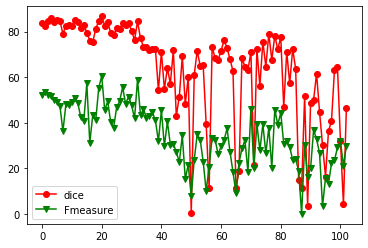

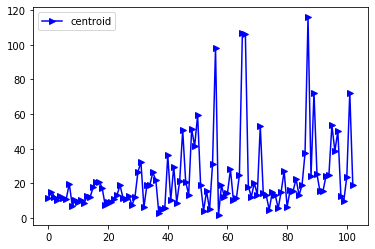

The average value of dice is 63.78013463200534
The average value of Fmeasure is 34.6820838893362
The average value of centroid is 22.71570477339552


In [0]:
plt.plot(range(len(list_DICE)),list_DICE,marker='o',color='r')
plt.plot(range(len(list_boundry)),list_boundry,marker='v',color='g')
plt.legend(['dice', 'Fmeasure'])
plt.show()

plt.plot(range(len(list_centroid)), list_centroid, marker='>', color='b')
plt.legend(['centroid'])
plt.show()

print('The average value of dice is '+ str(np.mean(list_DICE)))
print('The average value of Fmeasure is '+ str(np.mean(list_boundry)))
print('The average value of centroid is '+ str(np.mean(list_centroid)))

## 1.3 Mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


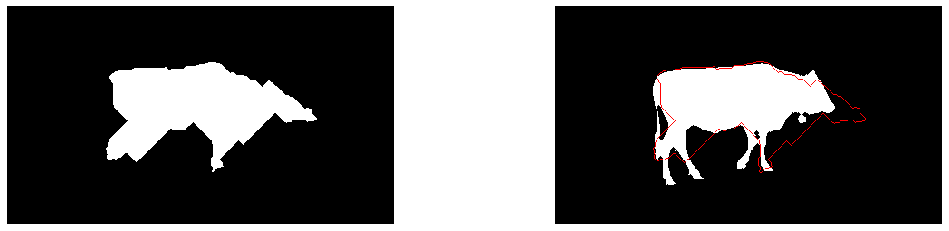

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


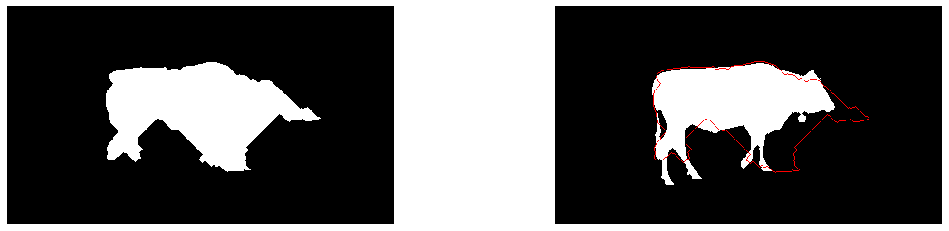

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


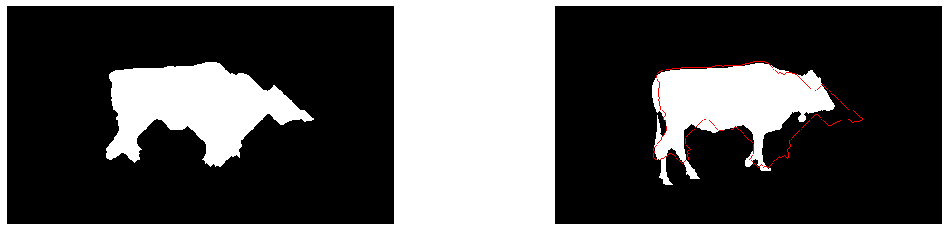

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


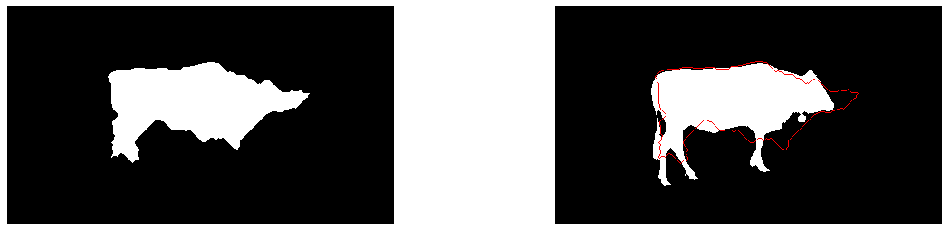

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


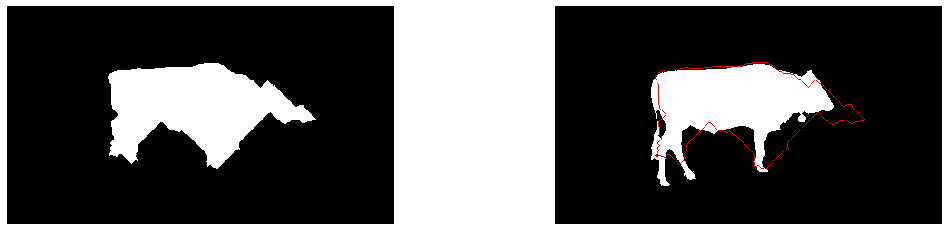

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


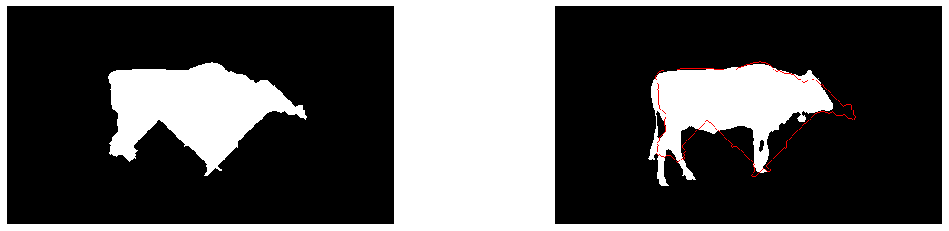

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


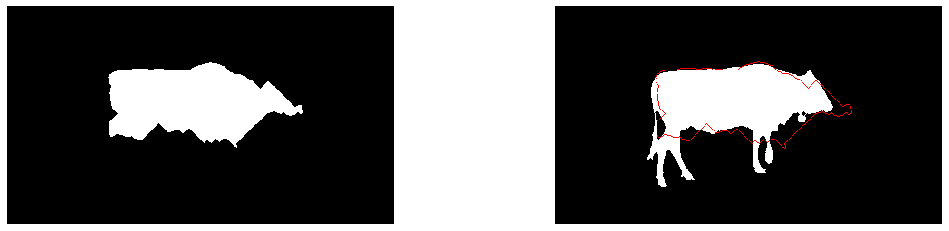

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


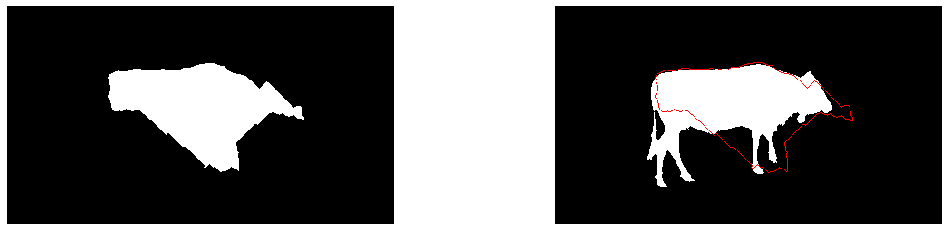

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


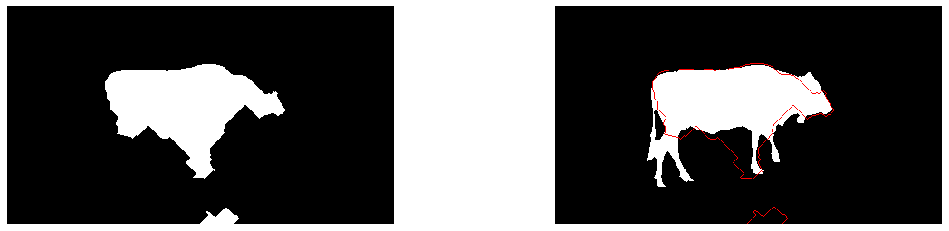

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


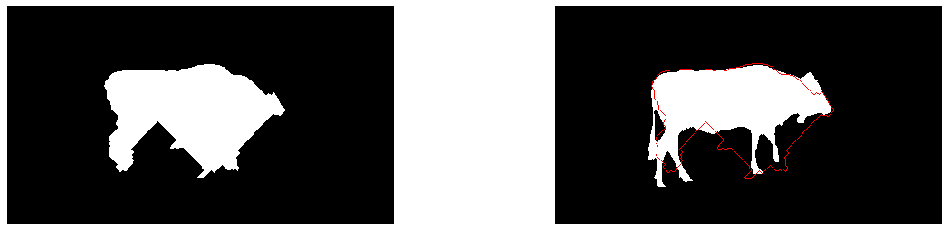

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


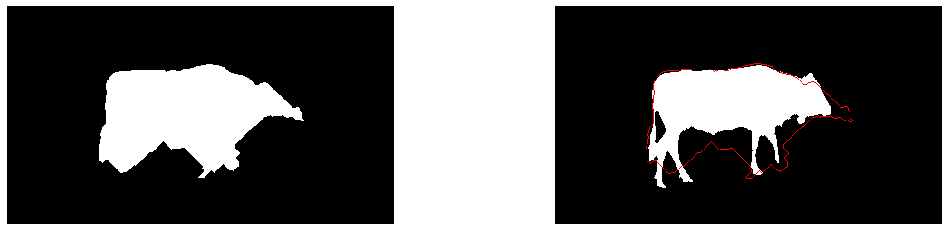

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


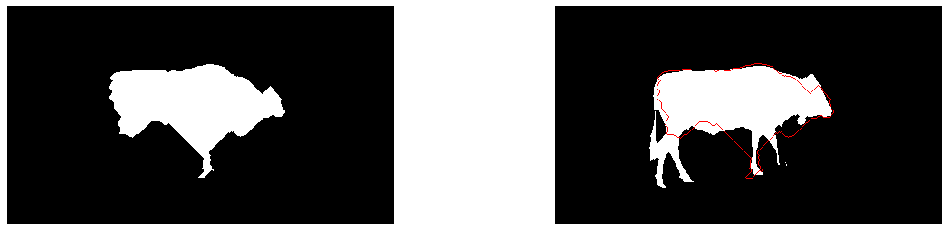

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


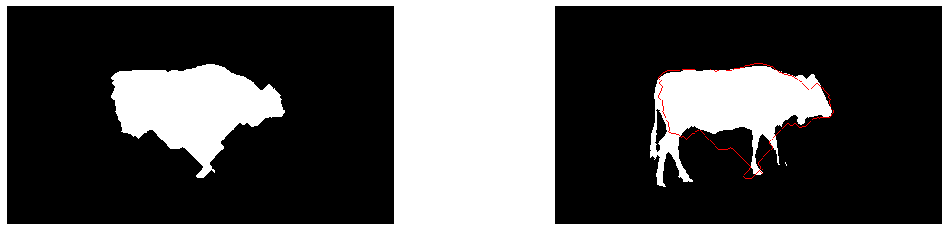

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


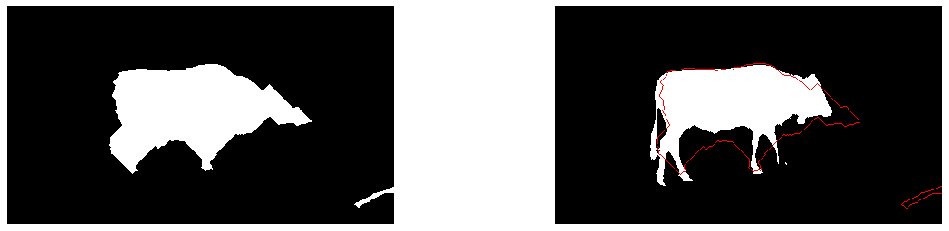

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


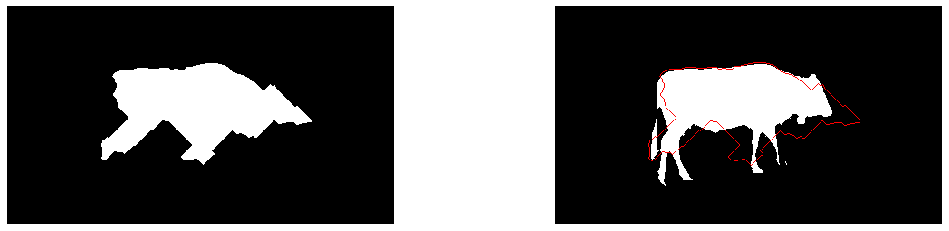

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


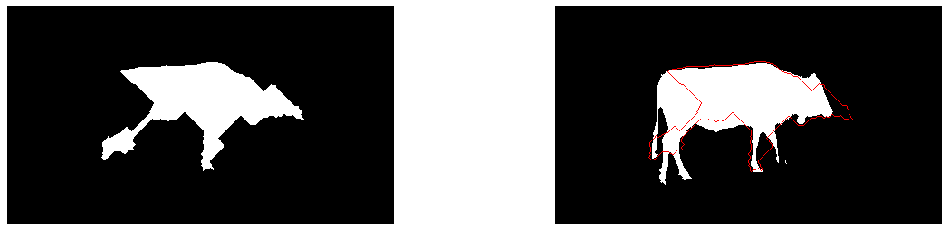

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


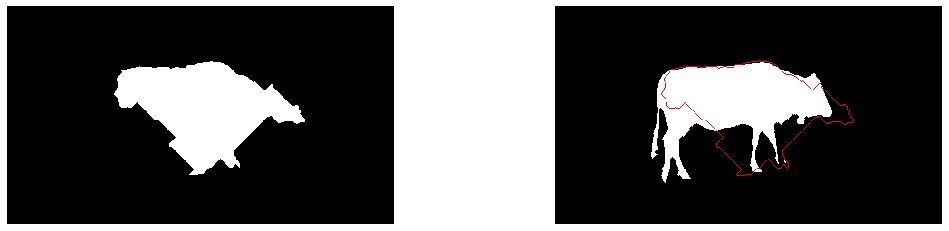

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


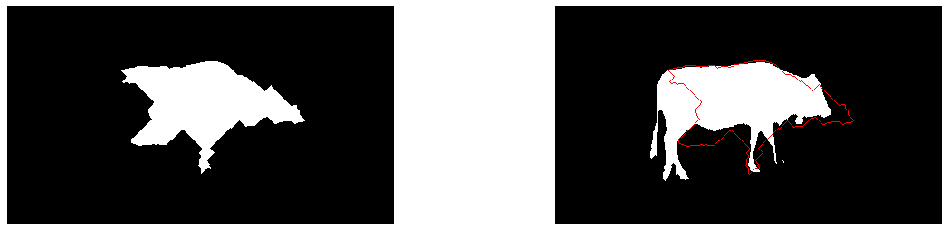

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


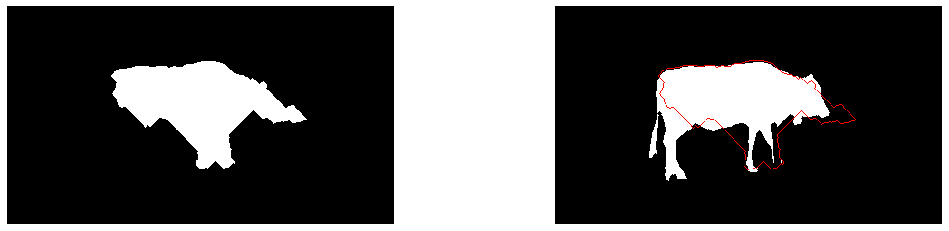

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


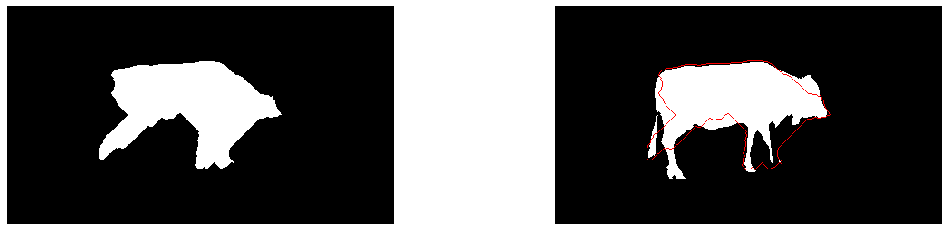

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


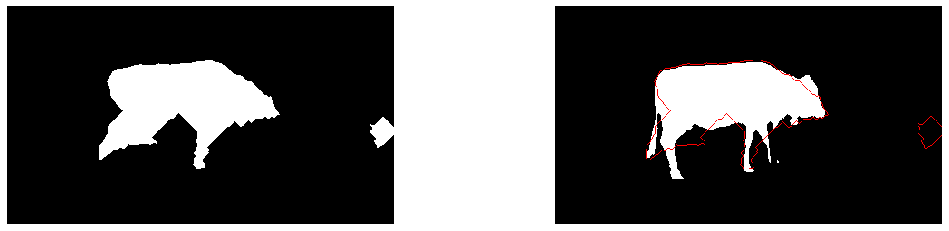

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


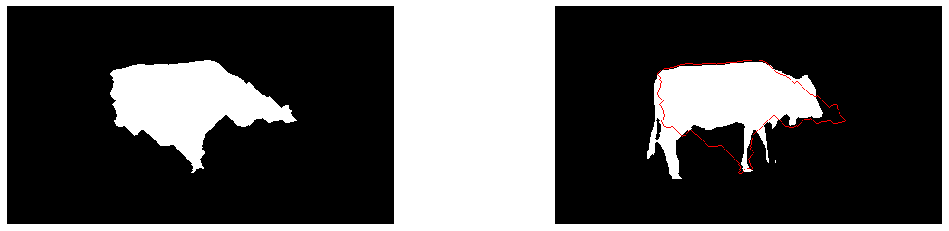

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


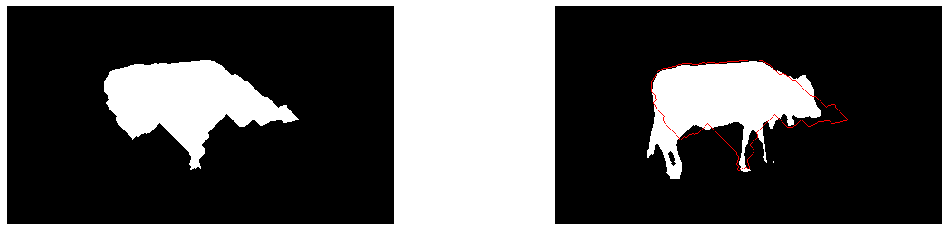

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


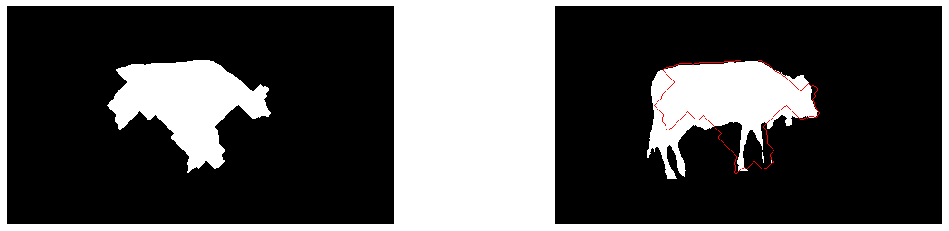

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


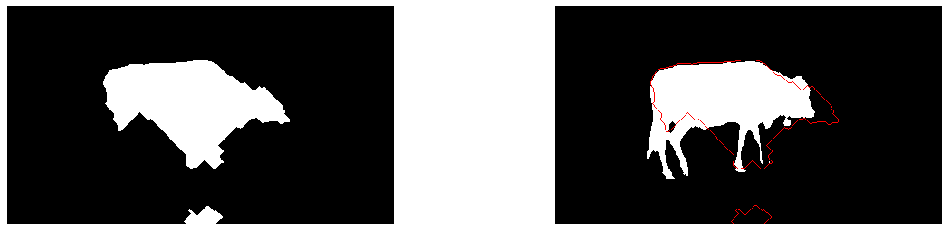

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


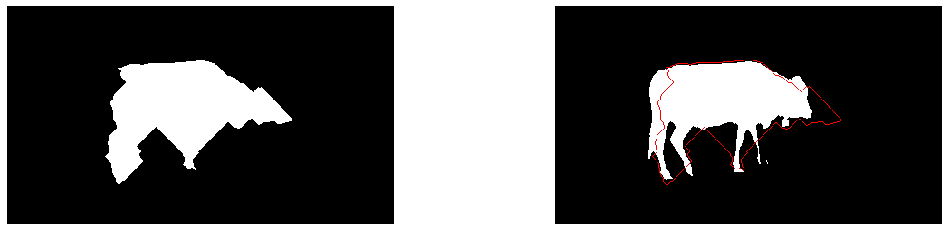

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


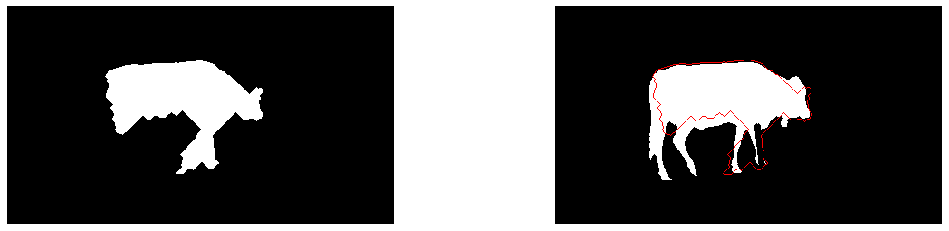

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


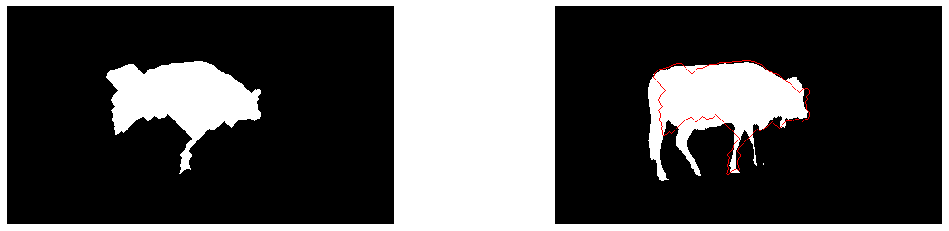

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


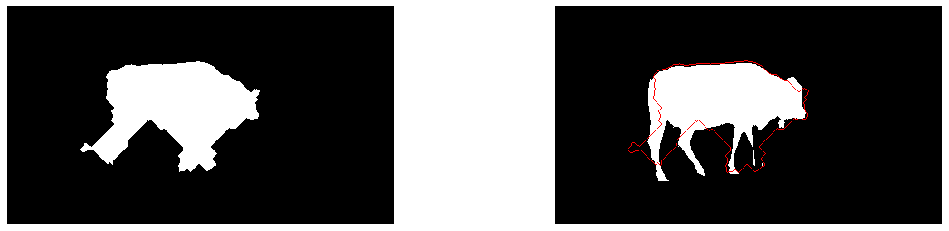

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


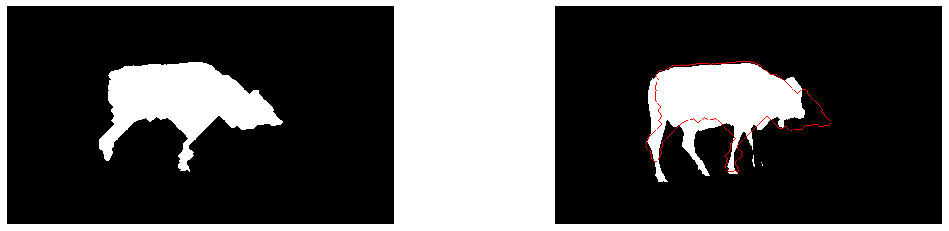

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


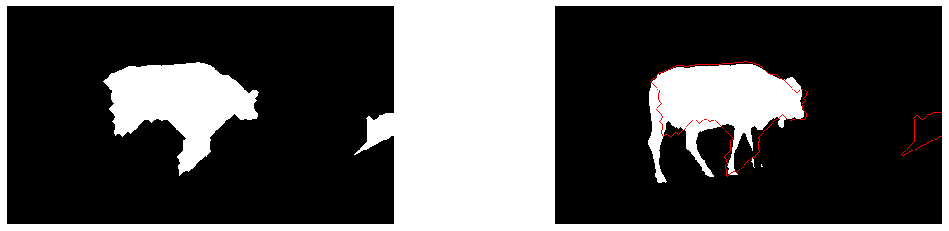

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


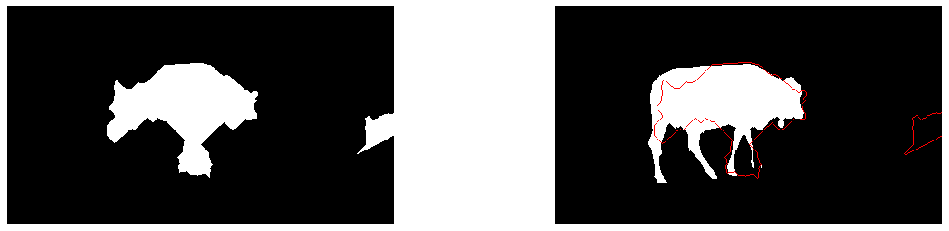

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


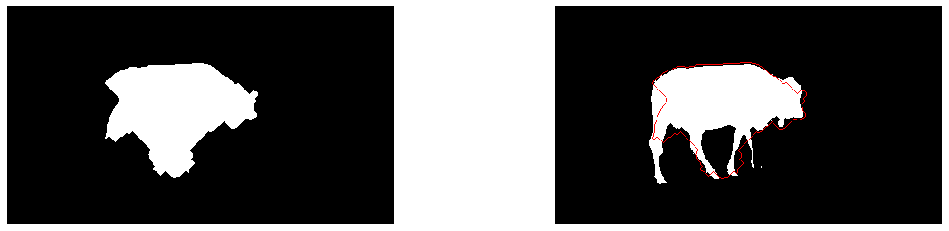

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


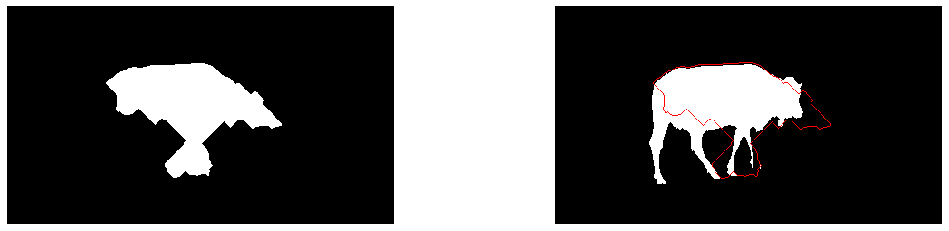

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


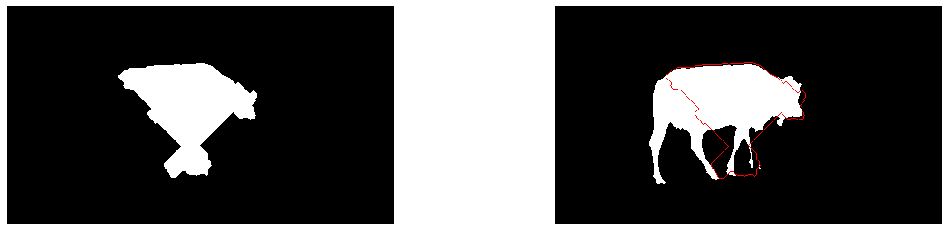

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


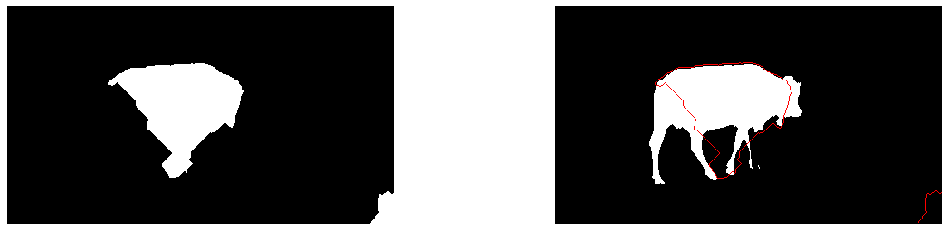

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


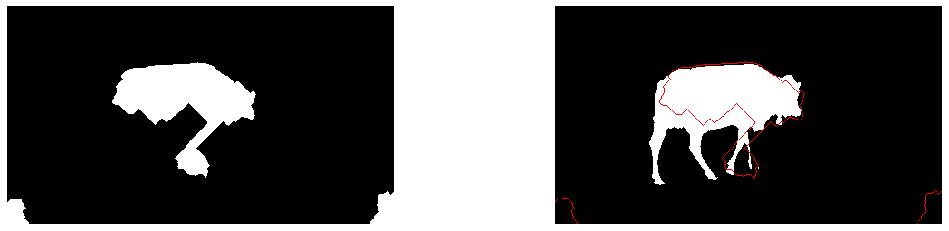

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


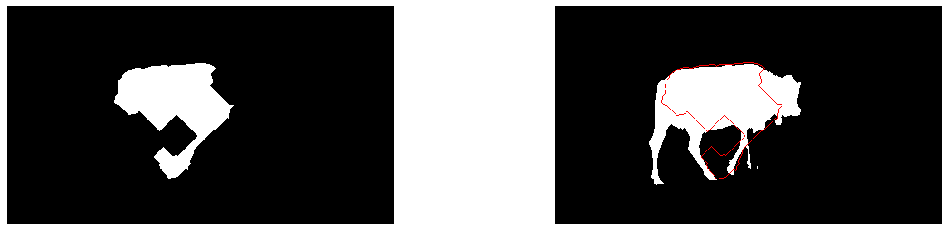

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


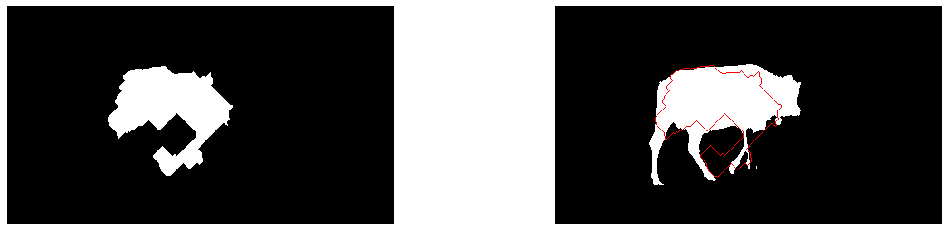

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


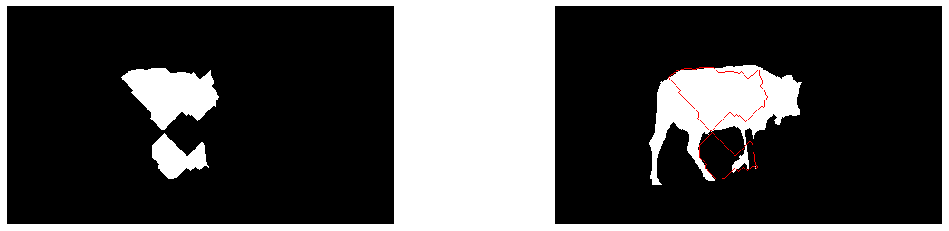

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


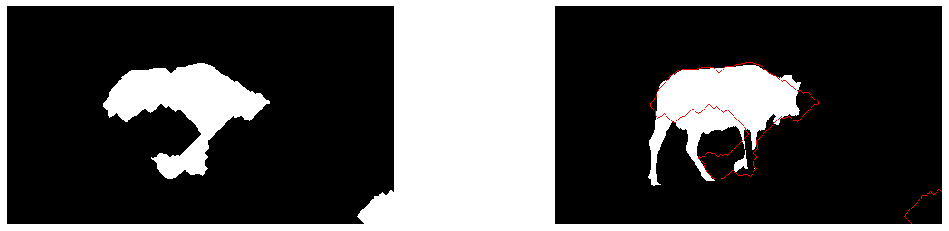

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


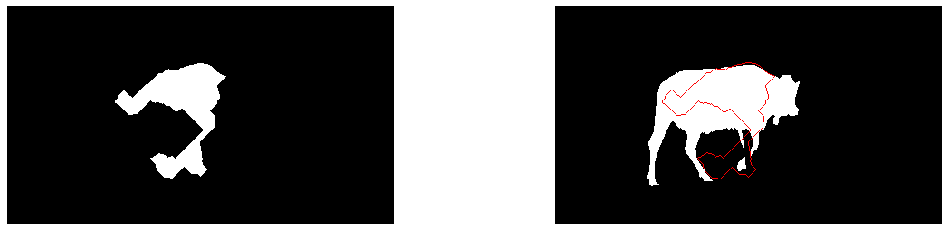

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


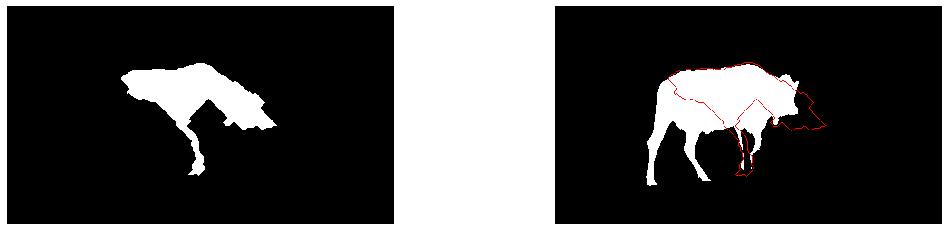

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


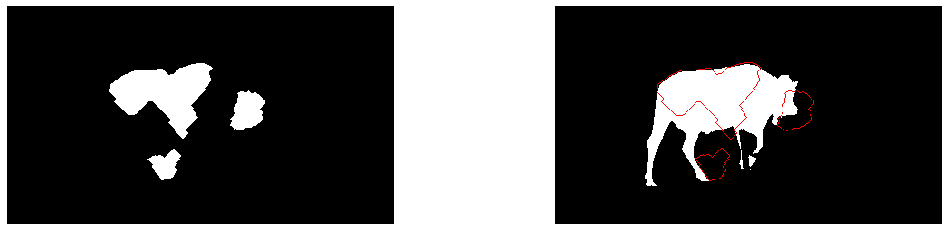

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


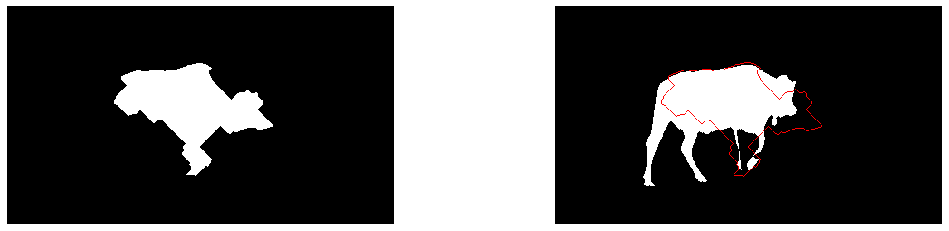

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


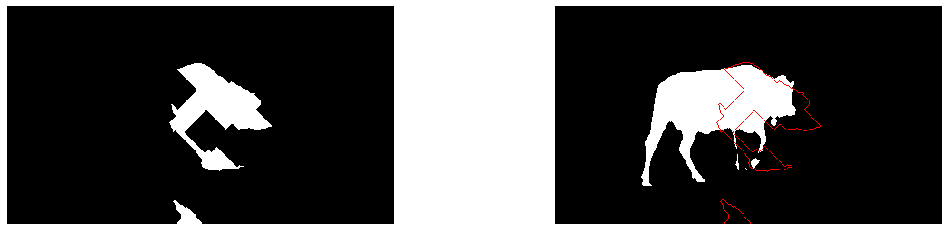

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


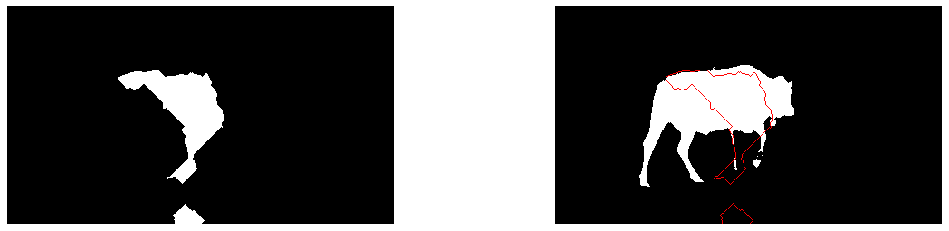

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


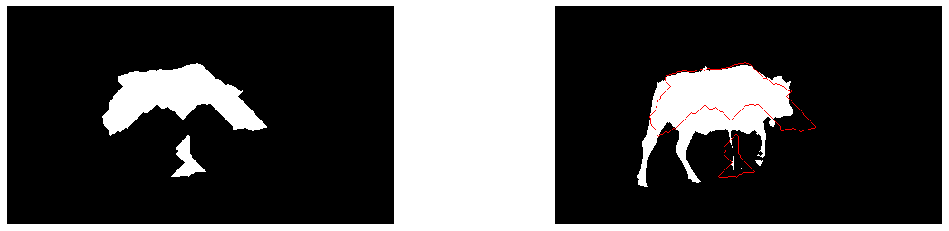

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


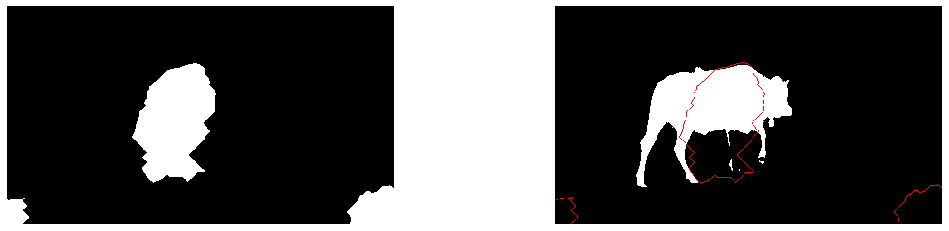

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


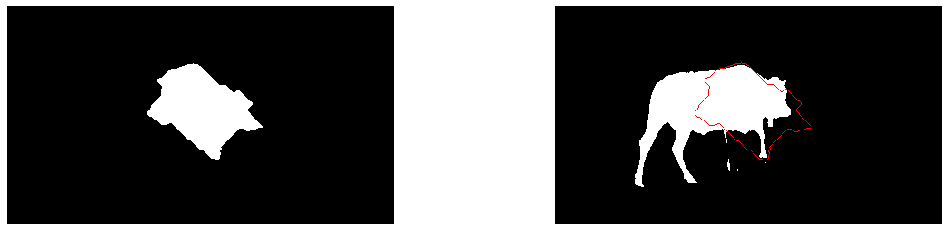

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


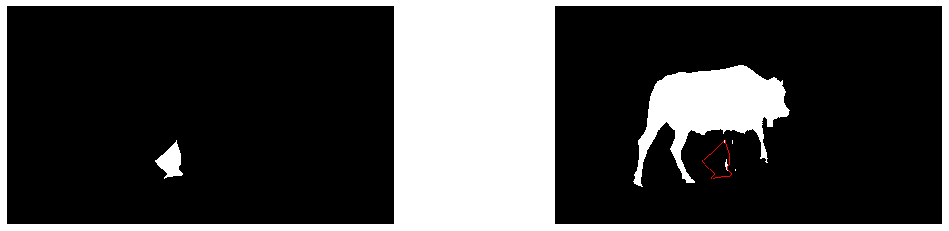

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


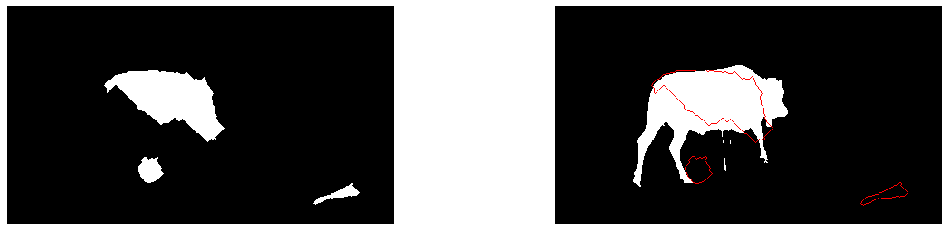

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


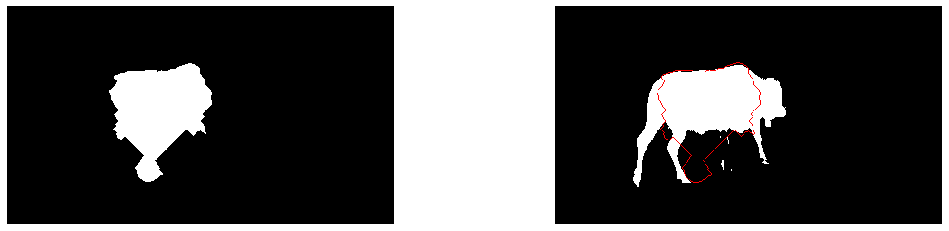

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


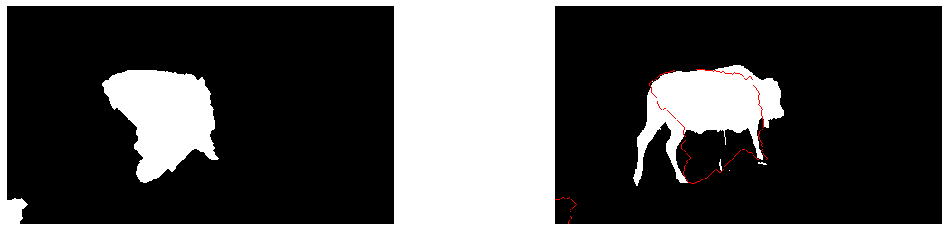

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


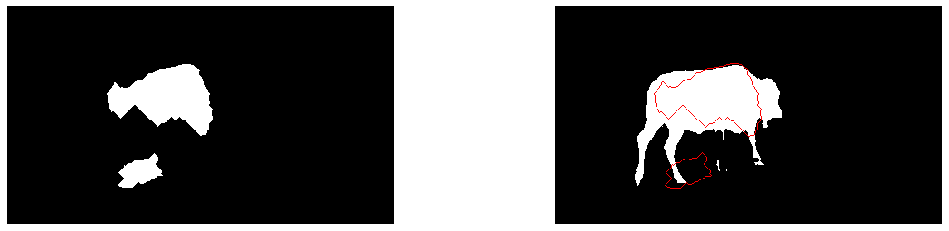

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


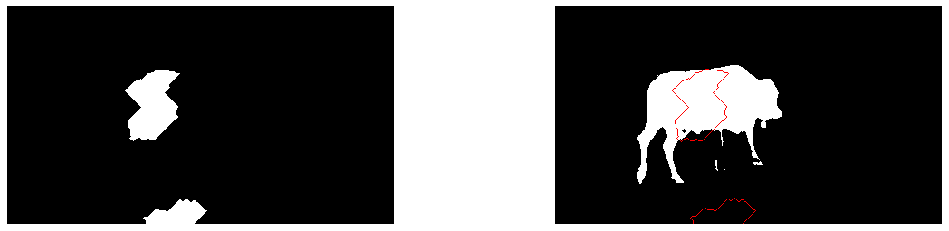

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


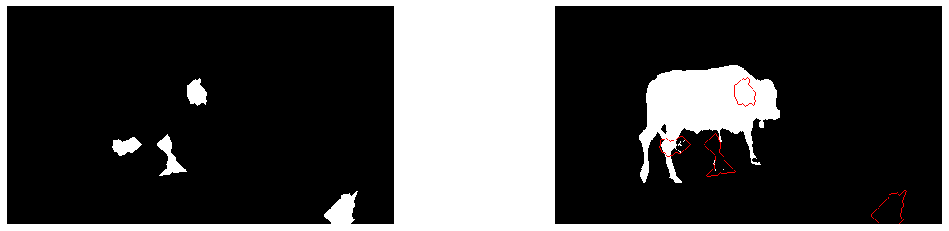

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


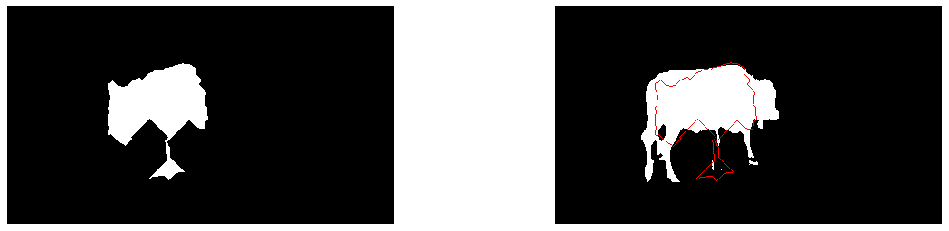

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


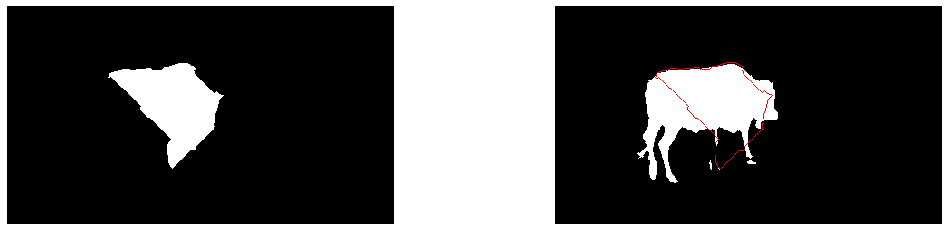

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


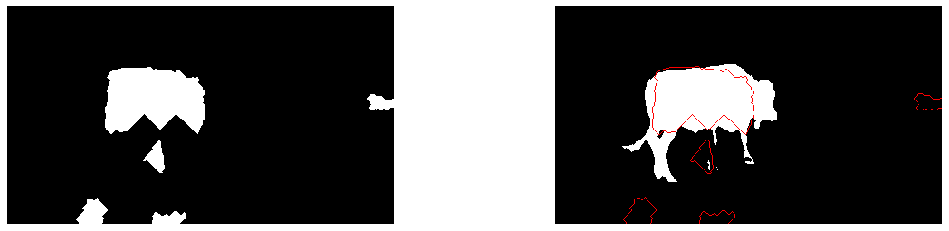

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


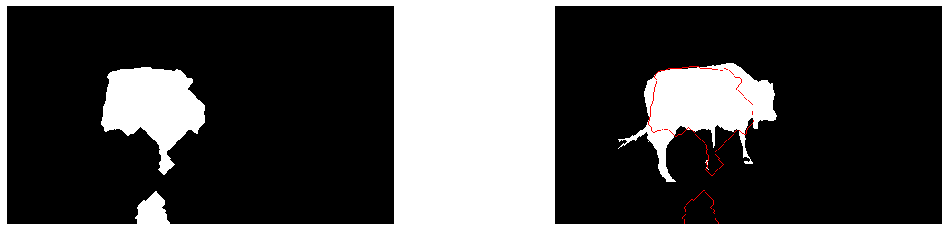

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


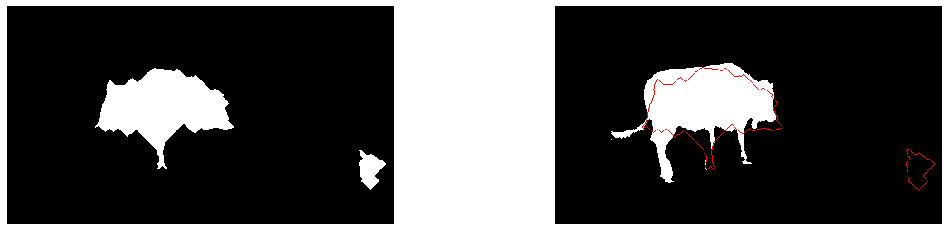

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


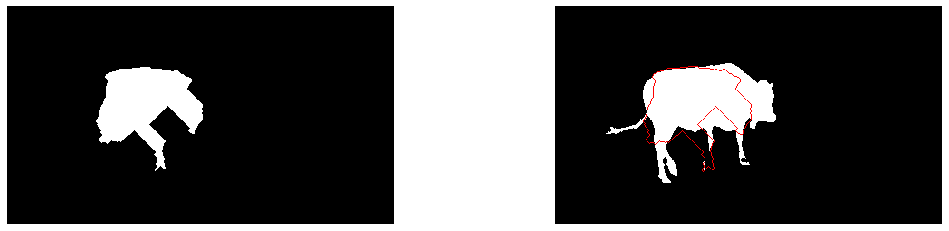

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


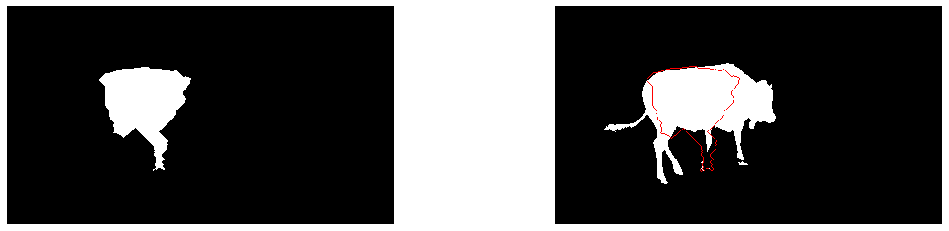

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


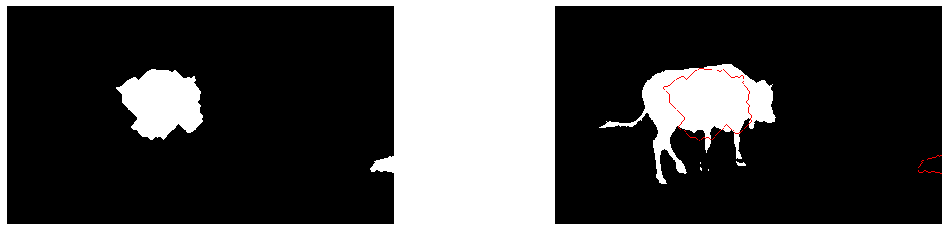

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


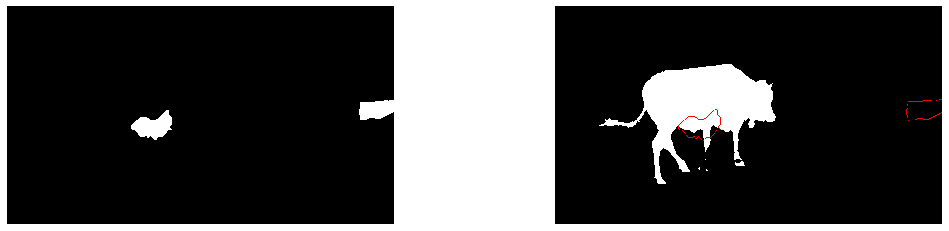

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


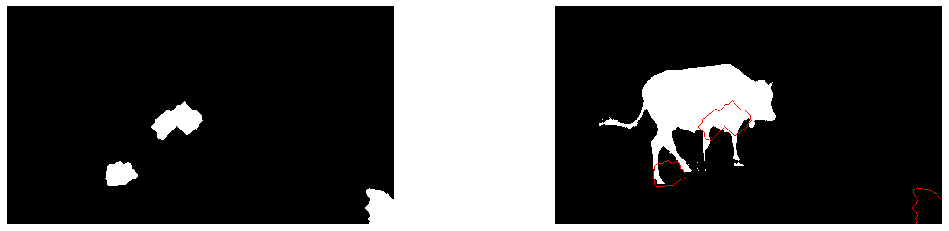

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


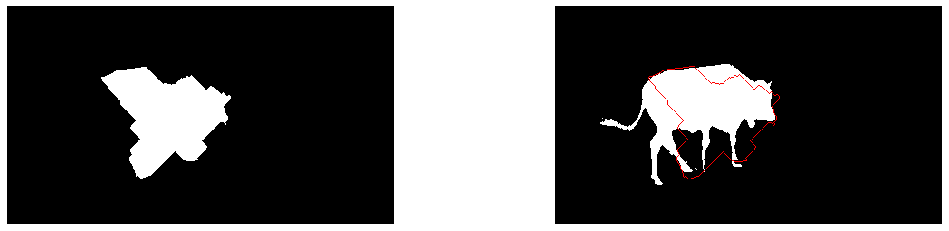

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


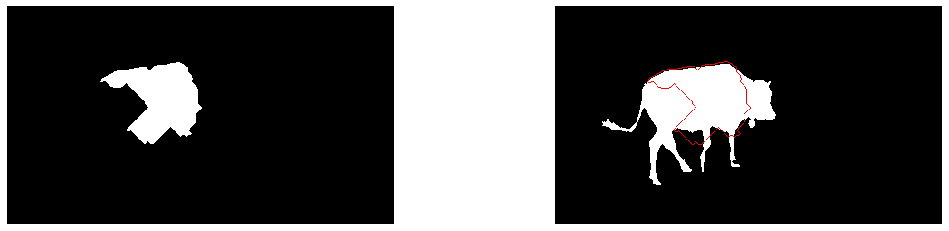

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


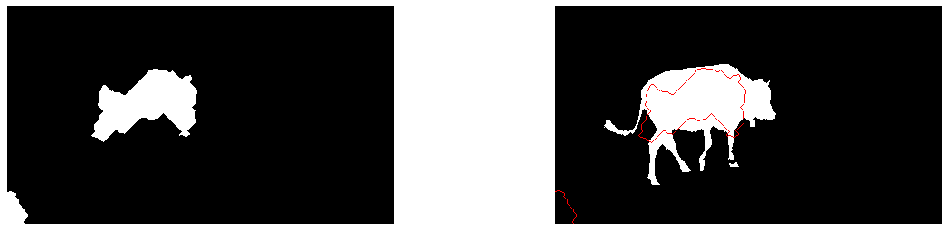

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


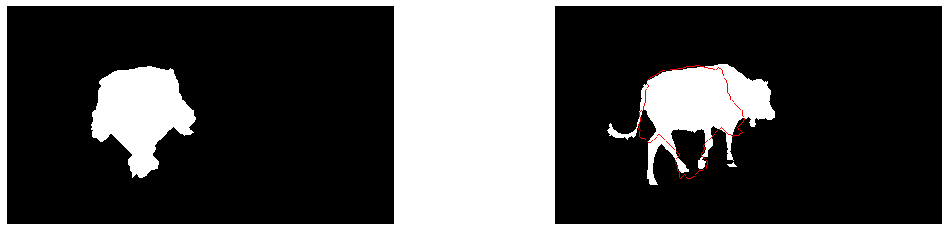

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


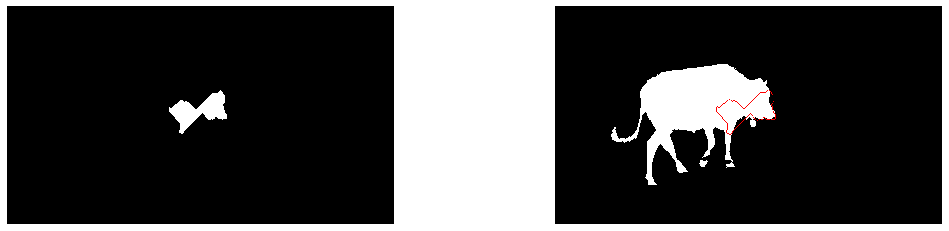

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


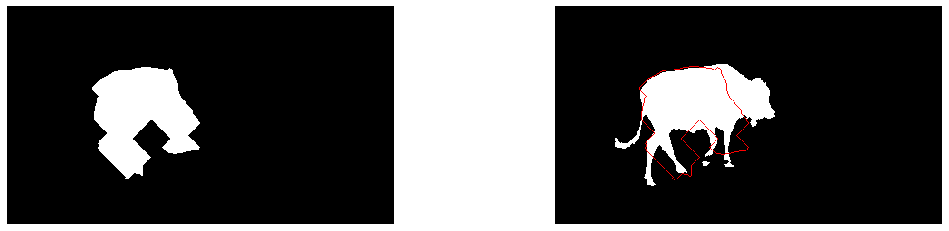

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


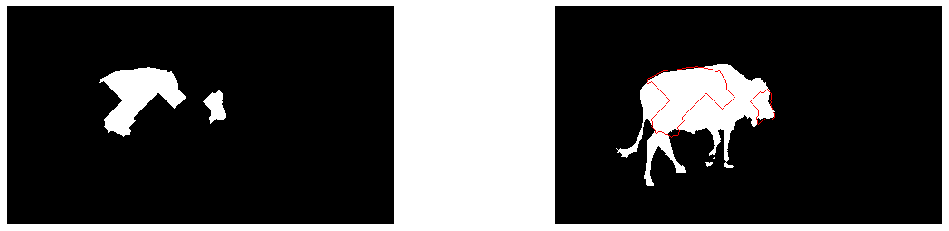

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


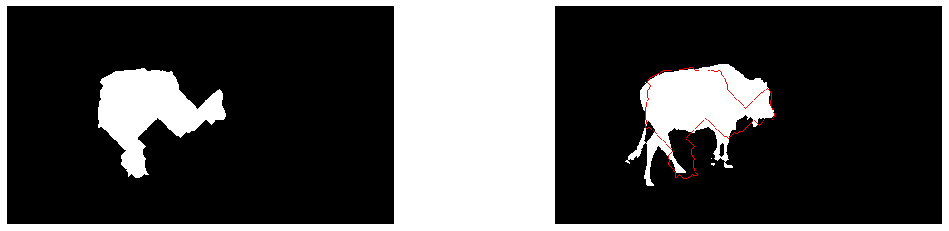

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


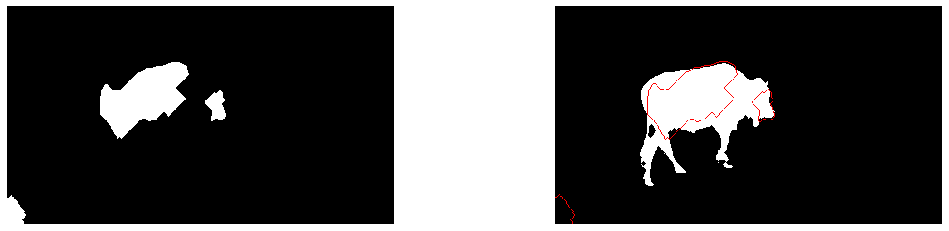

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


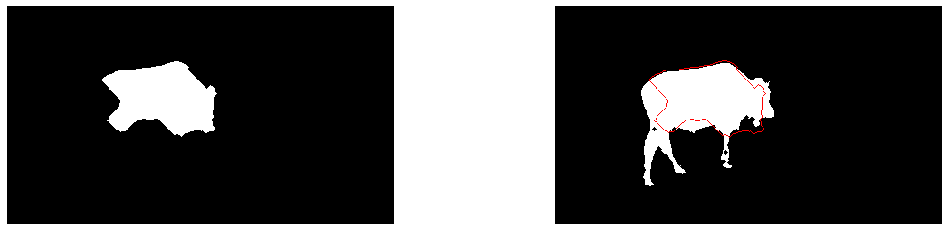

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


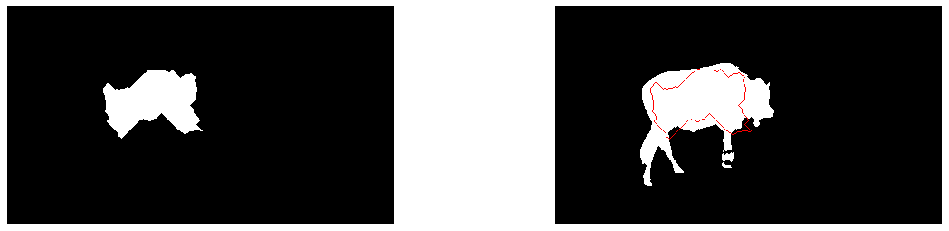

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


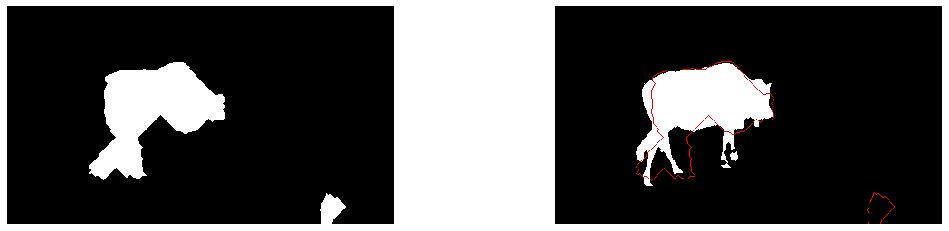

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


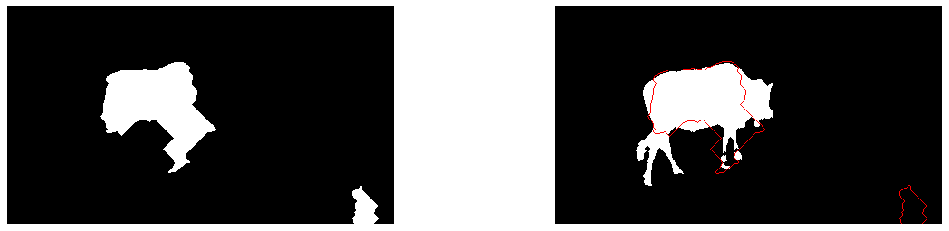

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


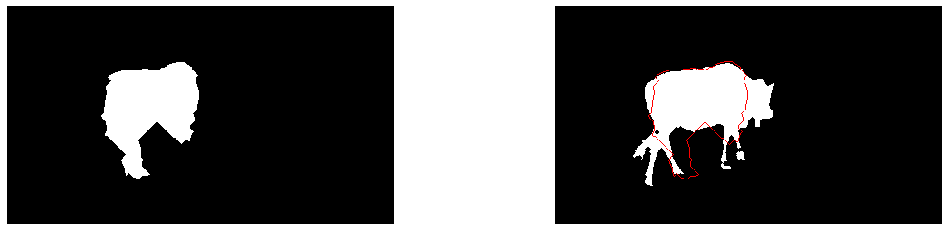

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


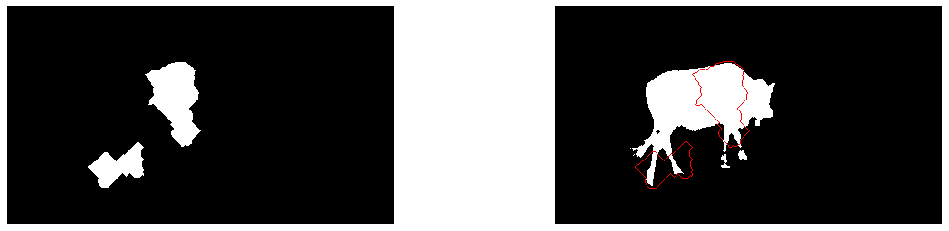

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


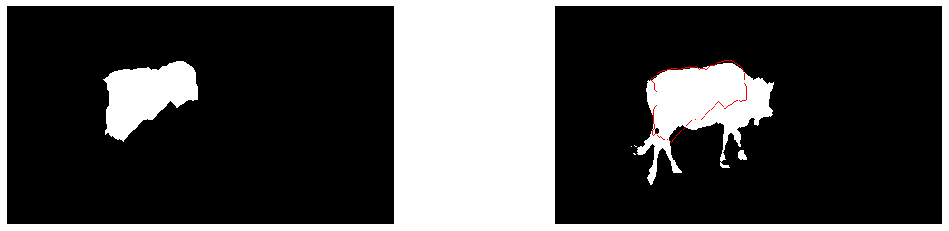

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


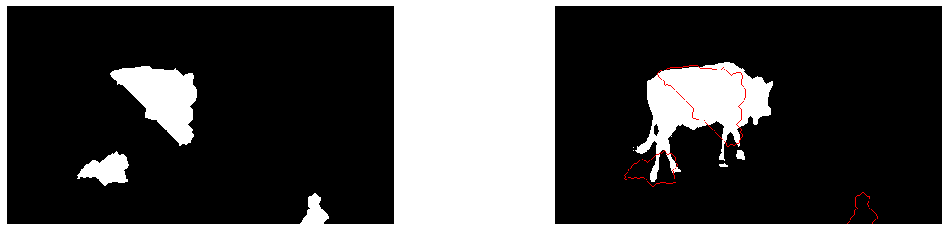

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


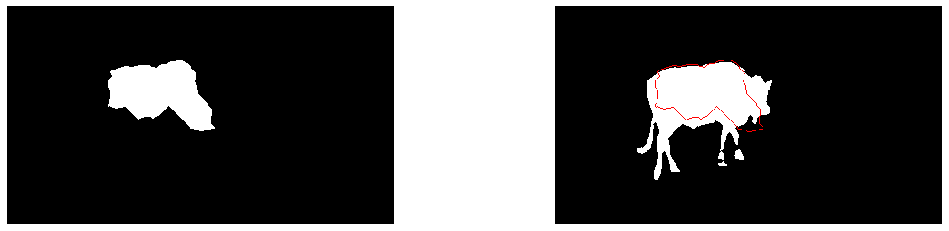

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


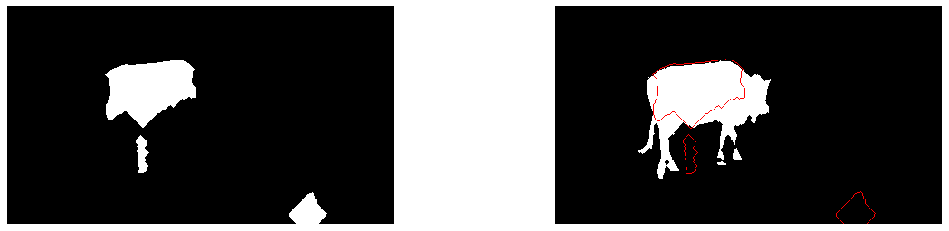

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


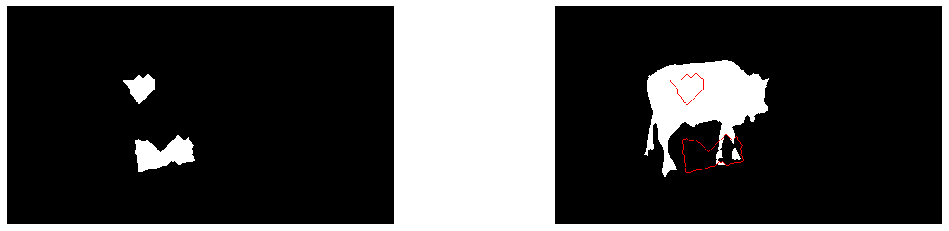

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


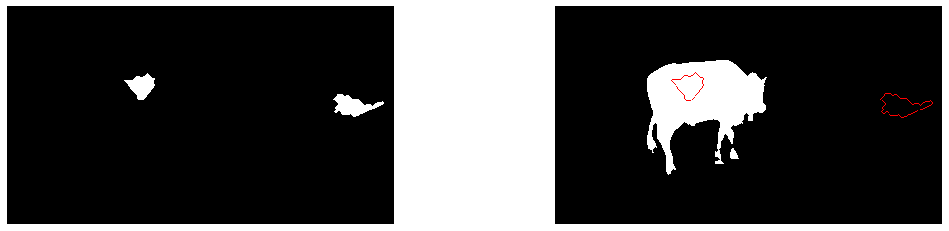

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


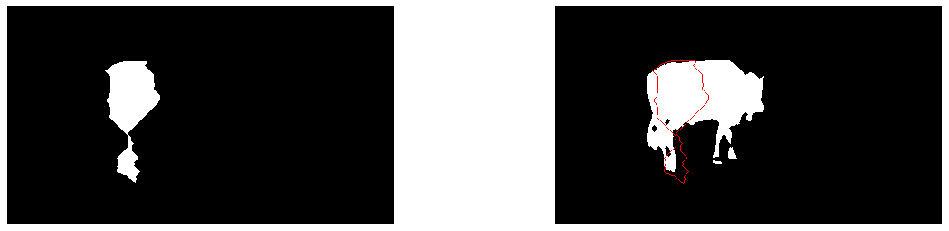

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


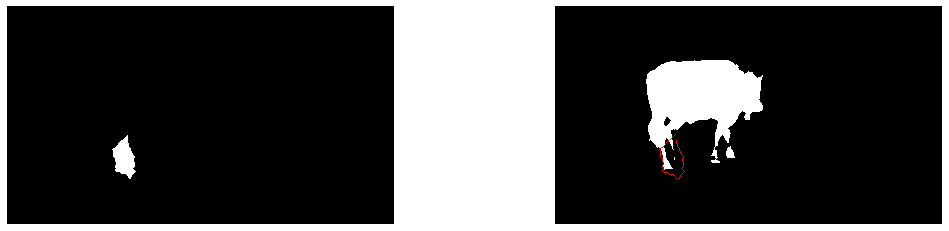

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


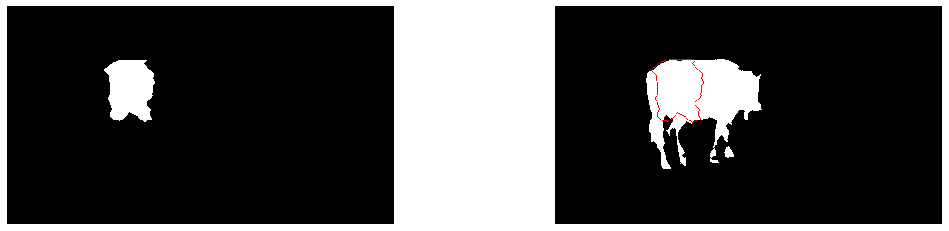

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


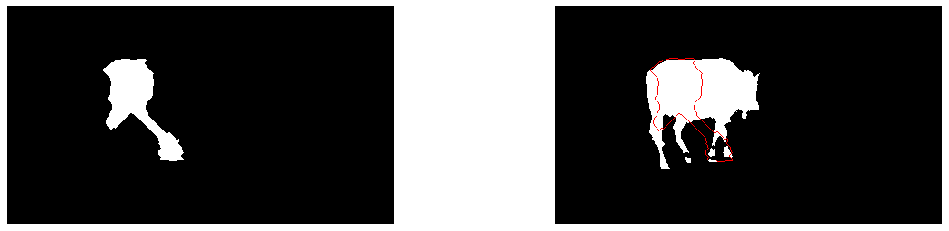

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


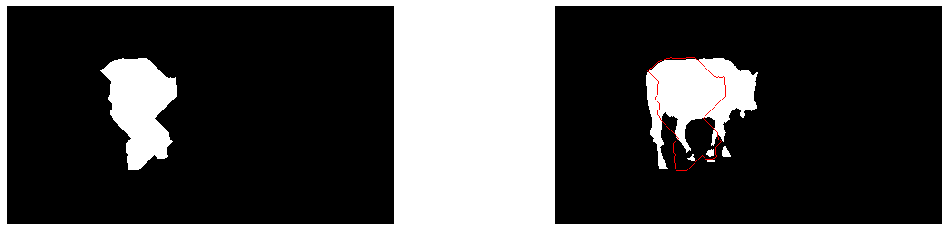

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


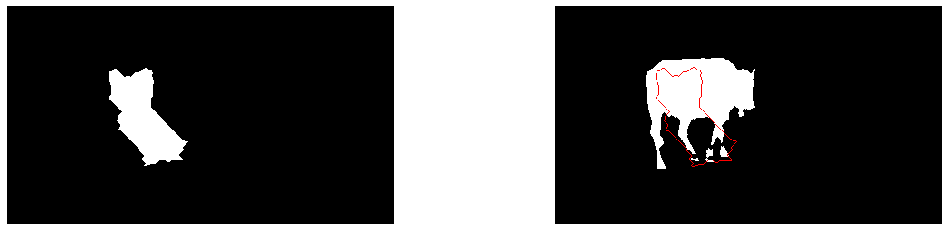

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


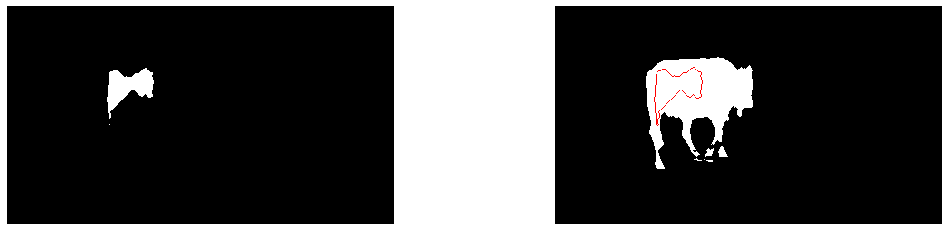

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


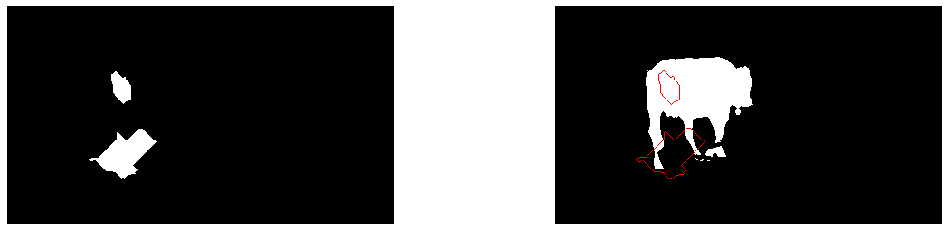

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


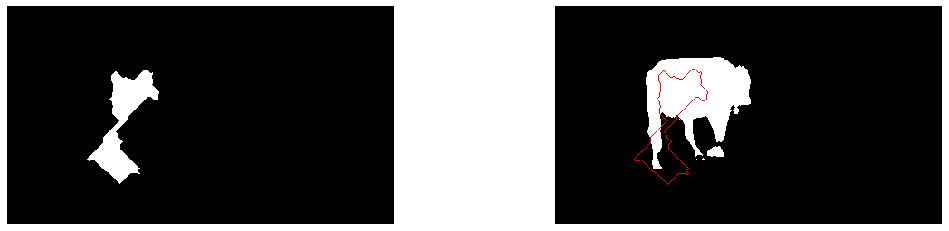

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


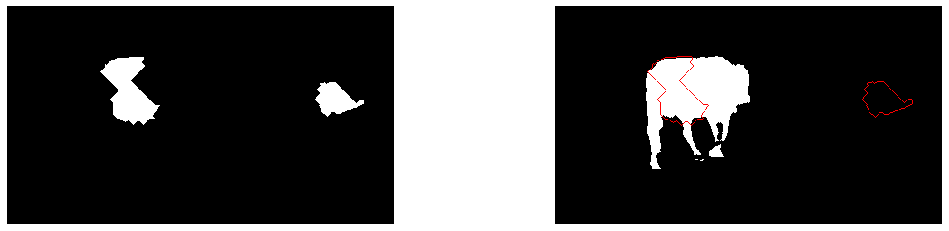

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


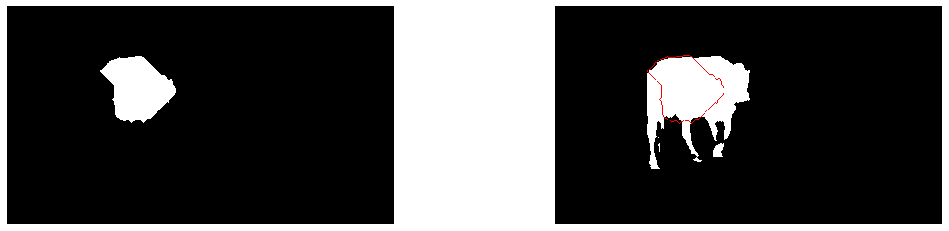

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


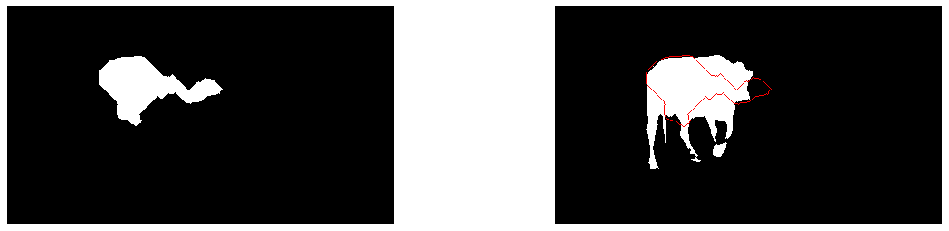

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


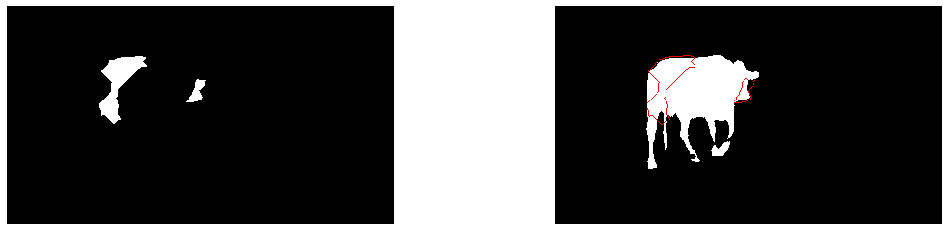

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


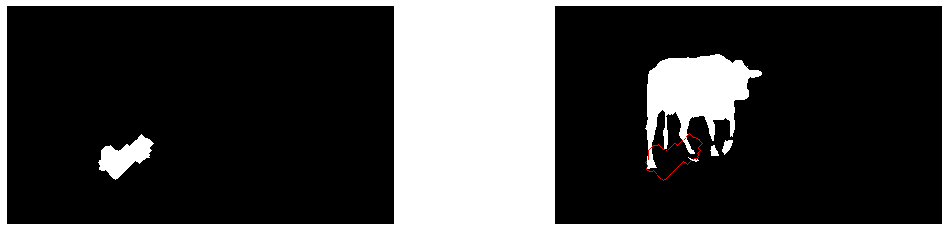

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


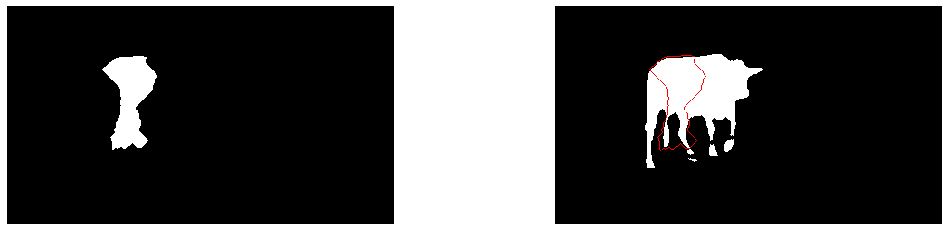

In [0]:
img_begin = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im_begin)).astype(np.float32)/255.
mask_begin = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im_begin))
img_begin = rgb2gray(img_begin)   # pre-processing

best_mask = list_mask



for im in range(im_begin+1,im_end+1):
    img_current = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im)).astype(np.float32)/255.
    mask_current = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im_begin))
    img_current = rgb2gray(img_current) # pre-processing
    
    boundaries = mark_boundaries(img_current, best_mask[im-2]==255, color = (255,0,0))
    
    plt.figure(figsize=(18, 4))
    plt.subplot(121)
    plt.axis('off')
    plt.imshow(best_mask[im-2],cmap='gray')
    plt.subplot(122)
    plt.axis('off')
    plt.imshow(boundaries)
    plt.show()

#  2. FISH sequential integration

In [0]:
name = 'fish'
im_begin = 1
im_end = 26

mask = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,1))
list_mask = [mask]


for im in tqdm(range(im_begin, im_end)):
    B = io.imread('../sequences-test/'+name+'/%0*d.bmp'%(3,im))
    B_mask = list_mask[-1]
    
    A = io.imread('../sequences-test/'+name+'/%0*d.bmp'%(3,im+1))
    mask_A  = reconstructMaskConsecutive_color(A, B, B_mask,10)
    list_mask.append(mask_A)

 17%|█▋        | 1/6 [00:08<00:43,  8.67s/it]

1306.4853615712655



 33%|███▎      | 2/6 [00:14<00:31,  7.89s/it]

1050.5936417092958



 50%|█████     | 3/6 [00:19<00:20,  6.92s/it]

152.63682386632658



 67%|██████▋   | 4/6 [00:23<00:12,  6.12s/it]

0.0



 83%|████████▎ | 5/6 [00:27<00:05,  5.47s/it]

54.0



100%|██████████| 6/6 [00:31<00:00,  5.22s/it]

27.748873851023216



 17%|█▋        | 1/6 [00:08<00:42,  8.55s/it]

1200.341201492309



 33%|███▎      | 2/6 [00:14<00:30,  7.66s/it]

731.9187113334376



 50%|█████     | 3/6 [00:18<00:20,  6.69s/it]

200.43702252827444



 67%|██████▋   | 4/6 [00:22<00:11,  5.88s/it]

146.6219628841464



 83%|████████▎ | 5/6 [00:26<00:05,  5.23s/it]

26.43860813280457



100%|██████████| 6/6 [00:29<00:00,  4.98s/it]

0.0



 17%|█▋        | 1/6 [00:08<00:41,  8.24s/it]

1199.884994489055



 33%|███▎      | 2/6 [00:13<00:29,  7.33s/it]

801.0536810975904



 50%|█████     | 3/6 [00:17<00:19,  6.42s/it]

151.8979920867949



 67%|██████▋   | 4/6 [00:21<00:11,  5.67s/it]

0.0



 83%|████████▎ | 5/6 [00:25<00:05,  5.09s/it]

17.291616465790582



100%|██████████| 6/6 [00:28<00:00,  4.80s/it]

7.0



 17%|█▋        | 1/6 [00:08<00:40,  8.15s/it]

1182.20768057055



 33%|███▎      | 2/6 [00:13<00:29,  7.29s/it]

675.2458811425657



 50%|█████     | 3/6 [00:17<00:19,  6.47s/it]

200.4120754844877



 67%|██████▋   | 4/6 [00:21<00:11,  5.72s/it]

138.17018491700733



 83%|████████▎ | 5/6 [00:25<00:05,  5.11s/it]

0.0



100%|██████████| 6/6 [00:29<00:00,  4.86s/it]

4.123105625617661



 17%|█▋        | 1/6 [00:08<00:42,  8.52s/it]

1153.9137749416116



 33%|███▎      | 2/6 [00:14<00:30,  7.61s/it]

781.6546552026668



 50%|█████     | 3/6 [00:18<00:19,  6.66s/it]

193.14761194485425



 67%|██████▋   | 4/6 [00:22<00:11,  5.80s/it]

13.0



 83%|████████▎ | 5/6 [00:25<00:05,  5.17s/it]

18.0



100%|██████████| 6/6 [00:29<00:00,  4.92s/it]

135.8712625980932



 17%|█▋        | 1/6 [00:08<00:40,  8.15s/it]

1110.6083918285508



 33%|███▎      | 2/6 [00:13<00:28,  7.25s/it]

663.3000829187345



 50%|█████     | 3/6 [00:17<00:19,  6.36s/it]

72.3118247591637



 67%|██████▋   | 4/6 [00:21<00:11,  5.65s/it]

0.0



 83%|████████▎ | 5/6 [00:25<00:05,  5.06s/it]

51.62363799656123



100%|██████████| 6/6 [00:28<00:00,  4.80s/it]

42.0



 17%|█▋        | 1/6 [00:08<00:40,  8.12s/it]

1117.54865665885



 33%|███▎      | 2/6 [00:13<00:28,  7.18s/it]

700.0899942150295



 50%|█████     | 3/6 [00:17<00:18,  6.24s/it]

105.19030373565806



 67%|██████▋   | 4/6 [00:20<00:10,  5.47s/it]

0.0



 83%|████████▎ | 5/6 [00:24<00:04,  4.93s/it]

0.0



100%|██████████| 6/6 [00:27<00:00,  4.65s/it]

90.0



 17%|█▋        | 1/6 [00:08<00:41,  8.32s/it]

1153.1400608772553



 33%|███▎      | 2/6 [00:13<00:29,  7.33s/it]

585.2563540876766



 50%|█████     | 3/6 [00:17<00:19,  6.42s/it]

179.15635629248547



 67%|██████▋   | 4/6 [00:21<00:11,  5.63s/it]

0.0



 83%|████████▎ | 5/6 [00:25<00:05,  5.03s/it]

14.866068747318506



100%|██████████| 6/6 [00:28<00:00,  4.76s/it]

0.0



 17%|█▋        | 1/6 [00:08<00:41,  8.37s/it]

1223.2648936350622



 33%|███▎      | 2/6 [00:13<00:29,  7.48s/it]

918.9439591182914



 50%|█████     | 3/6 [00:18<00:19,  6.54s/it]

236.7720422685077



 67%|██████▋   | 4/6 [00:22<00:11,  5.77s/it]

94.70480452437458



 83%|████████▎ | 5/6 [00:25<00:05,  5.18s/it]

73.79024325749306



100%|██████████| 6/6 [00:29<00:00,  4.92s/it]

7.615773105863909



 17%|█▋        | 1/6 [00:09<00:45,  9.03s/it]

1279.7112955663085



 33%|███▎      | 2/6 [00:15<00:32,  8.15s/it]

922.8521008265626



 50%|█████     | 3/6 [00:19<00:21,  7.13s/it]

211.6719159454083



 67%|██████▋   | 4/6 [00:24<00:12,  6.24s/it]

58.63446085707619



 83%|████████▎ | 5/6 [00:27<00:05,  5.54s/it]

0.0



100%|██████████| 6/6 [00:31<00:00,  5.26s/it]

120.0



 17%|█▋        | 1/6 [00:08<00:40,  8.01s/it]

1174.7846611187942



 33%|███▎      | 2/6 [00:13<00:28,  7.11s/it]

480.06353746144896



 50%|█████     | 3/6 [00:17<00:18,  6.29s/it]

73.89181280764467



 67%|██████▋   | 4/6 [00:21<00:11,  5.62s/it]

23.769728648009426



 83%|████████▎ | 5/6 [00:25<00:05,  5.06s/it]

86.0



100%|██████████| 6/6 [00:28<00:00,  4.80s/it]

53.075418038862395



 17%|█▋        | 1/6 [00:08<00:41,  8.22s/it]

1135.8160062263605



 33%|███▎      | 2/6 [00:13<00:29,  7.32s/it]

709.6400496026137



 50%|█████     | 3/6 [00:17<00:19,  6.39s/it]

231.8232085016511



 67%|██████▋   | 4/6 [00:21<00:11,  5.67s/it]

43.0



 83%|████████▎ | 5/6 [00:25<00:05,  5.17s/it]

0.0



100%|██████████| 6/6 [00:29<00:00,  4.86s/it]

68.0



 17%|█▋        | 1/6 [00:08<00:40,  8.07s/it]

1150.791032290398



 33%|███▎      | 2/6 [00:13<00:28,  7.23s/it]

737.8631309396072



 50%|█████     | 3/6 [00:17<00:19,  6.35s/it]

27.65863337187866



 67%|██████▋   | 4/6 [00:21<00:11,  5.60s/it]

38.118237105091836



 83%|████████▎ | 5/6 [00:25<00:05,  5.03s/it]

38.0



100%|██████████| 6/6 [00:28<00:00,  4.79s/it]

0.0



 17%|█▋        | 1/6 [00:08<00:42,  8.59s/it]

1052.3397740273813



 33%|███▎      | 2/6 [00:14<00:30,  7.71s/it]

959.7207927308858



 50%|█████     | 3/6 [00:18<00:20,  6.76s/it]

282.1364917907643



 67%|██████▋   | 4/6 [00:22<00:11,  5.94s/it]

0.0



 83%|████████▎ | 5/6 [00:26<00:05,  5.26s/it]

32.802438933713454



100%|██████████| 6/6 [00:30<00:00,  5.00s/it]

0.0



 17%|█▋        | 1/6 [00:08<00:42,  8.43s/it]

1158.8481350030297



 33%|███▎      | 2/6 [00:13<00:30,  7.52s/it]

781.8689148444258



 50%|█████     | 3/6 [00:18<00:19,  6.55s/it]

292.5132475632514



 67%|██████▋   | 4/6 [00:22<00:11,  5.79s/it]

0.0



 83%|████████▎ | 5/6 [00:25<00:05,  5.20s/it]

57.0



100%|██████████| 6/6 [00:29<00:00,  4.93s/it]

11.0



 17%|█▋        | 1/6 [00:08<00:41,  8.32s/it]

1153.991767734935



 33%|███▎      | 2/6 [00:13<00:30,  7.50s/it]

643.8276166801172



 50%|█████     | 3/6 [00:18<00:19,  6.59s/it]

253.91534022189364



 67%|██████▋   | 4/6 [00:22<00:11,  5.83s/it]

42.883563284783136



 83%|████████▎ | 5/6 [00:26<00:05,  5.21s/it]

42.532340636273474



100%|██████████| 6/6 [00:29<00:00,  4.95s/it]

81.8413098624405



 17%|█▋        | 1/6 [00:07<00:38,  7.62s/it]

1050.5365295885717



 33%|███▎      | 2/6 [00:12<00:27,  6.81s/it]

1002.5038653292066



 50%|█████     | 3/6 [00:16<00:17,  5.96s/it]

250.7309314783479



 67%|██████▋   | 4/6 [00:20<00:10,  5.22s/it]

21.0



 83%|████████▎ | 5/6 [00:23<00:04,  4.63s/it]

42.95346318982906



100%|██████████| 6/6 [00:26<00:00,  4.38s/it]

1.0



 17%|█▋        | 1/6 [00:07<00:37,  7.53s/it]

1160.853134552343



 33%|███▎      | 2/6 [00:12<00:27,  6.75s/it]

832.9039560477546



 50%|█████     | 3/6 [00:16<00:17,  5.93s/it]

183.6926781338875



 67%|██████▋   | 4/6 [00:20<00:10,  5.22s/it]

47.47630988187688



 83%|████████▎ | 5/6 [00:23<00:04,  4.64s/it]

37.0



100%|██████████| 6/6 [00:26<00:00,  4.42s/it]

11.704699910719626



 17%|█▋        | 1/6 [00:08<00:43,  8.73s/it]

1058.3496586667377



 33%|███▎      | 2/6 [00:14<00:31,  7.91s/it]

992.8287868509857



 50%|█████     | 3/6 [00:19<00:20,  6.87s/it]

212.77452855076427



 67%|██████▋   | 4/6 [00:23<00:11,  5.99s/it]

93.55746896961247



 83%|████████▎ | 5/6 [00:26<00:05,  5.23s/it]

15.748015748023622



100%|██████████| 6/6 [00:29<00:00,  4.99s/it]

0.0



 17%|█▋        | 1/6 [00:08<00:42,  8.41s/it]

1222.3375147642323



 33%|███▎      | 2/6 [00:13<00:30,  7.55s/it]

987.1752630612256



 50%|█████     | 3/6 [00:18<00:19,  6.58s/it]

210.28314245321712



 67%|██████▋   | 4/6 [00:22<00:11,  5.74s/it]

0.0



 83%|████████▎ | 5/6 [00:25<00:05,  5.13s/it]

81.49233092751734



100%|██████████| 6/6 [00:29<00:00,  4.88s/it]

32.802438933713454



 17%|█▋        | 1/6 [00:08<00:40,  8.15s/it]

1190.675858493822



 33%|███▎      | 2/6 [00:13<00:28,  7.22s/it]

737.5032203319522



 50%|█████     | 3/6 [00:17<00:19,  6.37s/it]

155.97756248896826



 67%|██████▋   | 4/6 [00:21<00:11,  5.63s/it]

44.384682042344295



 83%|████████▎ | 5/6 [00:25<00:05,  5.02s/it]

0.0



100%|██████████| 6/6 [00:28<00:00,  4.79s/it]

5.0



 17%|█▋        | 1/6 [00:09<00:45,  9.16s/it]

1170.2721905608114



 33%|███▎      | 2/6 [00:15<00:33,  8.26s/it]

1061.8177809775084



 50%|█████     | 3/6 [00:20<00:21,  7.19s/it]

260.19415827416265



 67%|██████▋   | 4/6 [00:24<00:12,  6.23s/it]

79.00632886041473



 83%|████████▎ | 5/6 [00:27<00:05,  5.49s/it]

0.0



100%|██████████| 6/6 [00:31<00:00,  5.24s/it]

0.0



 17%|█▋        | 1/6 [00:08<00:43,  8.79s/it]

1185.475853824109



 33%|███▎      | 2/6 [00:14<00:31,  7.89s/it]

885.0728783552233



 50%|█████     | 3/6 [00:18<00:20,  6.84s/it]

222.84075031286355



 67%|██████▋   | 4/6 [00:22<00:11,  5.97s/it]

119.8874472161285



 83%|████████▎ | 5/6 [00:26<00:05,  5.28s/it]

29.546573405388315



100%|██████████| 6/6 [00:30<00:00,  5.02s/it]

111.72287142747452



 17%|█▋        | 1/6 [00:08<00:42,  8.48s/it]

1086.0989825978108



 33%|███▎      | 2/6 [00:14<00:30,  7.61s/it]

996.3874748309515



 50%|█████     | 3/6 [00:18<00:19,  6.66s/it]

181.52961190946232



 67%|██████▋   | 4/6 [00:22<00:11,  5.83s/it]

8.0



 83%|████████▎ | 5/6 [00:26<00:05,  5.20s/it]

0.0



100%|██████████| 6/6 [00:29<00:00,  4.95s/it]

32.0



 17%|█▋        | 1/6 [00:08<00:42,  8.41s/it]

1112.4517967085135



 33%|███▎      | 2/6 [00:13<00:30,  7.53s/it]

796.0119345838981



 50%|█████     | 3/6 [00:18<00:19,  6.52s/it]

234.699808265793



 67%|██████▋   | 4/6 [00:22<00:11,  5.77s/it]

32.0



 83%|████████▎ | 5/6 [00:25<00:05,  5.17s/it]

104.0096149401583



100%|██████████| 6/6 [00:29<00:00,  4.92s/it]

3.0



100%|██████████| 25/25 [35:04<00:00, 84.18s/it]


## 2.2 Evaluation 

100%|██████████| 25/25 [00:00<00:00, 620.96it/s]


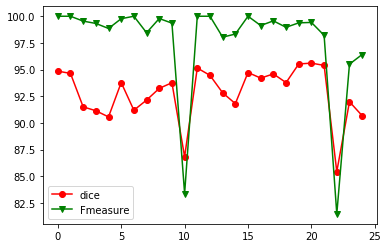

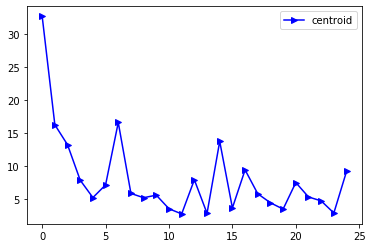

The average value of dice is 92.79344751769244
The average value of Fmeasure is 97.71659128341642
The average value of centroid is 8.074089349356164


In [0]:
list_groundTruth = []
for im in tqdm(range(im_begin+1, im_end+1)):
    ground_truth = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im))
    list_groundTruth.append(ground_truth)
    
list_DICE = []
list_boundry = []
list_centroid = []

for (mask,ground_truth) in zip(list_mask, list_groundTruth):
    list_DICE.append(DICE_assessment(ground_truth, mask))
    list_boundry.append(db_eval_boundary(mask>100,ground_truth>100,bound_th=0.008))
    list_centroid.append(centroid_assessment(ground_truth.astype(int), mask.astype(int)))
plt.plot(range(len(list_DICE)),list_DICE,marker='o',color='r')
plt.plot(range(len(list_boundry)),list_boundry,marker='v',color='g')
plt.legend(['dice', 'Fmeasure'])
plt.show()

plt.plot(range(len(list_centroid)), list_centroid, marker='>', color='b')
plt.legend(['centroid'])
plt.show()

print('The average value of dice is '+ str(np.mean(list_DICE)))
print('The average value of Fmeasure is '+ str(np.mean(list_boundry)))
print('The average value of centroid is '+ str(np.mean(list_centroid)))

## 2.3 Mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


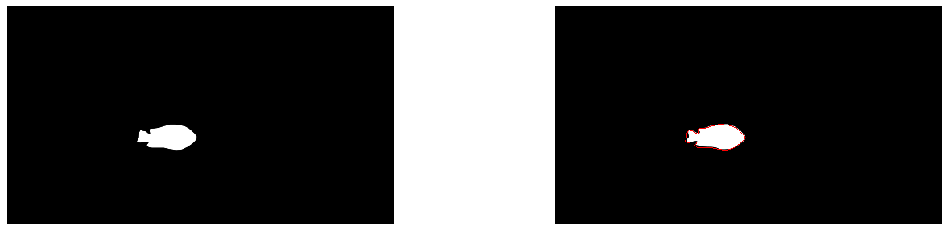

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


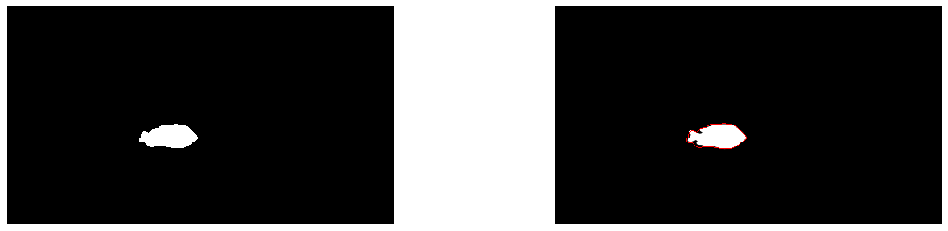

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


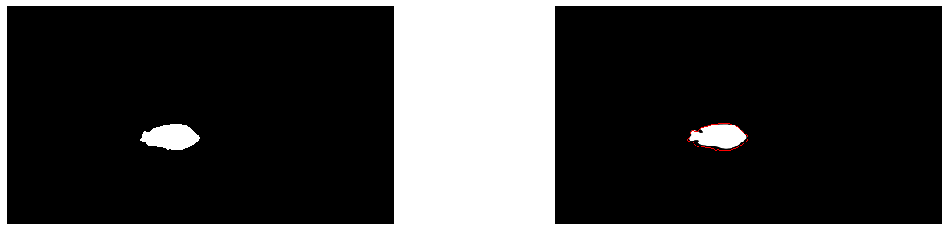

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


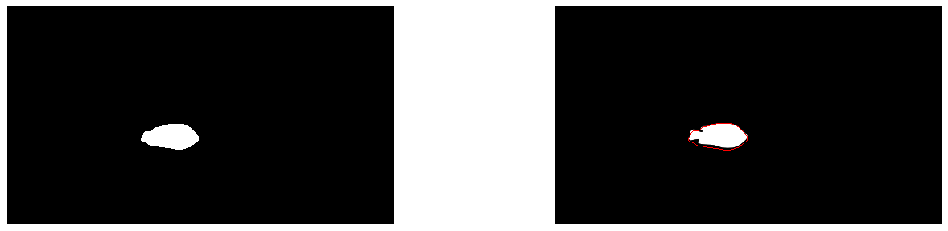

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


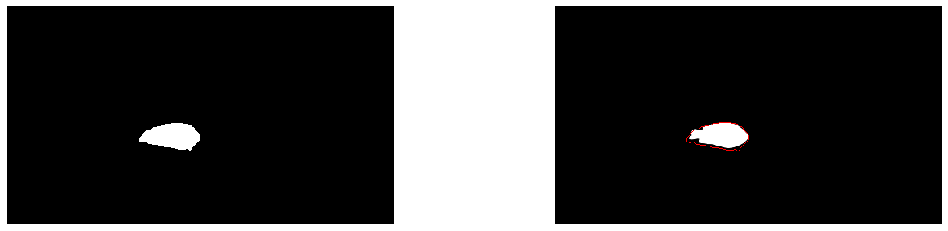

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


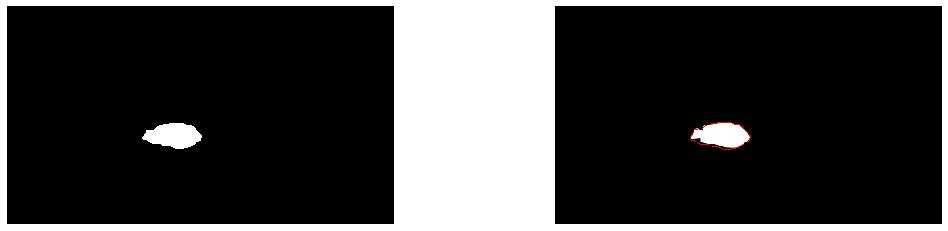

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


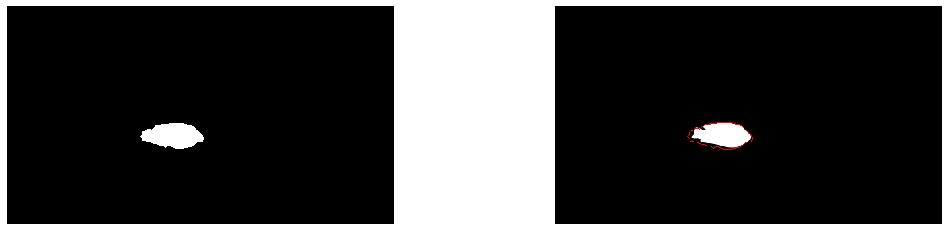

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


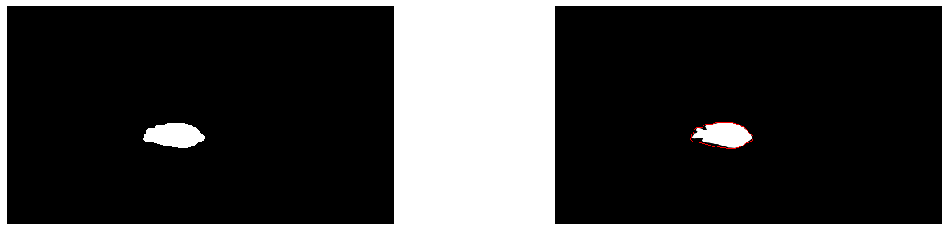

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


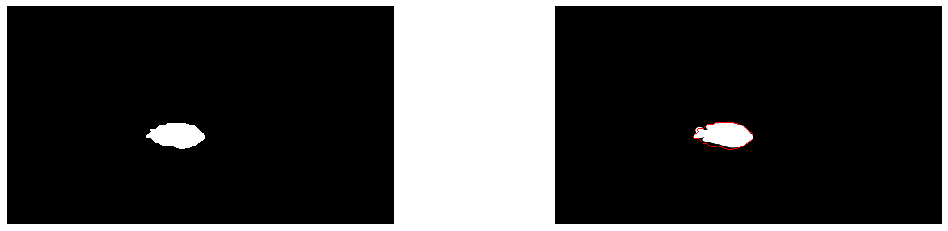

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


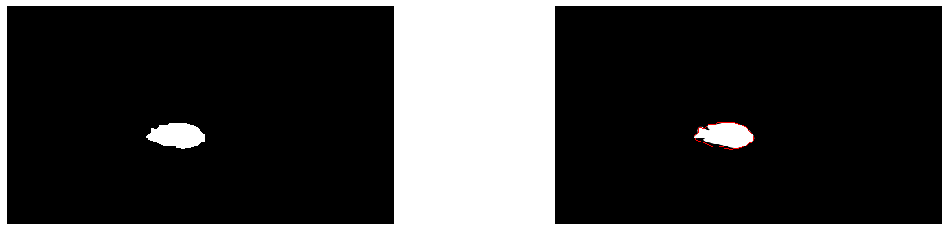

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


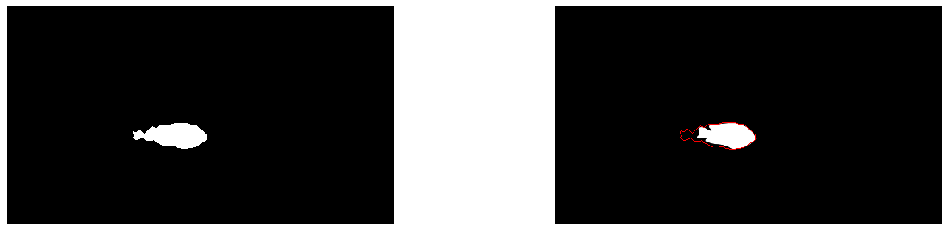

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


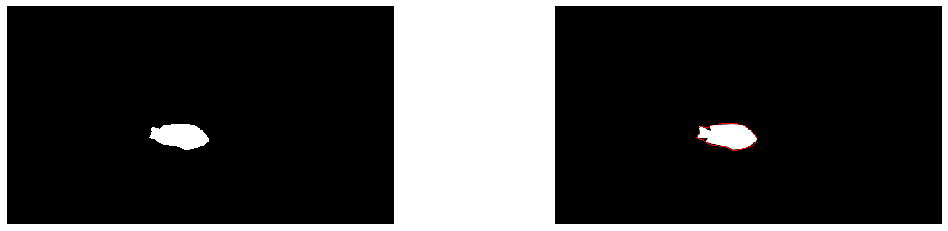

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


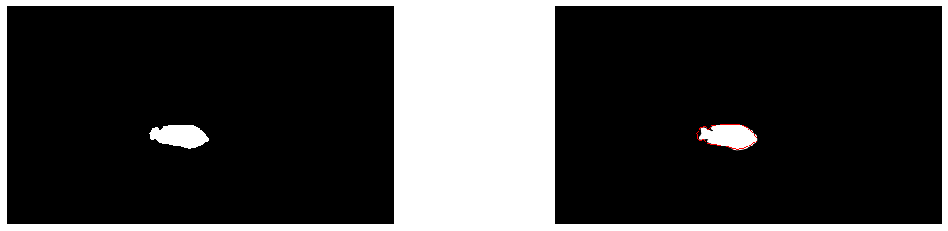

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


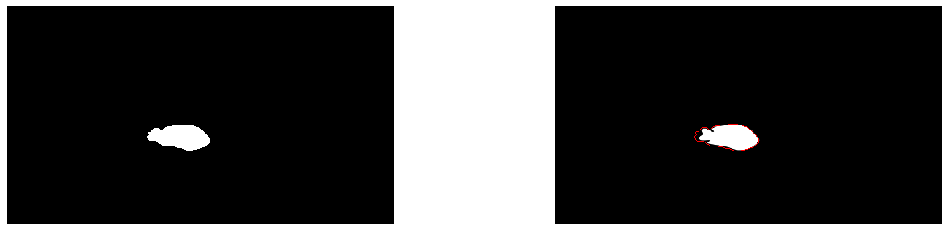

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


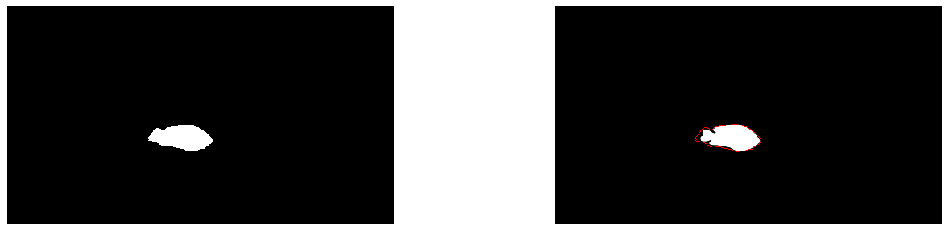

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


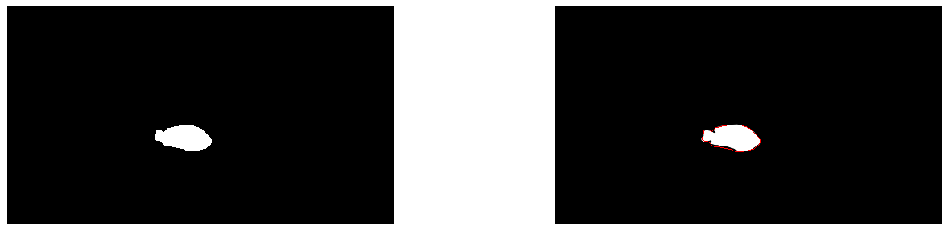

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


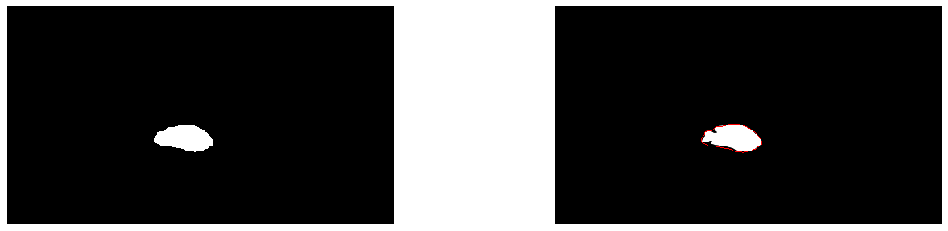

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


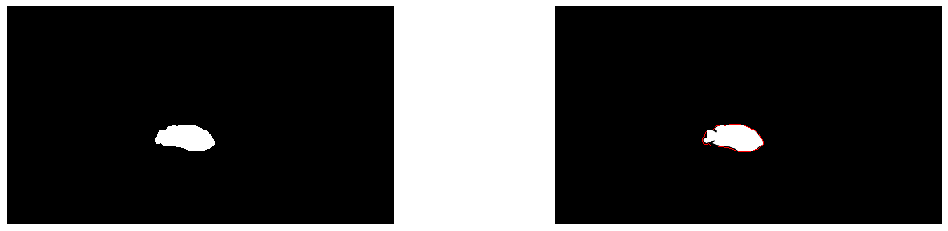

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


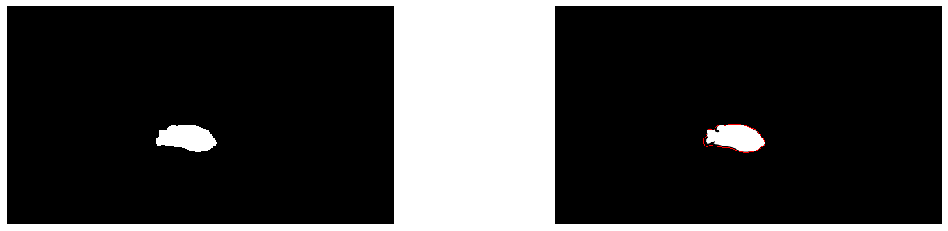

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


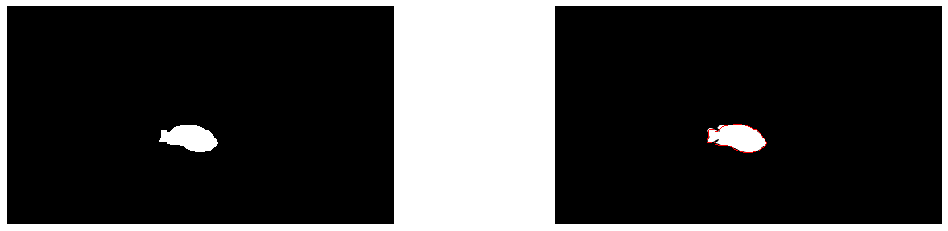

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


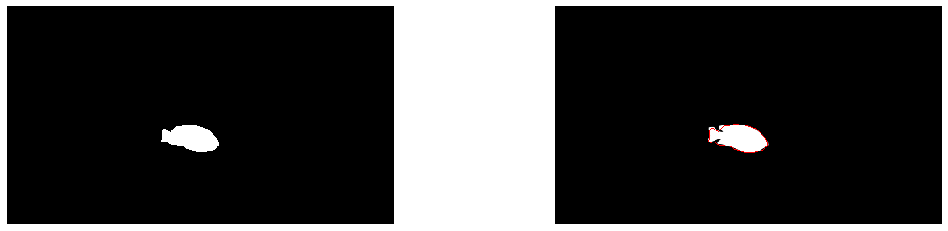

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


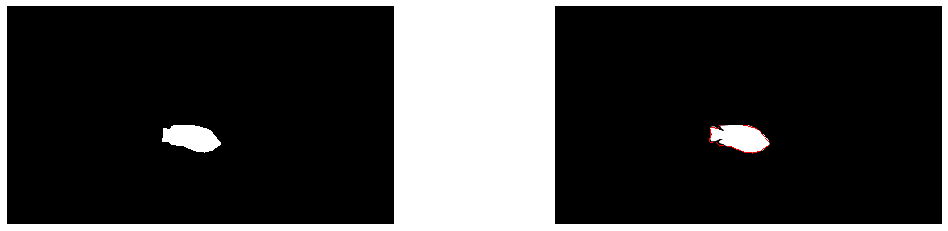

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


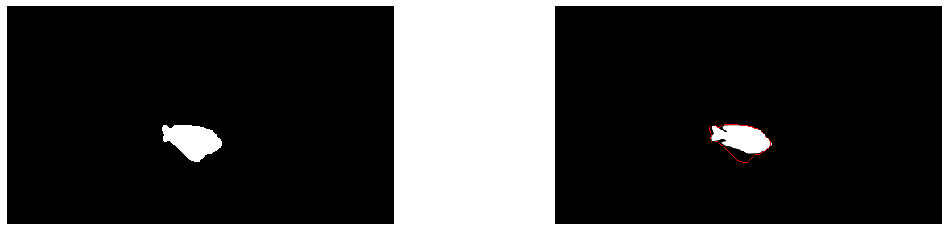

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


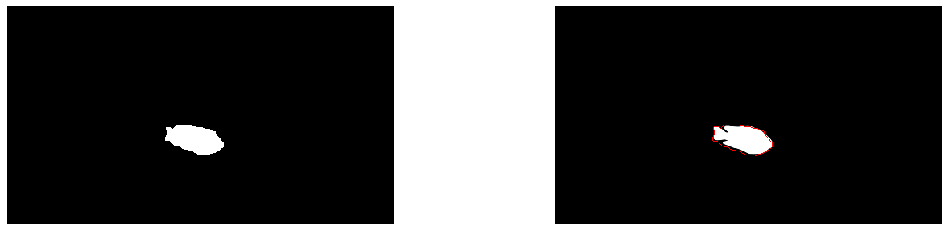

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


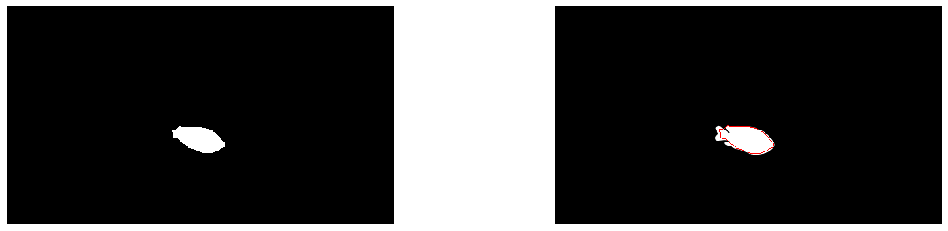

In [0]:
img_begin = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im_begin)).astype(np.float32)/255.
mask_begin = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im_begin))
img_begin = rgb2gray(img_begin)   # pre-processing

best_mask = list_mask



for im in range(im_begin+1,im_end+1):
    img_current = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im)).astype(np.float32)/255.
    mask_current = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im_begin))
    img_current = rgb2gray(img_current) # pre-processing
    
    boundaries = mark_boundaries(img_current, best_mask[im-2]==255, color = (255,0,0))
    
    plt.figure(figsize=(18, 4))
    plt.subplot(121)
    plt.axis('off')
    plt.imshow(best_mask[im-2],cmap='gray')
    plt.subplot(122)
    plt.axis('off')
    plt.imshow(boundaries)
    plt.show()

# 3.Octopus sequential integration

In [0]:
name = 'octopus'
im_begin = 1
im_end = 26

mask = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,1))
list_mask = [mask]


for im in tqdm(range(im_begin, im_end)):
    B = io.imread('../sequences-test/'+name+'/%0*d.bmp'%(3,im))
    B_mask = list_mask[-1]
    
    A = io.imread('../sequences-test/'+name+'/%0*d.bmp'%(3,im+1))
    mask_A  = reconstructMaskConsecutive_color(A, B, B_mask,10)
    list_mask.append(mask_A)

 17%|█▋        | 1/6 [00:04<00:22,  4.54s/it]

1670.4906464868338



 33%|███▎      | 2/6 [00:07<00:16,  4.06s/it]

187.3392644375439



 50%|█████     | 3/6 [00:10<00:10,  3.63s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.29s/it]

0.0



 83%|████████▎ | 5/6 [00:14<00:03,  3.01s/it]

0.0



100%|██████████| 6/6 [00:17<00:00,  2.85s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:24,  4.87s/it]

1605.7393935505227



 33%|███▎      | 2/6 [00:08<00:17,  4.35s/it]

342.3419343288228



 50%|█████     | 3/6 [00:10<00:11,  3.83s/it]

0.0



 67%|██████▋   | 4/6 [00:13<00:06,  3.42s/it]

41.0



 83%|████████▎ | 5/6 [00:15<00:03,  3.08s/it]

19.0



100%|██████████| 6/6 [00:17<00:00,  2.93s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:21,  4.29s/it]

1615.2207279502081



 33%|███▎      | 2/6 [00:07<00:15,  3.87s/it]

261.12832094585224



 50%|█████     | 3/6 [00:09<00:10,  3.48s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.17s/it]

31.0



 83%|████████▎ | 5/6 [00:14<00:02,  2.90s/it]

0.0



100%|██████████| 6/6 [00:16<00:00,  2.78s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:21,  4.32s/it]

1695.5453400012634



 33%|███▎      | 2/6 [00:07<00:15,  3.90s/it]

247.7518920210298



 50%|█████     | 3/6 [00:09<00:10,  3.50s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.18s/it]

0.0



 83%|████████▎ | 5/6 [00:14<00:02,  2.94s/it]

0.0



100%|██████████| 6/6 [00:16<00:00,  2.80s/it]

19.1049731745428



 17%|█▋        | 1/6 [00:04<00:21,  4.25s/it]

1708.6140582355044



 33%|███▎      | 2/6 [00:07<00:15,  3.84s/it]

102.12737145349429



 50%|█████     | 3/6 [00:09<00:10,  3.45s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.14s/it]

0.0



 83%|████████▎ | 5/6 [00:14<00:02,  2.90s/it]

0.0



100%|██████████| 6/6 [00:16<00:00,  2.77s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:21,  4.25s/it]

1566.4740661753708



 33%|███▎      | 2/6 [00:07<00:15,  3.81s/it]

162.0216034978052



 50%|█████     | 3/6 [00:09<00:10,  3.41s/it]

0.0



 67%|██████▋   | 4/6 [00:11<00:06,  3.12s/it]

36.0



 83%|████████▎ | 5/6 [00:14<00:02,  2.86s/it]

0.0



100%|██████████| 6/6 [00:16<00:00,  2.73s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:21,  4.25s/it]

1653.45093667759



 33%|███▎      | 2/6 [00:07<00:15,  3.82s/it]

31.89043743820395



 50%|█████     | 3/6 [00:09<00:10,  3.44s/it]

12.649110640673518



 67%|██████▋   | 4/6 [00:12<00:06,  3.14s/it]

0.0



 83%|████████▎ | 5/6 [00:14<00:02,  2.89s/it]

0.0



100%|██████████| 6/6 [00:16<00:00,  2.76s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:21,  4.38s/it]

1643.3651450605857



 33%|███▎      | 2/6 [00:07<00:15,  3.93s/it]

178.6728854639114



 50%|█████     | 3/6 [00:09<00:10,  3.51s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.16s/it]

0.0



 83%|████████▎ | 5/6 [00:14<00:02,  2.88s/it]

0.0



100%|██████████| 6/6 [00:16<00:00,  2.75s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:21,  4.30s/it]

1560.0182691237947



 33%|███▎      | 2/6 [00:07<00:15,  3.86s/it]

116.63189958154673



 50%|█████     | 3/6 [00:09<00:10,  3.47s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.15s/it]

0.0



 83%|████████▎ | 5/6 [00:14<00:02,  2.87s/it]

0.0



100%|██████████| 6/6 [00:16<00:00,  2.75s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:22,  4.60s/it]

1515.1197972437692



 33%|███▎      | 2/6 [00:07<00:16,  4.14s/it]

393.86545926242377



 50%|█████     | 3/6 [00:10<00:11,  3.67s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.31s/it]

0.0



 83%|████████▎ | 5/6 [00:14<00:02,  2.99s/it]

0.0



100%|██████████| 6/6 [00:17<00:00,  2.85s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:22,  4.52s/it]

1541.7551686308693



 33%|███▎      | 2/6 [00:07<00:16,  4.07s/it]

409.18455493823325



 50%|█████     | 3/6 [00:10<00:10,  3.62s/it]

57.77542730261716



 67%|██████▋   | 4/6 [00:12<00:06,  3.26s/it]

27.586228448267445



 83%|████████▎ | 5/6 [00:14<00:02,  2.95s/it]

44.0



100%|██████████| 6/6 [00:16<00:00,  2.82s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:21,  4.38s/it]

1521.8045209553034



 33%|███▎      | 2/6 [00:07<00:15,  3.95s/it]

333.39916016690864



 50%|█████     | 3/6 [00:09<00:10,  3.54s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.22s/it]

34.0



 83%|████████▎ | 5/6 [00:14<00:02,  2.97s/it]

12.0



100%|██████████| 6/6 [00:16<00:00,  2.82s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:22,  4.50s/it]

1611.1036589865967



 33%|███▎      | 2/6 [00:07<00:16,  4.03s/it]

274.23712367219724



 50%|█████     | 3/6 [00:10<00:10,  3.60s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.26s/it]

0.0



 83%|████████▎ | 5/6 [00:14<00:02,  2.95s/it]

0.0



100%|██████████| 6/6 [00:16<00:00,  2.82s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:22,  4.49s/it]

1594.2559393020933



 33%|███▎      | 2/6 [00:07<00:16,  4.02s/it]

240.5784695270963



 50%|█████     | 3/6 [00:10<00:10,  3.61s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.32s/it]

33.0



 83%|████████▎ | 5/6 [00:15<00:03,  3.05s/it]

0.0



100%|██████████| 6/6 [00:17<00:00,  2.90s/it]

50.0



 17%|█▋        | 1/6 [00:04<00:24,  4.94s/it]

1616.677147732348



 33%|███▎      | 2/6 [00:08<00:17,  4.43s/it]

361.82454311447697



 50%|█████     | 3/6 [00:10<00:11,  3.92s/it]

46.0



 67%|██████▋   | 4/6 [00:13<00:06,  3.49s/it]

5.0



 83%|████████▎ | 5/6 [00:15<00:03,  3.18s/it]

0.0



100%|██████████| 6/6 [00:18<00:00,  3.01s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:24,  4.81s/it]

1508.679886523314



 33%|███▎      | 2/6 [00:08<00:17,  4.37s/it]

318.0110060988456



 50%|█████     | 3/6 [00:10<00:11,  3.87s/it]

30.14962686336267



 67%|██████▋   | 4/6 [00:13<00:06,  3.46s/it]

0.0



 83%|████████▎ | 5/6 [00:15<00:03,  3.13s/it]

0.0



100%|██████████| 6/6 [00:17<00:00,  2.99s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:21,  4.35s/it]

1676.179882948128



 33%|███▎      | 2/6 [00:07<00:15,  3.92s/it]

26.0



 50%|█████     | 3/6 [00:09<00:10,  3.55s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.21s/it]

0.0



 83%|████████▎ | 5/6 [00:14<00:02,  2.94s/it]

0.0



100%|██████████| 6/6 [00:16<00:00,  2.82s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:22,  4.49s/it]

1529.0925413460102



 33%|███▎      | 2/6 [00:07<00:16,  4.03s/it]

156.01281998605114



 50%|█████     | 3/6 [00:10<00:10,  3.65s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.32s/it]

0.0



 83%|████████▎ | 5/6 [00:15<00:03,  3.03s/it]

0.0



100%|██████████| 6/6 [00:17<00:00,  2.90s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:22,  4.55s/it]

1601.3250763039964



 33%|███▎      | 2/6 [00:07<00:16,  4.11s/it]

277.58602270287315



 50%|█████     | 3/6 [00:10<00:11,  3.70s/it]

21.93171219946131



 67%|██████▋   | 4/6 [00:12<00:06,  3.35s/it]

0.0



 83%|████████▎ | 5/6 [00:15<00:03,  3.06s/it]

0.0



100%|██████████| 6/6 [00:17<00:00,  2.91s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:22,  4.56s/it]

1638.4050170821622



 33%|███▎      | 2/6 [00:07<00:16,  4.10s/it]

173.96551382386107



 50%|█████     | 3/6 [00:10<00:11,  3.68s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.31s/it]

0.0



 83%|████████▎ | 5/6 [00:15<00:03,  3.04s/it]

0.0



100%|██████████| 6/6 [00:17<00:00,  2.90s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:22,  4.48s/it]

1567.3509498513727



 33%|███▎      | 2/6 [00:07<00:16,  4.01s/it]

138.27508813954884



 50%|█████     | 3/6 [00:10<00:10,  3.60s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.26s/it]

12.0



 83%|████████▎ | 5/6 [00:14<00:02,  2.98s/it]

0.0



100%|██████████| 6/6 [00:16<00:00,  2.83s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:22,  4.51s/it]

1534.0440019764753



 33%|███▎      | 2/6 [00:07<00:16,  4.06s/it]

255.0215677153601



 50%|█████     | 3/6 [00:10<00:10,  3.62s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.26s/it]

14.317821063276353



 83%|████████▎ | 5/6 [00:14<00:02,  2.97s/it]

0.0



100%|██████████| 6/6 [00:17<00:00,  2.84s/it]

17.0



 17%|█▋        | 1/6 [00:04<00:22,  4.50s/it]

1613.0034097918083



 33%|███▎      | 2/6 [00:07<00:16,  4.06s/it]

189.9578900704048



 50%|█████     | 3/6 [00:10<00:10,  3.63s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.25s/it]

35.0



 83%|████████▎ | 5/6 [00:14<00:02,  2.96s/it]

0.0



100%|██████████| 6/6 [00:17<00:00,  2.84s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:23,  4.72s/it]

1522.4762723931037



 33%|███▎      | 2/6 [00:07<00:17,  4.27s/it]

318.5435606004303



 50%|█████     | 3/6 [00:10<00:11,  3.80s/it]

0.0



 67%|██████▋   | 4/6 [00:13<00:06,  3.42s/it]

3.0



 83%|████████▎ | 5/6 [00:15<00:03,  3.11s/it]

0.0



100%|██████████| 6/6 [00:17<00:00,  2.96s/it]

0.0



 17%|█▋        | 1/6 [00:04<00:22,  4.54s/it]

1584.4519557247547



 33%|███▎      | 2/6 [00:07<00:16,  4.09s/it]

244.5874076889487



 50%|█████     | 3/6 [00:10<00:10,  3.64s/it]

0.0



 67%|██████▋   | 4/6 [00:12<00:06,  3.28s/it]

0.0



 83%|████████▎ | 5/6 [00:14<00:03,  3.01s/it]

0.0



100%|██████████| 6/6 [00:17<00:00,  2.87s/it]

0.0



100%|██████████| 25/25 [47:55<00:00, 115.03s/it]


## 3.2 Evaluation

100%|██████████| 25/25 [00:00<00:00, 630.82it/s]


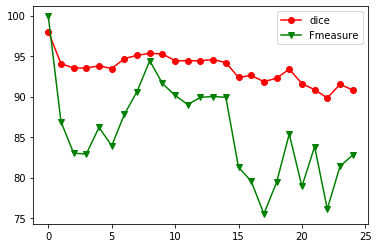

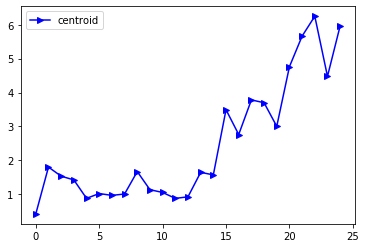

The average value of dice is 93.44398834657312
The average value of Fmeasure is 85.62708987163583
The average value of centroid is 2.472793287425088


In [0]:
list_groundTruth = []
for im in tqdm(range(im_begin+1, im_end+1)):
    ground_truth = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im))
    list_groundTruth.append(ground_truth)
    
list_DICE = []
list_boundry = []
list_centroid = []

for (mask,ground_truth) in zip(list_mask, list_groundTruth):
    list_DICE.append(DICE_assessment(ground_truth, mask))
    list_boundry.append(db_eval_boundary(mask>100,ground_truth>100,bound_th=0.008))
    list_centroid.append(centroid_assessment(ground_truth.astype(int), mask.astype(int)))
plt.plot(range(len(list_DICE)),list_DICE,marker='o',color='r')
plt.plot(range(len(list_boundry)),list_boundry,marker='v',color='g')
plt.legend(['dice', 'Fmeasure'])
plt.show()

plt.plot(range(len(list_centroid)), list_centroid, marker='>', color='b')
plt.legend(['centroid'])
plt.show()

print('The average value of dice is '+ str(np.mean(list_DICE)))
print('The average value of Fmeasure is '+ str(np.mean(list_boundry)))
print('The average value of centroid is '+ str(np.mean(list_centroid)))

## 3.3 Mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


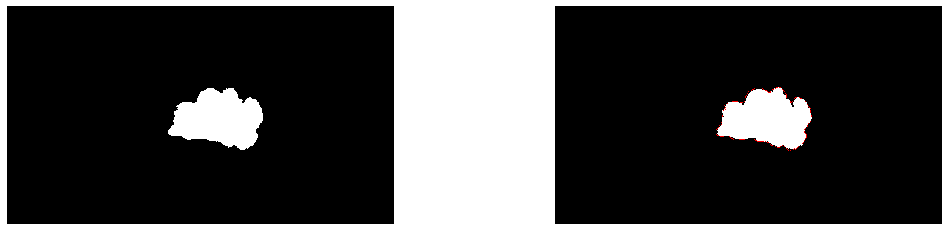

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


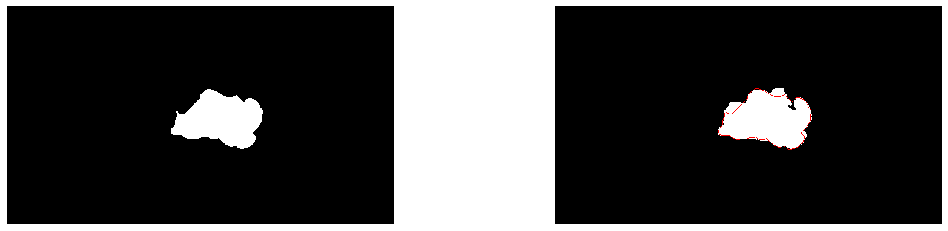

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


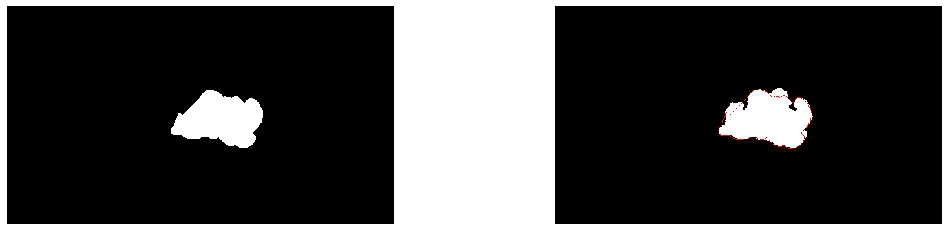

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


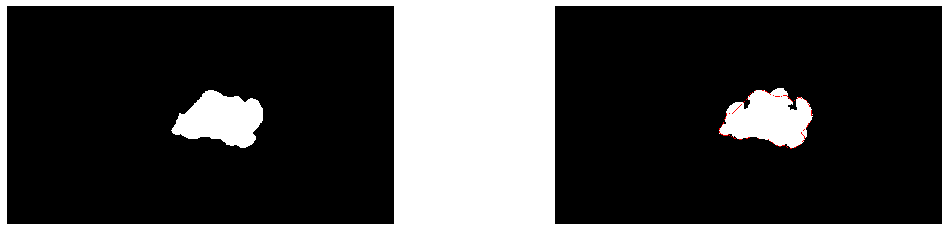

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


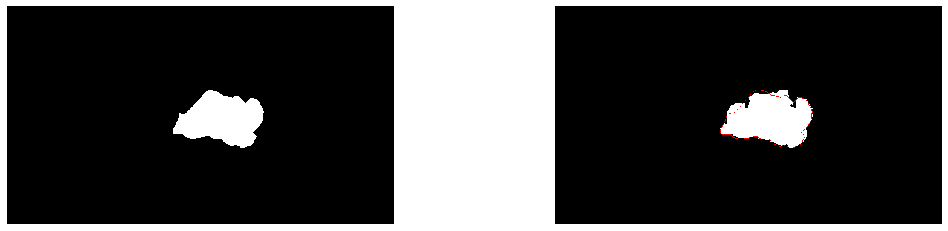

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


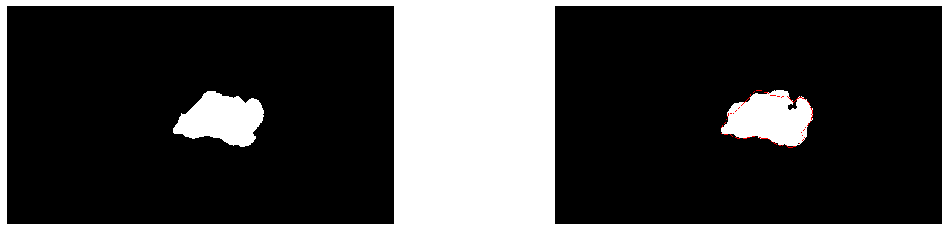

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


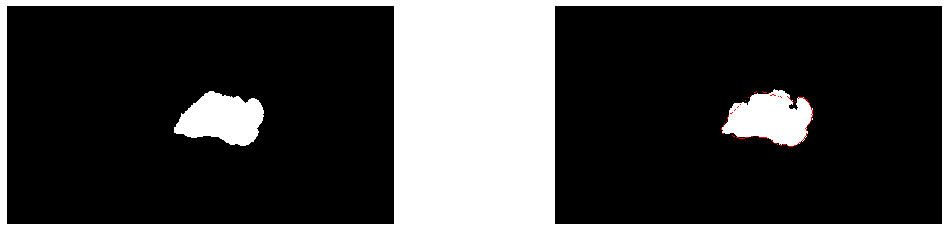

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


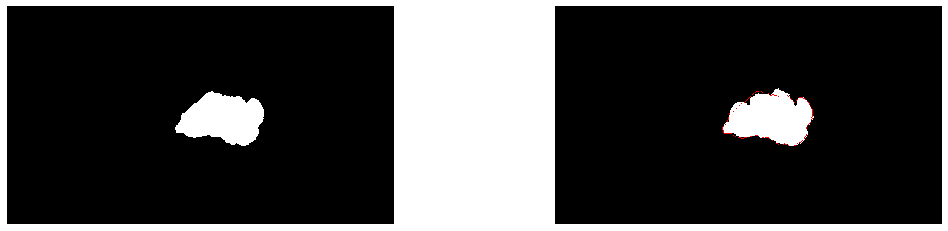

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


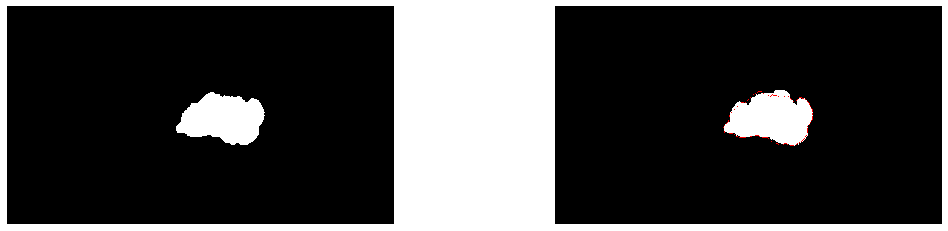

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


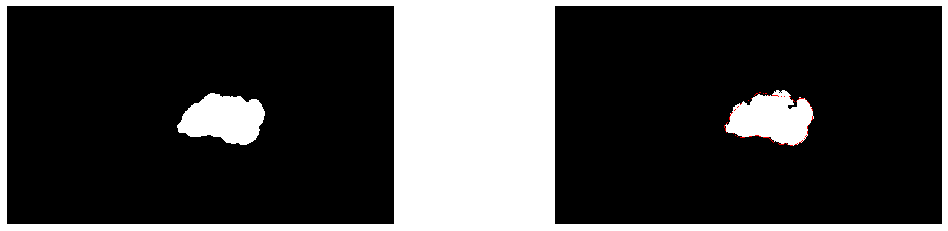

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


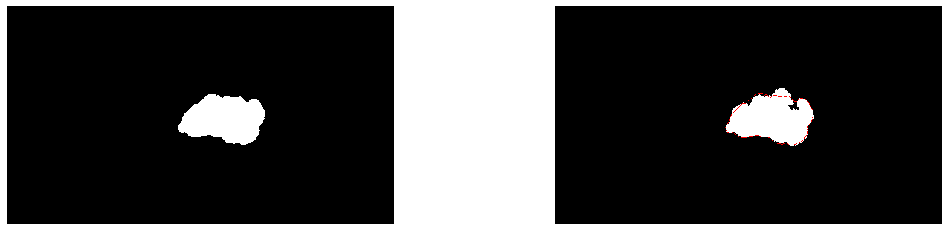

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


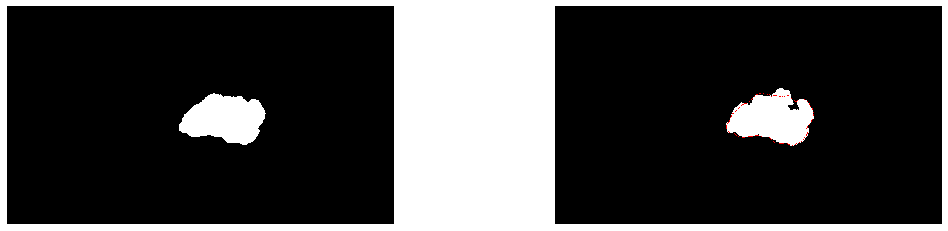

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


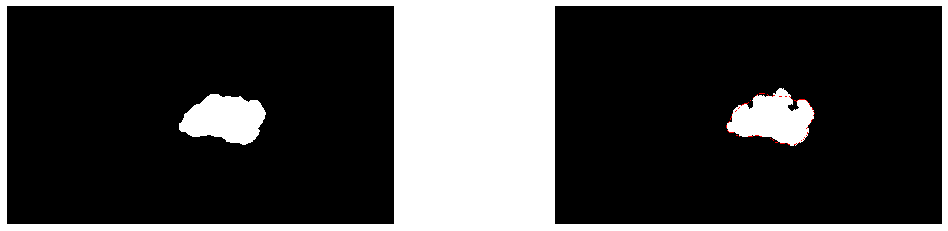

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


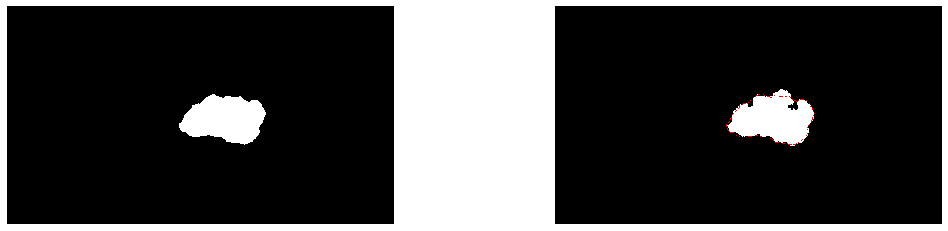

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


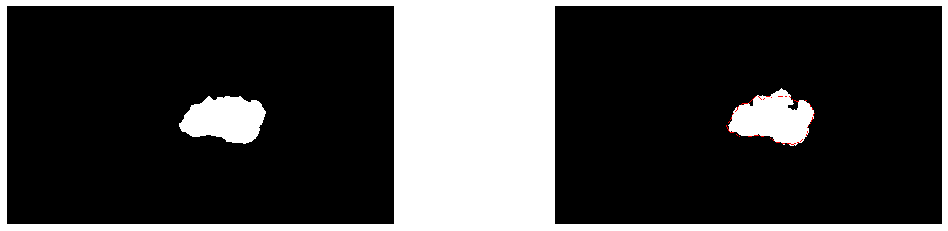

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


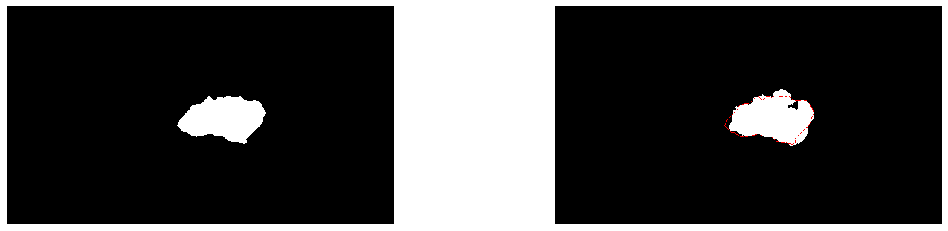

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


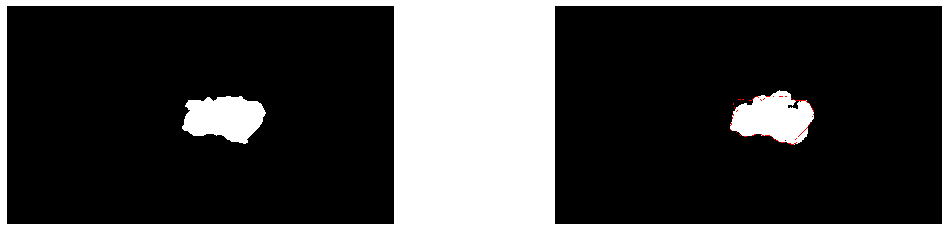

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


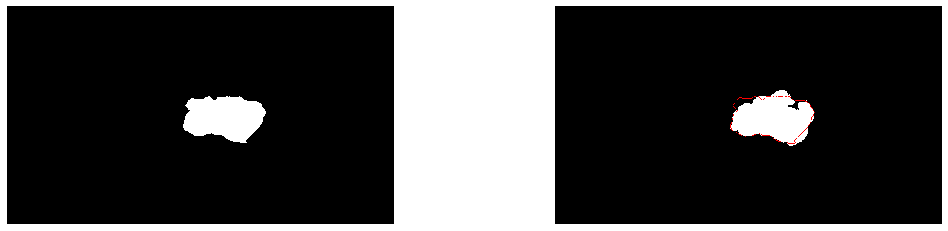

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


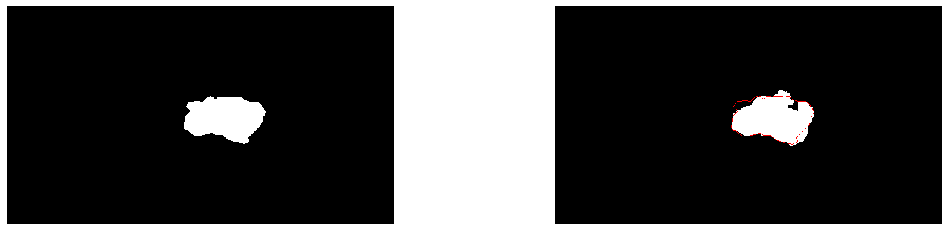

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


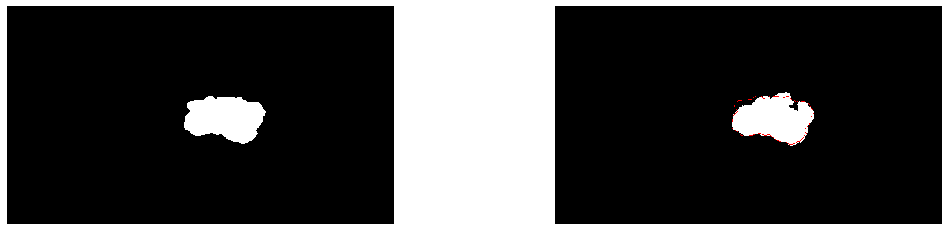

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


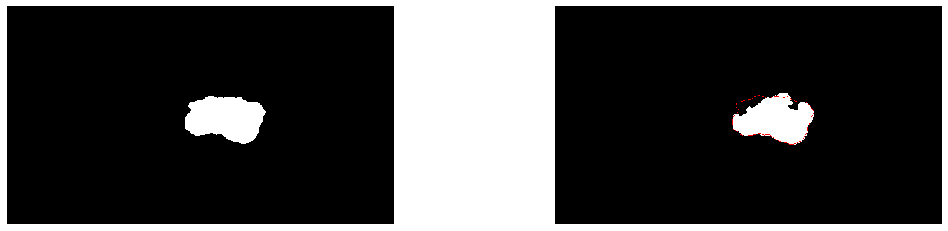

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


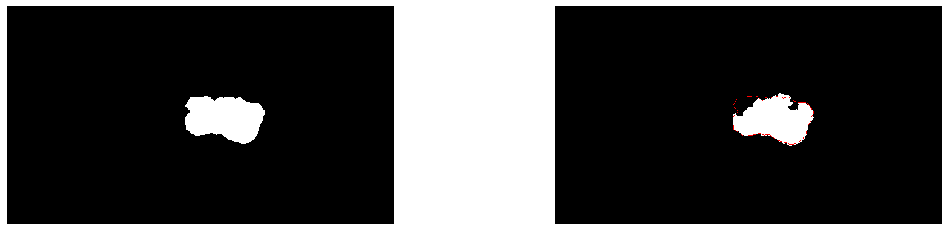

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


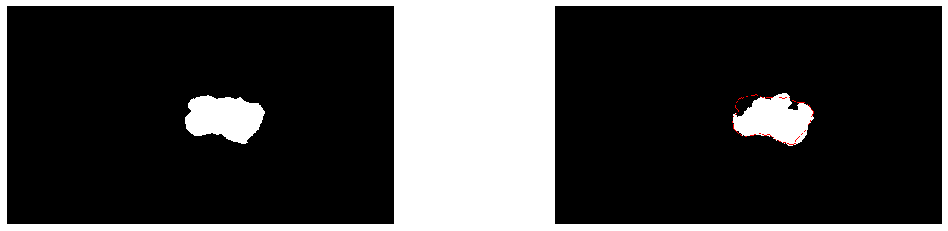

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


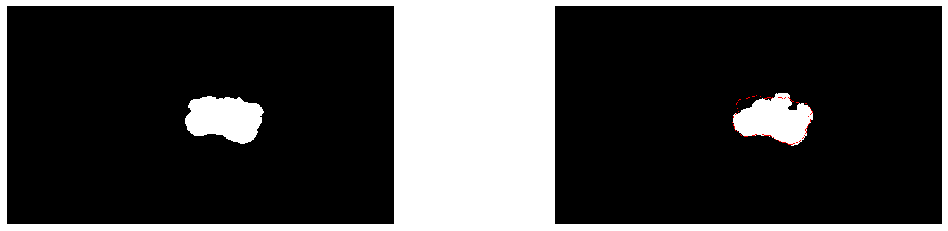

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


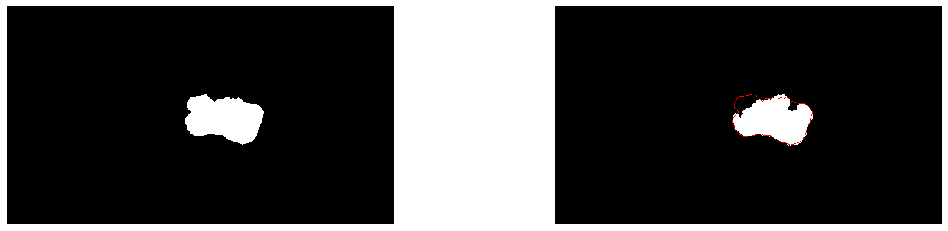

In [0]:
img_begin = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im_begin)).astype(np.float32)/255.
mask_begin = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im_begin))
img_begin = rgb2gray(img_begin)   # pre-processing

best_mask = list_mask



for im in range(im_begin+1,im_end+1):
    img_current = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im)).astype(np.float32)/255.
    mask_current = io.imread('../sequences-test/'+name+'/%0*d.png'%(3,im_begin))
    img_current = rgb2gray(img_current) # pre-processing
    
    boundaries = mark_boundaries(img_current, best_mask[im-2]==255, color = (255,0,0))
    
    plt.figure(figsize=(18, 4))
    plt.subplot(121)
    plt.axis('off')
    plt.imshow(best_mask[im-2],cmap='gray')
    plt.subplot(122)
    plt.axis('off')
    plt.imshow(boundaries)
    plt.show()